<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Siemens/Siemens_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "SIEDEEUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-28 16:01:51,761 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-28 16:01:51,765 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for SIEDEEUR
2019-08-28 16:02:59,325 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-28 16:05:20,934 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-28 16:06:35,338 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-28 16:07:47,338 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-28 16:09:01,769 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-28 16:10:13,760 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-28 16:11:28,160 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-28 16:12:42,538 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-28 16:16:28,790 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_SIEDEEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-SIEDEEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-SIEDEEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close      Volume
Date                                                               
2018-01-02 08:00:00  1.16037  1.16037  1.14817  1.14927  180.148102
2018-01-02 09:00:00  1.14918  1.15228  1.14177  1.14528  215.898849
2018-01-02 10:00:00  1.14528  1.15168  1.14377  1.14958  158.849991
2018-01-02 11:00:00  1.14958  1.15087  1.14757  1.14857  105.429596
2018-01-02 12:00:00  1.14857  1.14948  1.14718  1.14837  104.159477
...                      ...      ...      ...      ...         ...
2018-12-28 08:00:00  0.96328  0.97518  0.96297  0.97508   33.506767
2018-12-28 09:00:00  0.97508  0.97617  0.97297  0.97548   40.794502
2018-12-28 10:00:00  0.97537  0.97908  0.97477  0.97787   34.831470
2018-12-28 11:00:00  0.97787  0.98108  0.97517  0.97658   33.270996
2018-12-28 12:00:00  0.97648  0.97958  0.97517  0.97788   33.073814

[2247 rows x 5 columns]

Open         High          Low        Close       Volume
count  2247.000000  2247.000000  2247.000000  2247.000000  2247.000000
mean      1.097011     1.099799     1.094210     1.096984    65.699562
std       0.068649     0.068651     0.068720     0.068741    78.435966
min       0.951380     0.954380     0.949670     0.951370     0.005109
25%       1.036370     1.038880     1.033170     1.036370    18.709112
50%       1.099270     1.101780     1.096370     1.099270    32.345478
75%       1.149975     1.152230     1.147175     1.149675    84.548706
max       1.254180     1.256880     1.252770     1.253970   836.192505

25

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close      Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
2018-01-09 13:00:00  1.21918  1.22188  1.21877  1.21967  103.529503    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  1.217953  1.205484  1.206714  1.220313  1.216155  1.216817    1.214925    1.215230  1.209385  1.216761  1.220388  1.217577  1.218081  1.216761  1.218173  1.207914                1.224628                 1.216761                1.208895                1.228561                 1.216761                1.204961                1.232494                 1.216761                1.201028                1.236428                 1.216761                1.197095  1.216155  1.218836  1.209028                1.224021                 1.216155                1.208288                1.227955                 1.216155                1.204355                1.231888                 1.216155                1.200421                1.235821                 1.216155   
2018-01-09 14:00:00  1.21967  1.21988  1.21477  1.21617  139.522293    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  1.217864  1.205793  1.207976  1.219395  1.216158  1.216780    1.216325    1.215525  1.210432  1.217647  1.218737  1.218072  1.217950  1.217647  1.217920  1.209026                1.223071                 1.217647                1.212224                1.225783                 1.217647                1.209512                1.228495                 1.217647                1.206800                1.231206                 1.217647                1.204088  1.216158  1.217189  1.210154                1.221582                 1.216158                1.210734                1.224293                 1.216158                1.208023                1.227005                 1.216158                1.205311                1.229717                 1.216158   
2018-01-09 15:00:00  1.21617  1.21968  1.21518  1.21768  162.990295    9          1          9             31   

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000    2197.000000  2197.000000   2197.000000     2197.000000       2197.000000  2197.000000  2197.000000  2197.000000  2197.000000   2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000  2197.000000  2197.000000  2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000             2197.000000   
mean      1.094994     1.097757     1.092180     1.094942    64.172073    15.961766     2.030951   184.352299      30.415567    11.377788      0.032317        0.024124          0.004096     6.563041     2.522986    26.903050     2.030951      1.989076    26.903050     1.095329     1.096007     0.054133     1.094943     1.095331     1.094942     1.095266     1.095184     1.095667     1.095330     1.094937     1.095329     1.095200     1.095330     1.095039     1.096102                1.104167                 1.095330                1.086493                1.108586                 1.095330                1.082074                1.113004                 1.095330                1.077656                1.117423                 1.095330                1.073237     1.095331     1.095028     1.095990                1.104168                 1.095331                1.086494                1.108587                 1.095331                1.082075                1.113005   
std       0.068003     0.067973     0.068059     0.068063    78.444832     8.549779     1.407418   101.376252       0.857196     2.623145      0.176880        0.153468          0.063887     3.337737     1.100192    14.482172     1.407418      1.400582    14.482172     0.067868     0.067022     1.095997     0.068186     0.067736     0.067497     0.067847     0.067793     0.068189     0.067858     0.068122     0.067909     0.067893     0.067858     0.067980     0.067360                0.067750                 0.067858                0.068495                0.067896                 0.067858                0.069009                0.068174                 0.067858                0.069648                0.068584                 0.067858                0.070410     0.067736     0.067973     0.067436                0.067621                 0.067736                0.068382                0.067764                 0.067736                0.068899                0.068040   
min       0.951380     0.954380     0.949670     0.951370     0.005109     1.000000     0.000000     9.000

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.884412  0.884297  0.887826  0.886649  0.123805    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.900092  0.859651  0.985609  0.892957  0.884064  0.896063    0.878167    0.875499  0.845398  0.884548  0.891143  0.889782  0.889727  0.884548  0.881542  0.860552                0.884805                 0.884548                0.879658                0.878860                 0.884548                0.878405                0.813330                 0.884548                0.877220                0.756492                 0.884548                0.876097  0.884064  0.887477  0.863769                0.879189                 0.884064                0.879842                0.872742                 0.884064                0.878583                0.833181                 0.884064                0.877393                0.771507                 0.884064   
2018-01-09 14:00:00  0.886031  0.877686  0.874629  0.875082  0.166849    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.899782  0.860786  0.986113  0.889920  0.884076  0.895934    0.882925    0.876520  0.848808  0.887552  0.885716  0.891455  0.889283  0.887552  0.880702  0.864522                0.879530                 0.887552                0.890532                0.869511                 0.887552                0.892858                0.800877                 0.887552                0.895059                0.741376                 0.887552                0.897144  0.884076  0.882000  0.867765                0.870884                 0.884076                0.887844                0.860372                 0.884076                0.890248                0.817436                 0.884076                0.892523                0.753284                 0.884076   
2018-01-09 15:00:00  0.874472  0.877025  0.875982  0.880073  0.194915    9          1          9         

139551

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         3 hours 54 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_zmi1s6
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_162628_mod...  0.728175  0.628681              0.307209  0.468416  0.219413
1  DeepLearning_grid_1_AutoML_20190828_162628_mod...  0.727224  2.591872              0.327381  0.571437  0.326540
2  DeepLearning_grid_1_AutoML_20190828_162628_mod...  0.723876  0.625574              0.324074  0.468640  0.219624
3  DeepLearning_grid_1_AutoML_20190828_162628_mod...  0.722801  0.729945              0.297784  0.484980  0.235205
4  DeepLearning_grid_1_AutoML_20190828_162628_mod...  0.712384  0.632436              0.358631  0.469118  0.220071
5  DeepLearning_grid_1_AutoML_20190828_162628_mod...  0.711640  0.628766              0.350198  0.470390  0.221267
6  DeepLearning_grid_1_AutoML_20190828_162628_mod...  0.711558  1.145268              0.349372  0.534942  0.286163
7  DeepLearning_grid_1_AutoML_20190828_162628_mod...  0.680804  1.441491              0.354993  0.557774  0.311112
8  DeepLearning_grid_1_AutoML_20190828_162628_mod...  0.625165  0.660027              0.406746  0.483462  0.233735
9              DeepLearning_1_AutoML_20190828_162628  0.597470  1.523967              0.438327  0.660275  0.435963

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.008507
1           CDLCLOSINGMARUBOZU             0.738057           0.738057    0.006279
2                  CDLLONGLINE             0.705550           0.705550    0.006002
3                          SUB             0.488787           0.488787    0.004158
4                          DIV             0.480151           0.480151    0.004085
...                        ...                  ...                ...         ...
1028  BBANDS_middleband_20_0_4             0.087828           0.087828    0.000747
1029                   DEMA_20             0.087747           0.087747    0.000746
1030            CDLHARAMICROSS             0.086303           0.086303    0.000734
1031   BBANDS_middleband_8_0_2             0.086182           0.086182    0.000733
1032       CDLXSIDEGAP3METHODS             0.085126           0.085126    0.000724

[1033 rows x 4 columns]

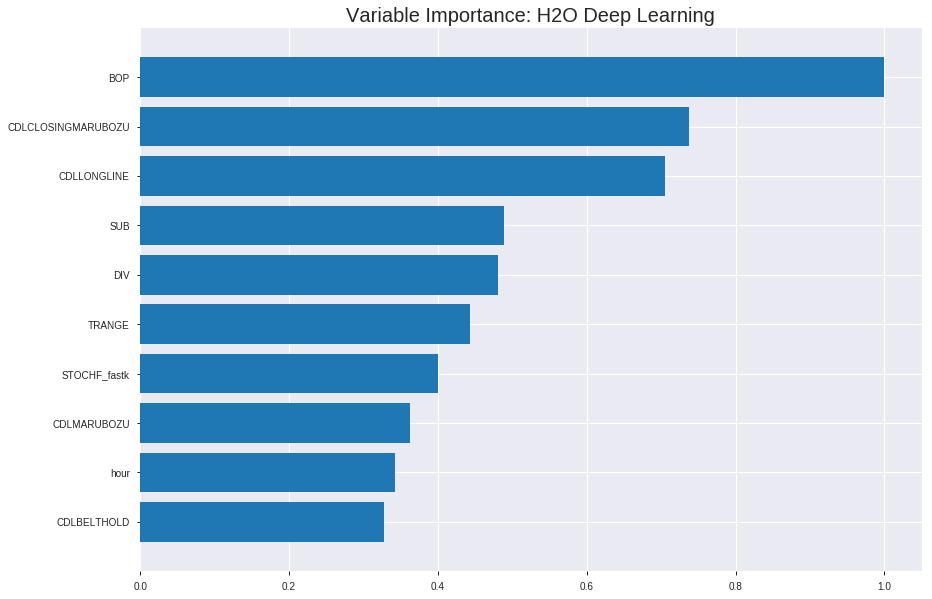

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_162628_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17954124609351643
RMSE: 0.4237230771311806
LogLoss: 0.5279354820024214
Mean Per-Class Error: 0.25350778943081154
AUC: 0.8329718630146284
pr_auc: 0.7950653552169007
Gini: 0.6659437260292569
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4889250829300524: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      410  395   0.4907   (395.0/805.0)
1      47   685   0.0642   (47.0/732.0)
Total  457  1080  0.2876   (442.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488925     0.756071  230
max f2                       0.47994      0.856895  236
max f0point5                 0.60353      0.745443  153
max accuracy                 0.577865     0.748211  169
max precision                0.999688     1         0
max recall                   0.0213792    1         390
max specificity              0.999688     1         0
max absolute_mcc             0.577865     0.494812  169
max min_per_class_accuracy   0.560035     0.741803  182
max mean_per_class_accuracy  0.562844     0.746492  180

Gains/Lift Table: Avg response rate: 47.63 %, avg score: 54.56 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.999269           2.09973    2.09973            1                0.999763   1                           0.999763            0.0218579       0.0218579                  109.973   109.973
    2        0.0201692                   0.995042           2.09973    2.09973            1                0.997747   1                           0.998788            0.0204918       0.0423497                  109.973   109.973
    3        0.0305791                   0.986963           2.09973    2.09973            1                0.990704   1                           0.996036            0.0218579       0.0642077                  109.973   109.973
    4        0.0403383                   0.969464           2.09973    2.09973            1                0.980484   1                           0.992273            0.0204918       0.0846995                  109.973   109.973
    5        0.0500976                   0.943445           1.95974    2.07246            0.933333         0.953338   0.987013                    0.984688            0.0191257       0.103825                   95.9745   107.246
    6        0.100195                    0.843115           1.88157    1.97702            0.896104         0.895535   0.941558                    0.940112            0.0942623       0.198087                   88.1573   97.7015
    7        0.150293                    0.770032           1.66342    1.87248            0.792208         0.805639   0.891775                    0.895287            0.0833333       0.281421                   66.342    87.2484
    8        0.20039                     0.71569            1.79977    1.8543             0.857143         0.742633   0.883117                    0.857124            0.0901639       0.371585                   79.9766   85.4304
    9        0.299935                    0.644337           1.42727    1.71258            0.679739         0.675422   0.815618                    0.796819            0.142077        0.513661                   42.7265   71.2575
    10       0.40013                     0.591957           1.30892    1.6115             0.623377         0.616935   0.76748                     0.751775            0.131148        0.644809                   30.8921   61.1498
    11       0.500325                    0.554916           1.1044     1.50995            0.525974         0.573365   0.719116                    0.716046            0.110656        0.755464                   10.4402   50.9947
    12       0.59987                     0.529339           0.933212   1.41424            0.444444         0.542111   0.673536                    0.687183            0.0928962       0.848361                   -6.67881  41.4241
    13       0.700065                    0.490431           0.83171    1.33087            0.396104         0.513369   0.633829                    0.662306            0.0833333       0.931694                   -16.829   33.0868
    14       0.79961                     0.378546           0.37054    1.21132            0.176471         0.444833   0.576892                    0.635233            0.0368852       0.968579                   -62.946   21.1315
    15       0.899805                    0.18816            0.231788   1.10224            0.11039          0.29592    0.524946                    0.59745             0.023224        0.991803                   -76.8212  10.2243
    16       1                           0.000181196        0.0818075  1                  0.038961         0.0802434  0.476252 



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19886762467396782
RMSE: 0.4459457642740514
LogLoss: 0.5804516233758934
Mean Per-Class Error: 0.3007825507825508
AUC: 0.7689185814185815
pr_auc: 0.7537216595462283
Gini: 0.537837162837163
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48868694848060934: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  111  0.4805   (111.0/231.0)
1      30   178  0.1442   (30.0/208.0)
Total  150  289  0.3212   (141.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488687     0.716298  256
max f2                       0.271216     0.838174  335
max f0point5                 0.574393     0.689834  173
max accuracy                 0.574393     0.701595  173
max precision                0.999632     1         0
max recall                   0.0171996    1         393
max specificity              0.999632     1         0
max absolute_mcc             0.568362     0.40039   178
max min_per_class_accuracy   0.549131     0.692308  194
max mean_per_class_accuracy  0.568362     0.699217  178

Gains/Lift Table: Avg response rate: 47.38 %, avg score: 52.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.975641           2.11058   2.11058            1                0.993165   1                           0.993165            0.0240385       0.0240385                  111.058   111.058
    2        0.0205011                   0.933386           2.11058   2.11058            1                0.949314   1                           0.973676            0.0192308       0.0432692                  111.058   111.058
    3        0.0318907                   0.911691           1.68846   1.95982            0.8              0.923273   0.928571                    0.955675            0.0192308       0.0625                     68.8462   95.9821
    4        0.0410023                   0.899354           2.11058   1.99332            1                0.902024   0.944444                    0.943752            0.0192308       0.0817308                  111.058   99.3323
    5        0.0501139                   0.892681           2.11058   2.01464            1                0.897017   0.954545                    0.935255            0.0192308       0.100962                   111.058   101.464
    6        0.100228                    0.799851           1.91871   1.96667            0.909091         0.8268     0.931818                    0.881027            0.0961538       0.197115                   91.8706   96.6674
    7        0.150342                    0.741758           1.72684   1.88673            0.818182         0.770035   0.893939                    0.84403             0.0865385       0.283654                   72.6836   88.6728
    8        0.200456                    0.701506           1.24716   1.72684            0.590909         0.720603   0.818182                    0.813173            0.0625          0.346154                   24.7159   72.6836
    9        0.300683                    0.642987           1.39106   1.61491            0.659091         0.672274   0.765152                    0.766207            0.139423        0.485577                   39.1062   61.4911
    10       0.400911                    0.587515           1.00732   1.46301            0.477273         0.613248   0.693182                    0.727967            0.100962        0.586538                   0.73208   46.3014
    11       0.501139                    0.546053           1.15122   1.40066            0.545455         0.563573   0.663636                    0.695088            0.115385        0.701923                   15.1224   40.0656
    12       0.599089                    0.509958           0.932581  1.32413            0.44186          0.531201   0.627376                    0.668293            0.0913462       0.793269                   -6.74195  32.4126
    13       0.699317                    0.469229           0.719515  1.23747            0.340909         0.489967   0.586319                    0.642735            0.0721154       0.865385                   -28.0485  23.7472
    14       0.799544                    0.357116           0.767483  1.17856            0.363636         0.416279   0.558405                    0.614347            0.0769231       0.942308                   -23.2517  17.8556
    15       0.899772                    0.208716           0.383741  1.09002            0.181818         0.271426   0.516456                    0.576148            0.0384615       0.980769                   -61.6259  9.00195
    16       1                           0.000430981        0.191871  1                  0.0909091        0.0907442  0.473804                   


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:37:41  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 16:37:43  7 min 40.291 sec   347 obs/sec       0.344828  1             530        0.52942          0.911475            -0.123678      0.656449        0.635695           1.83726          0.424203                         0.608139           1.5396                -0.483405        0.594458          0.57439              2.11058            0.47836
    2019-08-28 16:38:05  8 min  2.280 sec   440 obs/sec       6.12492   18            9414       0.479297         0.650341            0.0790214      0.68316         0.680898           2.09973          0.461939                         0.486439           0.665628              0.0509046        0.726669          0.687536             1.68846            0.318907
    2019-08-28 16:38:26  8 min 25.131 sec   466 obs/sec       12.4268   37            19100      0.459021         0.608537            0.155295       0.743112        0.723958           2.09973          0.346779                         0.47621            0.64459               0.0904002        0.68724           0.6793               1.68846            0.453303
    2019-08-28 16:39:00  8 min 57.698 sec   486 obs/sec       22.5927   67            34725      0.438557         0.563434            0.228933       0.785114        0.766191           2.09973          0.34743                          0.489147           0.67908               0.0403051        0.738439          0.715908             2.11058            0.362187
    2019-08-28 16:39:22  9 min 19.841 sec   494 obs/sec       29.3917   87            45175      0.428111         0.541389            0.265227       0.80751         0.780218           2.09973          0.291477                         0.470828           0.632982              0.110842         0.761103          0.731566             2.11058            0.314351
    2019-08-28 16:39:44  9 min 42.027 sec   498 obs/sec       36.1444   107           55554      0.436384         0.555347            0.236552       0.804233        0.785801           2.09973          0.285621                         0.454589           0.60556               0.17112          0.743475          0.728712             2.11058            0.357631
    2019-08-28 16:40:06  10 min  3.922 sec  503 obs/sec       42.9584   127           66027      0.420061         0.522669            0.2926         0.817017        0.795861           2.09973          0.285621                         0.453098           0.605941              0.17655          0.752092          0.740063             2.11058            0.353075
    2019-08-28 16:40:28  10 min 25.725 sec  506 obs/sec       49.7391   147           76449      0.411732         0.505761            0.320374       0.83443         0.795052           2.09973          0.271308                         0.448768           0.599284              0.192212         0.773414          0.756951             2.11058            0.318907
    2019-08-2

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.00850707518209651
CDLCLOSINGMARUBOZU        0.7380571365356445     0.7380571365356445   0.006278707549191597
CDLLONGLINE               0.7055500745773315     0.7055500745773315   0.006002167529163159
SUB                       0.4887872338294983     0.4887872338294983   0.004158149746236529
DIV                       0.4801514148712158     0.4801514148712158   0.004084684185099445
---                       ---                    ---                  ---
BBANDS_middleband_20_0_4  0.08782755583524704    0.08782755583524704  0.0007471556205502256
DEMA_20                   0.08774667233228683    0.08774667233228683  0.0007464675385095518
CDLHARAMICROSS            0.08630301803350449    0.08630301803350449  0.0007341862628528536
BBANDS_middleband_8_0_2   0.08618173748254776    0.08618173748254776  0.0007331545200877386
CDLXSIDEGAP3METHODS       0.08512560278177261    0.08512560278177261  0.0007241699027858234


See the whole table with table.as_data_frame()


('accuracy', 0.6909090909090909)

('F1', 0.7166666666666667)

('auc', 0.7281746031746031)

('logloss', 0.6286809732388656)

('mean_per_class_error', 0.30720899470899465)

('rmse', 0.4684157376002874)

('mse', 0.21941330323162128)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


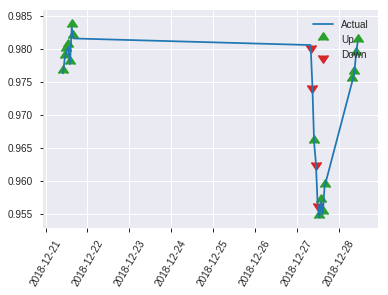


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21941330323162128
RMSE: 0.4684157376002874
LogLoss: 0.6286809732388656
Mean Per-Class Error: 0.30720899470899465
AUC: 0.7281746031746031
pr_auc: 0.6805299520099684
Gini: 0.4563492063492063
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5657697853181957: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      66   46   0.4107   (46.0/112.0)
1      22   86   0.2037   (22.0/108.0)
Total  88   132  0.3091   (68.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.56577      0.716667  131
max f2                       0.270719     0.850394  202
max f0point5                 0.591536     0.682624  113
max accuracy                 0.591536     0.690909  113
max precision                0.962429     1         0
max recall                   0.270719     1         202
max specificity              0.962429     1         0
max absolute_mcc             0.56577      0.393468  131
max min_per_class_accuracy   0.594761     0.669643  109
max mean_per_class_accuracy  0.56577      0.692791  131

Gains/Lift Table: Avg response rate: 49.09 %, avg score: 58.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.950278           1.35802   1.35802            0.666667         0.958451  0.666667                    0.958451            0.0185185       0.0185185                  35.8025   35.8025
    2        0.0227273                   0.912274           2.03704   1.62963            1                0.925677  0.8                         0.945341            0.0185185       0.037037                   103.704   62.963
    3        0.0318182                   0.893698           2.03704   1.74603            1                0.90787   0.857143                    0.934635            0.0185185       0.0555556                  103.704   74.6032
    4        0.0409091                   0.862783           2.03704   1.8107             1                0.87367   0.888889                    0.921087            0.0185185       0.0740741                  103.704   81.07
    5        0.05                        0.854344           1.01852   1.66667            0.5              0.859664  0.818182                    0.909919            0.00925926      0.0833333                  1.85185   66.6667
    6        0.1                         0.801436           1.2963    1.48148            0.636364         0.827768  0.727273                    0.868844            0.0648148       0.148148                   29.6296   48.1481
    7        0.15                        0.754276           1.48148   1.48148            0.727273         0.780914  0.727273                    0.839534            0.0740741       0.222222                   48.1481   48.1481
    8        0.2                         0.723968           1.2963    1.43519            0.636364         0.732695  0.704545                    0.812824            0.0648148       0.287037                   29.6296   43.5185
    9        0.3                         0.684901           1.57407   1.48148            0.772727         0.708511  0.727273                    0.778053            0.157407        0.444444                   57.4074   48.1481
    10       0.4                         0.632941           1.01852   1.36574            0.5              0.660236  0.670455                    0.748599            0.101852        0.546296                   1.85185   36.5741
    11       0.5                         0.594344           1.2963    1.35185            0.636364         0.611894  0.663636                    0.721258            0.12963         0.675926                   29.6296   35.1852
    12       0.6                         0.565072           1.2037    1.32716            0.590909         0.581645  0.651515                    0.697989            0.12037         0.796296                   20.3704   32.716
    13       0.7                         0.534838           0.648148  1.23016            0.318182         0.55009   0.603896                    0.676861            0.0648148       0.861111                   -35.1852  23.0159
    14       0.8                         0.470987           0.555556  1.14583            0.272727         0.498034  0.5625                      0.654507            0.0555556       0.916667                   -44.4444  14.5833
    15       0.9                         0.327486           0.648148  1.09053            0.318182         0.419492  0.535354                    0.628395            0.0648148       0.981481                   -35.1852  9.0535
    16       1                           0.0497824          0.185185  1                  0.0909091        0.190477  0.490909                    0.584603            0.

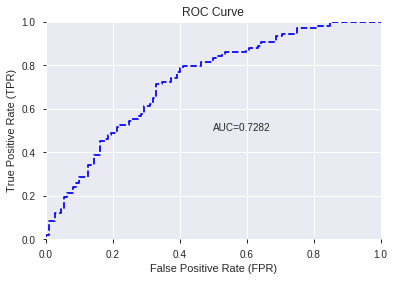

This function is available for GLM models only


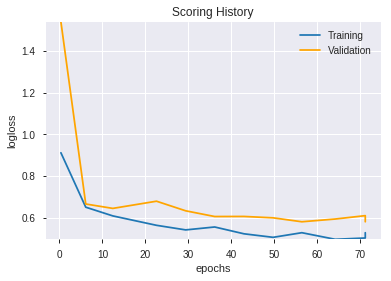

--2019-08-28 16:56:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


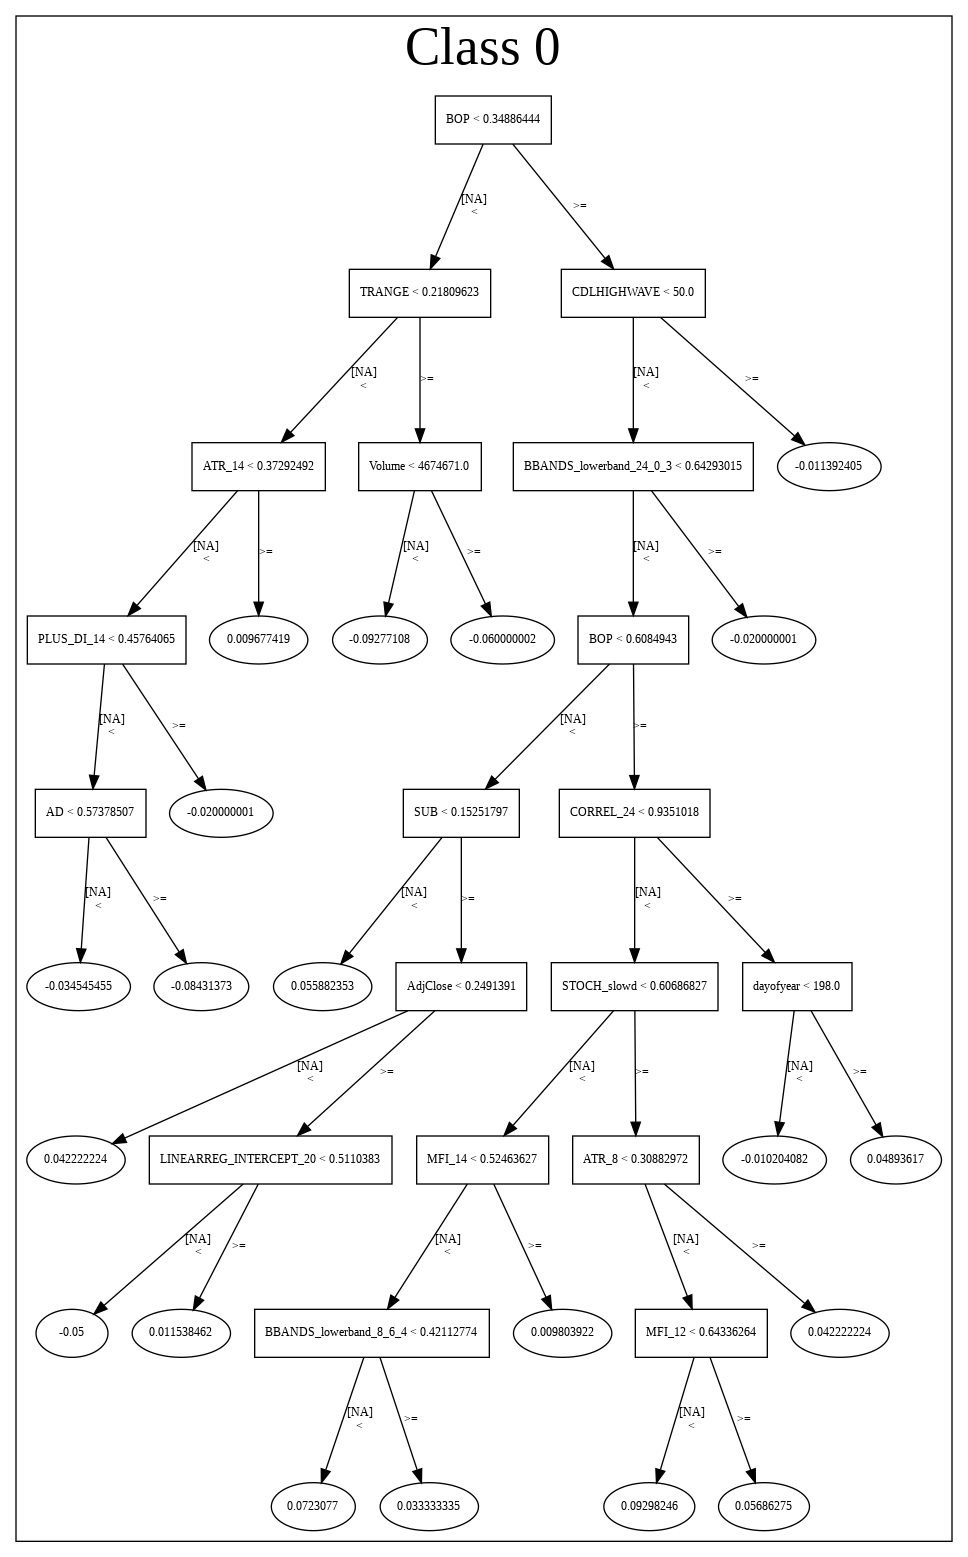

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_162628_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_162628_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8492',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_165631_model_5  0.738261  0.654314              0.315146  0.461435  0.212922
1  DeepLearning_grid_1_AutoML_20190828_165631_model_8  0.730572  0.608179              0.327877  0.458850  0.210543
2  DeepLearning_grid_1_AutoML_20190828_165631_model_6  0.724372  0.663398              0.357970  0.466249  0.217388
3  DeepLearning_grid_1_AutoML_20190828_165631_model_2  0.721892  0.728787              0.384755  0.479710  0.230121
4  DeepLearning_grid_1_AutoML_20190828_165631_model_7  0.721230  0.699499              0.371032  0.485941  0.236139
5  DeepLearning_grid_1_AutoML_20190828_165631_model_9  0.719411  0.621552              0.328704  0.465122  0.216338
6               DeepLearning_1_AutoML_20190828_165631  0.704448  0.774981              0.380456  0.490168  0.240264
7  DeepLearning_grid_1_AutoML_20190828_165631_model_3  0.697834  0.840159              0.340443  0.491550  0.241621
8  DeepLearning_grid_1_AutoML_20190828_165631_model_1  0.690435  1.064094              0.340774  0.521278  0.271731
9  DeepLearning_grid_1_AutoML_20190828_165631_model_4  0.686756  1.040289              0.371032  0.540111  0.291720

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.033504
1   CDLCLOSINGMARUBOZU             0.877137           0.877137    0.029388
2                  DIV             0.698439           0.698439    0.023401
3              ADXR_12             0.686667           0.686667    0.023006
4               TRANGE             0.679430           0.679430    0.022764
5                 hour             0.677040           0.677040    0.022684
6                  SUB             0.666424           0.666424    0.022328
7         HT_TRENDMODE             0.648368           0.648368    0.021723
8          CDLLONGLINE             0.639113           0.639113    0.021413
9        CDLHANGINGMAN             0.636782           0.636782    0.021335
10      STOCHRSI_fastd             0.630116           0.630116    0.021112
11             quarter             0.628748           0.628748    0.021066
12             weekday             0.628206           0.628206    0.021048
13              ULTOSC             0.628015           0.628015    0.021041
14        weekday_name             0.621600           0.621600    0.020826
15        STOCHF_fastk             0.616447           0.616447    0.020654
16              MFI_14             0.612829           0.612829    0.020532
17              BETA_8             0.611067           0.611067    0.020473
18          aroonup_20             0.606516           0.606516    0.020321
19           CORREL_14             0.598935           0.598935    0.020067
20               DX_30             0.594889           0.594889    0.019931
21           aroonup_8             0.594281           0.594281    0.019911
22         CDLMARUBOZU             0.584929           0.584929    0.019598
23      CDLSPINNINGTOP             0.578777           0.578777    0.019392
24      STOCHRSI_fastk             0.578705           0.578705    0.019389
25           CORREL_12             0.578006           0.578006    0.019366
26         CDLHIGHWAVE             0.577380           0.577380    0.019345
27         STOCH_slowd             0.576623           0.576623    0.019319
28           CDLHAMMER             0.570409           0.570409    0.019111
29              Volume             0.567022           0.567022    0.018998
30   CDLGRAVESTONEDOJI             0.566856           0.566856    0.018992
31           CDLTAKURI             0.566426           0.566426    0.018978
32          AROONOSC_8             0.549678           0.549678    0.018417
33           CORREL_24             0.548248           0.548248    0.018369
34               ADOSC             0.539061           0.539061    0.018061
35            WILLR_12             0.538587           0.538587    0.018045
36        STOCHF_fastd             0.536547           0.536547    0.017977
37        CDLSHORTLINE             0.536006           0.536006    0.017959
38             WILLR_8             0.535446           0.535446    0.017940
39         HT_DCPERIOD             0.535376           0.535376    0.017937
40            WILLR_24             0.531811           0.531811    0.017818
41          CDLHIKKAKE             0.527258           0.527258    0.017665
42            WILLR_14             0.526755           0.526755    0.017649
43    CDLDRAGONFLYDOJI             0.524632           0.524632    0.017577
44               CMO_8             0.523420           0.523420    0.017537
45         STOCH_slowk             0.521227           0.521227    0.017463
46            WILLR_20             0.520734           0.520734    0.017447
47        CDLENGULFING             0.518054           0.518054    0.017357
48         CDLBELTHOLD             0.507667           0.507667    0.017009
49               RSI_8             0.500222           0.500222    0.016760

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_165631_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.16676700956348828
RMSE: 0.40837116642031457
LogLoss: 0.49854134228997043
Mean Per-Class Error: 0.24562926382242134
AUC: 0.8435665071445542
pr_auc: 0.8203471419896183
Gini: 0.6871330142891083
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48166910762909354: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      509  296  0.3677   (296.0/805.0)
1      97   635  0.1325   (97.0/732.0)
Total  606  931  0.2557   (393.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481669     0.76368   225
max f2                       0.309191     0.864806  296
max f0point5                 0.650434     0.756259  141
max accuracy                 0.534473     0.752115  198
max precision                0.998778     1         0
max recall                   0.196152     1         333
max specificity              0.998778     1         0
max absolute_mcc             0.500443     0.513394  217
max min_per_class_accuracy   0.547047     0.746584  191
max mean_per_class_accuracy  0.516612     0.754371  208

Gains/Lift Table: Avg response rate: 47.63 %, avg score: 54.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.996403           2.09973   2.09973            1                0.997875   1                           0.997875            0.0218579       0.0218579                  109.973   109.973
    2        0.0201692                   0.992946           2.09973   2.09973            1                0.994595   1                           0.996288            0.0204918       0.0423497                  109.973   109.973
    3        0.0305791                   0.988425           1.96849   2.05505            0.9375           0.991005   0.978723                    0.99449             0.0204918       0.0628415                  96.8494   105.505
    4        0.0403383                   0.980696           1.95974   2.03199            0.933333         0.985178   0.967742                    0.992237            0.0191257       0.0819672                  95.9745   103.199
    5        0.0500976                   0.975766           1.95974   2.01792            0.933333         0.978323   0.961039                    0.989526            0.0191257       0.101093                   95.9745   101.792
    6        0.100195                    0.912679           1.99065   2.00428            0.948052         0.948496   0.954545                    0.969011            0.0997268       0.20082                    99.065    100.428
    7        0.150293                    0.847301           1.74523   1.91793            0.831169         0.880348   0.91342                     0.939457            0.0874317       0.288251                   74.5227   91.7932
    8        0.20039                     0.790753           1.74523   1.87476            0.831169         0.814557   0.892857                    0.908232            0.0874317       0.375683                   74.5227   87.4756
    9        0.299935                    0.686888           1.41354   1.72168            0.673203         0.735251   0.819957                    0.850822            0.14071         0.516393                   41.3542   72.1685
    10       0.40013                     0.606844           1.32256   1.62174            0.62987          0.647443   0.772358                    0.799894            0.132514        0.648907                   32.2555   62.174
    11       0.500325                    0.543883           1.13167   1.5236             0.538961         0.571191   0.725618                    0.754094            0.113388        0.762295                   13.1671   52.3599
    12       0.59987                     0.483387           0.988107  1.43474            0.470588         0.514908   0.683297                    0.714403            0.0983607       0.860656                   -1.18933  43.4737
    13       0.700065                    0.411247           0.763537  1.33867            0.363636         0.45016    0.637546                    0.676584            0.0765027       0.937158                   -23.6463  33.8673
    14       0.79961                     0.307837           0.452882  1.2284             0.215686         0.362975   0.585028                    0.637542            0.045082        0.98224                    -54.7118  22.84
    15       0.899805                    0.147556           0.17725   1.11135            0.0844156        0.231885   0.529284                    0.592371            0.0177596       1                          -82.275   11.1352
    16       1                           0.00249079         0         1                  0                0.0703652  0.476252                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1869920672363477
RMSE: 0.4324257939072873
LogLoss: 0.5454113669767613
Mean Per-Class Error: 0.28106268731268735
AUC: 0.7888361638361638
pr_auc: 0.7717309743269727
Gini: 0.5776723276723277
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39730832607067335: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      134  97   0.4199   (97.0/231.0)
1      36   172  0.1731   (36.0/208.0)
Total  170  269  0.303    (133.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397308     0.721174  243
max f2                       0.113252     0.850452  348
max f0point5                 0.529096     0.713542  176
max accuracy                 0.529096     0.722096  176
max precision                0.99908      1         0
max recall                   0.0982394    1         355
max specificity              0.99908      1         0
max absolute_mcc             0.529096     0.441847  176
max min_per_class_accuracy   0.49623      0.709957  197
max mean_per_class_accuracy  0.529096     0.718937  176

Gains/Lift Table: Avg response rate: 47.38 %, avg score: 48.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.996294           2.11058   2.11058            1                0.997685   1                           0.997685            0.0240385       0.0240385                  111.058   111.058
    2        0.0205011                   0.991424           2.11058   2.11058            1                0.994306   1                           0.996183            0.0192308       0.0432692                  111.058   111.058
    3        0.0318907                   0.982534           2.11058   2.11058            1                0.987351   1                           0.993029            0.0240385       0.0673077                  111.058   111.058
    4        0.0410023                   0.972565           2.11058   2.11058            1                0.975632   1                           0.989163            0.0192308       0.0865385                  111.058   111.058
    5        0.0501139                   0.96702            1.58293   2.01464            0.75             0.970647   0.954545                    0.985796            0.0144231       0.100962                   58.2933   101.464
    6        0.100228                    0.890386           1.91871   1.96667            0.909091         0.923655   0.931818                    0.954726            0.0961538       0.197115                   91.8706   96.6674
    7        0.150342                    0.816832           1.72684   1.88673            0.818182         0.85646    0.893939                    0.921971            0.0865385       0.283654                   72.6836   88.6728
    8        0.200456                    0.760919           1.24716   1.72684            0.590909         0.789643   0.818182                    0.888889            0.0625          0.346154                   24.7159   72.6836
    9        0.300683                    0.636013           1.39106   1.61491            0.659091         0.69347    0.765152                    0.823749            0.139423        0.485577                   39.1062   61.4911
    10       0.400911                    0.549883           1.24716   1.52297            0.590909         0.587502   0.721591                    0.764687            0.125           0.610577                   24.7159   52.2973
    11       0.501139                    0.489335           1.15122   1.44862            0.545455         0.515691   0.686364                    0.714888            0.115385        0.725962                   15.1224   44.8623
    12       0.599089                    0.410475           0.834414  1.3482             0.395349         0.446055   0.638783                    0.670934            0.0817308       0.807692                   -16.5586  34.8201
    13       0.699317                    0.307276           0.767483  1.26497            0.363636         0.362956   0.599349                    0.626794            0.0769231       0.884615                   -23.2517  26.4971
    14       0.799544                    0.186076           0.671547  1.19058            0.318182         0.247631   0.564103                    0.579264            0.0673077       0.951923                   -32.8453  19.0582
    15       0.899772                    0.0959476          0.479677  1.11139            0.227273         0.140213   0.526582                    0.530357            0.0480769       1                          -52.0323  11.1392
    16       1                           0.00341767         0         1                  0                0.0440348  0.473804                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:59:10  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 16:59:11  57.218 sec        1104 obs/sec      1         1             1537       0.504237         0.726442            -0.0193187     0.8003          0.776151           1.83726          0.308393                         0.505821           0.729726              -0.026238        0.73411           0.722248             2.11058            0.341686
    2019-08-28 16:59:17  1 min  2.637 sec  1941 obs/sec      8         8             12296      0.408371         0.498541            0.331424       0.843567        0.820347           2.09973          0.255693                         0.432426           0.545411              0.249973         0.788836          0.771731             2.11058            0.302961
    2019-08-28 16:59:22  1 min  7.746 sec  2242 obs/sec      16        16            24592      0.386845         0.451172            0.40005        0.87023         0.842684           2.09973          0.234873                         0.436253           0.568651              0.236639         0.789117          0.760648             2.11058            0.298405
    2019-08-28 16:59:27  1 min 13.140 sec  2421 obs/sec      25        25            38425      0.364976         0.404447            0.465966       0.896956        0.854946           2.09973          0.204294                         0.439472           0.612141              0.225331         0.792822          0.772525             2.11058            0.28246
    2019-08-28 16:59:32  1 min 18.408 sec  2532 obs/sec      34        34            52258      0.343793         0.362347            0.526156       0.922602        0.888279           2.09973          0.184776                         0.453399           0.659169              0.175454         0.782051          0.766201             2.11058            0.305239
    2019-08-28 16:59:38  1 min 23.806 sec  2589 obs/sec      43        43            66091      0.327673         0.330972            0.56955        0.93506         0.903814           2.09973          0.166558                         0.465887           0.759759              0.129407         0.777015          0.758859             2.11058            0.29385
    2019-08-28 16:59:43  1 min 29.412 sec  2658 obs/sec      53        53            81461      0.301136         0.290446            0.636447       0.960043        0.920799           2.09973          0.131425                         0.47001            0.736017              0.11393          0.769751          0.747409             2.11058            0.29385
    2019-08-28 16:59:44  1 min 29.923 sec  2656 obs/sec      53        53            81461      0.408371         0.498541            0.331424       0.843567        0.820347           2.09973          0.255693                         0.432426           0.545411              0.249973         0.788836          0.771731             2.11058            0.302961

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.033504302862057786
CDLCLOSINGMARUBOZU  0.8771374225616455     0.8771374225616455   0.029387877857150132
DIV                 0.6984394192695618     0.6984394192695618   0.02340072583400716
ADXR_12             0.6866667866706848     0.6866667866706848   0.02300629198593065
TRANGE              0.6794302463531494     0.6794302463531494   0.022763836747458452
---                 ---                    ---                  ---
STOCH_slowk         0.5212274789810181     0.5212274789810181   0.01746336331580689
WILLR_20            0.5207337737083435     0.5207337737083435   0.017446822064826607
CDLENGULFING        0.5180538296699524     0.5180538296699524   0.017357032408110984
CDLBELTHOLD         0.5076670050621033     0.5076670050621033   0.017009029090674532
RSI_8               0.5002220869064331     0.5002220869064331   0.016759592298003726


See the whole table with table.as_data_frame()


('accuracy', 0.6863636363636364)

('F1', 0.7244094488188976)

('auc', 0.7382605820105821)

('logloss', 0.6543138804874523)

('mean_per_class_error', 0.31101190476190477)

('rmse', 0.46143471529204866)

('mse', 0.21292199647665402)

deeplearning prediction progress: |███████████████████████████████████████| 100%



ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21292199647665402
RMSE: 0.46143471529204866
LogLoss: 0.6543138804874523
Mean Per-Class Error: 0.31101190476190477
AUC: 0.7382605820105821
pr_auc: 0.6721023868550805
Gini: 0.4765211640211642
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4425196127690984: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      58   54   0.4821   (54.0/112.0)
1      16   92   0.1481   (16.0/108.0)
Total  74   146  0.3182   (70.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44252      0.724409  145
max f2                       0.167133     0.858506  196
max f0point5                 0.532948     0.679348  110
max accuracy                 0.532948     0.686364  110
max precision                0.999334     1         0
max recall                   0.167133     1         196
max specificity              0.999334     1         0
max absolute_mcc             0.461679     0.393878  140
max min_per_class_accuracy   0.54068      0.678571  109
max mean_per_class_accuracy  0.461679     0.688988  140

Gains/Lift Table: Avg response rate: 49.09 %, avg score: 54.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.997206           1.35802   1.35802            0.666667         0.998407   0.666667                    0.998407            0.0185185       0.0185185                  35.8025   35.8025
    2        0.0227273                   0.995092           2.03704   1.62963            1                0.995918   0.8                         0.997411            0.0185185       0.037037                   103.704   62.963
    3        0.0318182                   0.991454           2.03704   1.74603            1                0.993952   0.857143                    0.996423            0.0185185       0.0555556                  103.704   74.6032
    4        0.0409091                   0.975781           1.01852   1.58436            0.5              0.984858   0.777778                    0.993853            0.00925926      0.0648148                  1.85185   58.4362
    5        0.05                        0.971169           1.01852   1.48148            0.5              0.973514   0.727273                    0.990155            0.00925926      0.0740741                  1.85185   48.1481
    6        0.1                         0.935135           1.48148   1.48148            0.727273         0.954489   0.727273                    0.972322            0.0740741       0.148148                   48.1481   48.1481
    7        0.15                        0.856197           1.48148   1.48148            0.727273         0.902401   0.727273                    0.949015            0.0740741       0.222222                   48.1481   48.1481
    8        0.2                         0.800006           1.66667   1.52778            0.818182         0.824947   0.75                        0.917998            0.0833333       0.305556                   66.6667   52.7778
    9        0.3                         0.688981           1.2037    1.41975            0.590909         0.73672    0.69697                     0.857572            0.12037         0.425926                   20.3704   41.9753
    10       0.4                         0.58872            1.38889   1.41204            0.681818         0.646972   0.693182                    0.804922            0.138889        0.564815                   38.8889   41.2037
    11       0.5                         0.536814           1.2037    1.37037            0.590909         0.561672   0.672727                    0.756272            0.12037         0.685185                   20.3704   37.037
    12       0.6                         0.475547           1.01852   1.31173            0.5              0.50333    0.643939                    0.714115            0.101852        0.787037                   1.85185   31.1728
    13       0.7                         0.413021           0.833333  1.24339            0.409091         0.449168   0.61039                     0.676265            0.0833333       0.87037                    -16.6667  24.3386
    14       0.8                         0.296285           0.555556  1.15741            0.272727         0.365133   0.568182                    0.637374            0.0555556       0.925926                   -44.4444  15.7407
    15       0.9                         0.165196           0.740741  1.11111            0.363636         0.224615   0.545455                    0.591512            0.0740741       1                          -25.9259  11.1111
    16       1                           0.00779608         0         1                  0                0.0779998  0.490909                    0

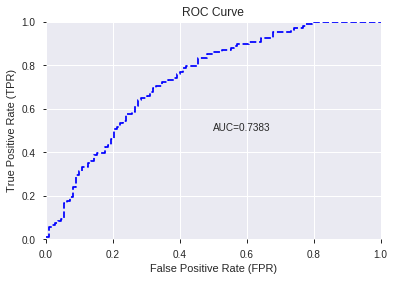

This function is available for GLM models only


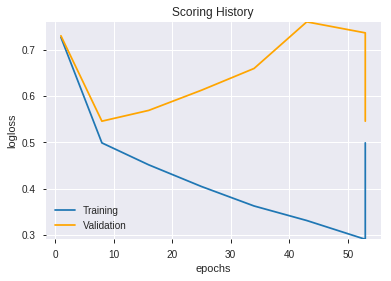

--2019-08-28 17:03:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


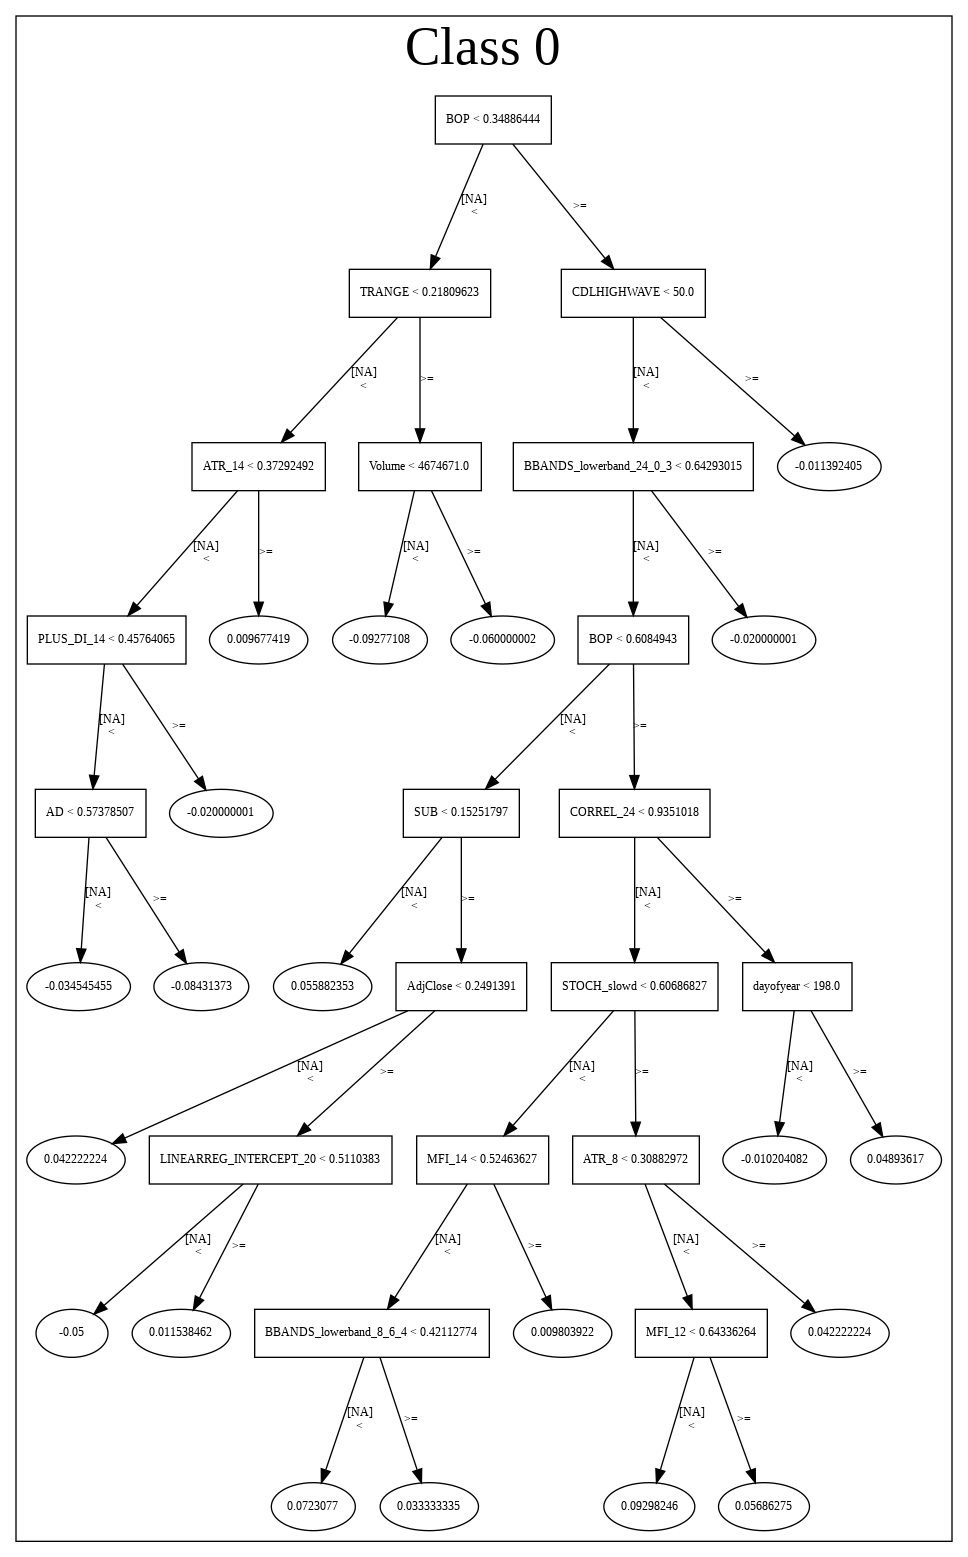

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_165631_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_165631_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8492',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'ADXR_12',
 'TRANGE',
 'hour',
 'SUB',
 'HT_TRENDMODE',
 'CDLLONGLINE',
 'CDLHANGINGMAN',
 'STOCHRSI_fastd',
 'quarter',
 'weekday',
 'ULTOSC',
 'weekday_name',
 'STOCHF_fastk',
 'MFI_14',
 'BETA_8',
 'aroonup_20',
 'CORREL_14',
 'DX_30',
 'aroonup_8',
 'CDLMARUBOZU',
 'CDLSPINNINGTOP',
 'STOCHRSI_fastk',
 'CORREL_12',
 'CDLHIGHWAVE',
 'STOCH_slowd',
 'CDLHAMMER',
 'Volume',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'AROONOSC_8',
 'CORREL_24',
 'ADOSC',
 'WILLR_12',
 'STOCHF_fastd',
 'CDLSHORTLINE',
 'WILLR_8',
 'HT_DCPERIOD',
 'WILLR_24',
 'CDLHIKKAKE',
 'WILLR_14',
 'CDLDRAGONFLYDOJI',
 'CMO_8',
 'STOCH_slowk',
 'WILLR_20',
 'CDLENGULFING',
 'CDLBELTHOLD',
 'RSI_8']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190828_170336_model_1  0.727431  0.648043              0.318287  0.46692  0.218014

variable  relative_importance  scaled_importance  percentage
0                  SUB             0.909812           1.000000    0.086147
1                  BOP             0.884802           0.972511    0.083779
2         STOCHF_fastk             0.595286           0.654296    0.056366
3         STOCHF_fastd             0.511014           0.561670    0.048386
4     CDLDRAGONFLYDOJI             0.486954           0.535225    0.046108
5          STOCH_slowk             0.479206           0.526709    0.045374
6               ULTOSC             0.471809           0.518578    0.044674
7   CDLCLOSINGMARUBOZU             0.419051           0.460591    0.039678
8       STOCHRSI_fastd             0.387290           0.425682    0.036671
9       STOCHRSI_fastk             0.370946           0.407718    0.035124
10                 DIV             0.322806           0.354806    0.030565
11          aroonup_20             0.317673           0.349164    0.030079
12          AROONOSC_8             0.303747           0.333857    0.028761
13            WILLR_14             0.288862           0.317497    0.027351
14           CDLTAKURI             0.286165           0.314532    0.027096
15           CDLHAMMER             0.277342           0.304835    0.026261
16       CDLHANGINGMAN             0.262351           0.288358    0.024841
17            WILLR_24             0.213664           0.234844    0.020231
18                hour             0.205407           0.225768    0.019449
19         CDLBELTHOLD             0.201297           0.221251    0.019060
20               DX_30             0.177498           0.195093    0.016807
21          CDLHIKKAKE             0.173296           0.190474    0.016409
22              TRANGE             0.161367           0.177363    0.015279
23           CORREL_14             0.139486           0.153313    0.013207
24             ADXR_12             0.139036           0.152818    0.013165
25             WILLR_8             0.132369           0.145490    0.012534
26           CORREL_24             0.122253           0.134372    0.011576
27   CDLGRAVESTONEDOJI             0.104637           0.115009    0.009908
28        CDLSHORTLINE             0.103090           0.113309    0.009761
29         CDLMARUBOZU             0.096411           0.105968    0.009129
30              BETA_8             0.086774           0.095376    0.008216
31              MFI_14             0.084402           0.092769    0.007992
32         CDLLONGLINE             0.081952           0.090076    0.007760
33         CDLHIGHWAVE             0.079254           0.087111    0.007504
34         HT_DCPERIOD             0.073663           0.080966    0.006975
35               CMO_8             0.069113           0.075964    0.006544
36               ADOSC             0.066828           0.073453    0.006328
37              Volume             0.061609           0.067716    0.005834
38               RSI_8             0.055914           0.061456    0.005294
39           CORREL_12             0.055491           0.060992    0.005254
40             weekday             0.054734           0.060159    0.005183
41            WILLR_20             0.053043           0.058301    0.005022
42             quarter             0.047595           0.052313    0.004507
43            WILLR_12             0.040885           0.044938    0.003871
44        weekday_name             0.034585           0.038013    0.003275
45         STOCH_slowd             0.017207           0.018913    0.001629
46        HT_TRENDMODE             0.016748           0.018409    0.001586
47           aroonup_8             0.013355           0.014679    0.001265
48        CDLENGULFING             0.013019           0.014309    0.001233
49      CDLSPINNINGTOP             0.010074           0.011073    0.000954

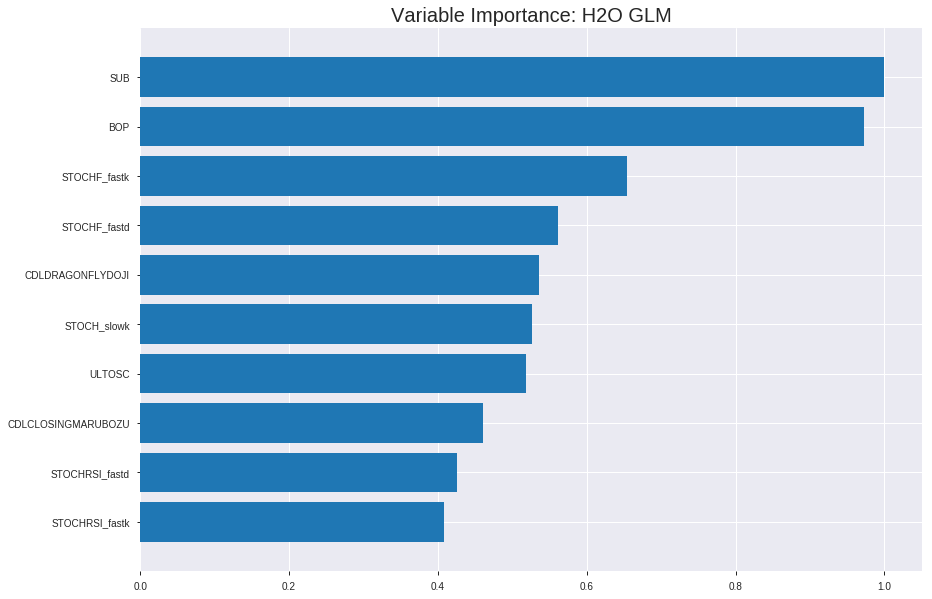

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_170336_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.16910915808249305
RMSE: 0.4112288390695539
LogLoss: 0.5055700810671874
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2127.2659845544013
Residual deviance: 1554.1224292005338
AIC: 1656.1224292005338
AUC: 0.8281726232902284
pr_auc: 0.8010668602561984
Gini: 0.6563452465804569
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36347048147005734: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      497  308  0.3826   (308.0/805.0)
1      105  627  0.1434   (105.0/732.0)
Total  602  935  0.2687   (413.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36347      0.75225   251
max f2                       0.180176     0.856254  325
max f0point5                 0.552397     0.744332  174
max accuracy                 0.486592     0.752765  200
max precision                0.989228     1         0
max recall                   0.0560102    1         372
max specificity              0.989228     1         0
max absolute_mcc             0.486592     0.505395  200
max min_per_class_accuracy   0.492587     0.750311  198
max mean_per_class_accuracy  0.486592     0.752949  200

Gains/Lift Table: Avg response rate: 47.63 %, avg score: 47.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.97845            1.96849    1.96849            0.9375           0.984026   0.9375                      0.984026            0.0204918       0.0204918                  96.8494   96.8494
    2        0.0201692                   0.965466           2.09973    2.03199            1                0.970887   0.967742                    0.977668            0.0204918       0.0409836                  109.973   103.199
    3        0.0305791                   0.959361           1.83726    1.9657             0.875            0.961962   0.93617                     0.972322            0.0191257       0.0601093                  83.7261   96.5702
    4        0.0403383                   0.951385           1.81976    1.93039            0.866667         0.955325   0.919355                    0.968209            0.0177596       0.0778689                  81.9763   93.0394
    5        0.0500976                   0.940754           1.95974    1.93611            0.933333         0.946125   0.922078                    0.963907            0.0191257       0.0969945                  95.9745   93.6112
    6        0.100195                    0.881507           1.93611    1.93611            0.922078         0.915418   0.922078                    0.939663            0.0969945       0.193989                   93.6112   93.6112
    7        0.150293                    0.808122           1.7725     1.88157            0.844156         0.842413   0.896104                    0.907246            0.0887978       0.282787                   77.2497   88.1573
    8        0.20039                     0.756049           1.55434    1.79977            0.74026          0.781217   0.857143                    0.875739            0.0778689       0.360656                   55.4343   79.9766
    9        0.299935                    0.661469           1.52333    1.70802            0.72549          0.70787    0.813449                    0.820025            0.151639        0.512295                   52.3331   70.8021
    10       0.40013                     0.570108           1.29529    1.60467            0.616883         0.616889   0.764228                    0.769159            0.129781        0.642077                   29.5286   60.4669
    11       0.500325                    0.474967           1.18621    1.52087            0.564935         0.526345   0.724317                    0.720533            0.118852        0.760929                   18.6209   52.0868
    12       0.59987                     0.37068            0.878317   1.41424            0.418301         0.426205   0.673536                    0.671691            0.0874317       0.848361                   -12.1683  41.4241
    13       0.700065                    0.278137           0.695364   1.31135            0.331169         0.323084   0.624535                    0.621797            0.0696721       0.918033                   -30.4636  31.1354
    14       0.79961                     0.19148            0.521501   1.21302            0.248366         0.232298   0.577705                    0.573308            0.0519126       0.969945                   -47.8499  21.3024
    15       0.899805                    0.0834099          0.259057   1.1068             0.123377         0.139022   0.527115                    0.524949            0.0259563       0.995902                   -74.0943  10.6797
    16       1                           0.000804772        0.0409038  1                  0.0194805        0.0389274  0.476252 



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19184777699079486
RMSE: 0.438004311612106
LogLoss: 0.558816735485613
Null degrees of freedom: 438
Residual degrees of freedom: 388
Null deviance: 607.3882128516068
Residual deviance: 490.6410937563682
AIC: 592.6410937563683
AUC: 0.7801053113553114
pr_auc: 0.759767256861327
Gini: 0.5602106227106227
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3305908864550004: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      132  99   0.4286   (99.0/231.0)
1      35   173  0.1683   (35.0/208.0)
Total  167  272  0.3052   (134.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330591     0.720833  249
max f2                       0.0822443    0.842105  366
max f0point5                 0.481894     0.703125  186
max accuracy                 0.481894     0.71754   186
max precision                0.995531     1         0
max recall                   0.0822443    1         366
max specificity              0.995531     1         0
max absolute_mcc             0.449426     0.436304  202
max min_per_class_accuracy   0.462388     0.711538  195
max mean_per_class_accuracy  0.449426     0.718438  202

Gains/Lift Table: Avg response rate: 47.38 %, avg score: 46.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.974335           2.11058   2.11058            1                0.986956   1                           0.986956            0.0240385       0.0240385                  111.058   111.058
    2        0.0205011                   0.955228           2.11058   2.11058            1                0.965085   1                           0.977236            0.0192308       0.0432692                  111.058   111.058
    3        0.0318907                   0.946974           2.11058   2.11058            1                0.950603   1                           0.967724            0.0240385       0.0673077                  111.058   111.058
    4        0.0410023                   0.935148           1.58293   1.99332            0.75             0.940561   0.944444                    0.961688            0.0144231       0.0817308                  58.2933   99.3323
    5        0.0501139                   0.929641           2.11058   2.01464            1                0.930835   0.954545                    0.956078            0.0192308       0.100962                   111.058   101.464
    6        0.100228                    0.843748           1.91871   1.96667            0.909091         0.888865   0.931818                    0.922472            0.0961538       0.197115                   91.8706   96.6674
    7        0.150342                    0.789161           1.43903   1.79079            0.681818         0.813306   0.848485                    0.886083            0.0721154       0.269231                   43.903    79.0793
    8        0.200456                    0.741972           1.72684   1.7748             0.818182         0.771885   0.840909                    0.857534            0.0865385       0.355769                   72.6836   77.4803
    9        0.300683                    0.643589           1.24716   1.59892            0.590909         0.689792   0.757576                    0.80162             0.125           0.480769                   24.7159   59.8922
    10       0.400911                    0.550237           1.10326   1.47501            0.522727         0.597762   0.698864                    0.750655            0.110577        0.591346                   10.3256   47.5005
    11       0.501139                    0.452055           1.34309   1.44862            0.636364         0.496709   0.686364                    0.699866            0.134615        0.725962                   34.3094   44.8623
    12       0.599089                    0.345228           0.785331  1.34018            0.372093         0.40116    0.634981                    0.651028            0.0769231       0.802885                   -21.4669  34.0176
    13       0.699317                    0.24763            0.81545   1.26497            0.386364         0.294853   0.599349                    0.59998             0.0817308       0.884615                   -18.455   26.4971
    14       0.799544                    0.180833           0.575612  1.17856            0.272727         0.212031   0.558405                    0.551349            0.0576923       0.942308                   -42.4388  17.8556
    15       0.899772                    0.104494           0.383741  1.09002            0.181818         0.14298    0.516456                    0.505859            0.0384615       0.980769                   -61.6259  9.00195
    16       1                           0.00368177         0.191871  1                  0.0909091        0.0484659  0.473804                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 17:03:36  0.000 sec   2            .23E2     51            1.3599543810529564  1.3632146593674597
     2019-08-28 17:03:36  0.011 sec   4            .14E2     51            1.3476484227442609  1.3528752676042324
     2019-08-28 17:03:36  0.023 sec   6            .89E1     51            1.3305420570235107  1.3385773008344917
     2019-08-28 17:03:36  0.035 sec   8            .55E1     51            1.3079772712676947  1.3198413668432707
     2019-08-28 17:03:36  0.047 sec   10           .34E1     51            1.2798550225611127  1.2967023887811522
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 17:03:37  0.272 sec   46           .25E-3    51            1.011230117882321   1.1179189039854678
     2019-08-28 17:03:37  0.279 sec   47           .16E-3    51            1.0111853845169596  1.1178036094478472
     2019-08-28 17:03:37  0.286 sec   48           .96E-4    51            1.0111609420278578  1.1177196349528387
     2019-08-28 17:03:37  0.293 sec   49           .6E-4     51            1.0111480444359198  1.1176792895080263
     2019-08-28 17:03:37  0.299 sec   50           .37E-4    51            1.0111401621343747  1.117633470971226


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6954545454545454)

('F1', 0.7380073800738006)

('auc', 0.7274305555555556)

('logloss', 0.6480428775985559)

('mean_per_class_error', 0.3029100529100529)

('rmse', 0.46691981661079274)

('mse', 0.21801411514385632)

glm prediction progress: |████████████████████████████████████████████████| 100%


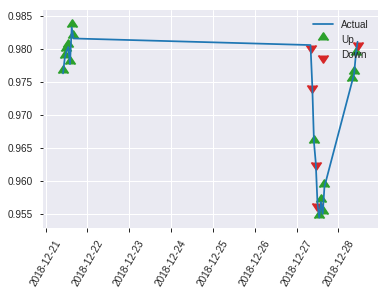


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21801411514385632
RMSE: 0.46691981661079274
LogLoss: 0.6480428775985559
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 305.10134599958155
Residual deviance: 285.13886614336457
AIC: 387.13886614336457
AUC: 0.7274305555555556
pr_auc: 0.6538484426422289
Gini: 0.45486111111111116
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3174237974900482: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   63   0.5625   (63.0/112.0)
1      8    100  0.0741   (8.0/108.0)
Total  57   163  0.3227   (71.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.317424     0.738007  162
max f2                       0.0910004    0.853081  200
max f0point5                 0.534263     0.683453  111
max accuracy                 0.449734     0.695455  128
max precision                0.985666     1         0
max recall                   0.0910004    1         200
max specificity              0.985666     1         0
max absolute_mcc             0.317424     0.414673  162
max min_per_class_accuracy   0.547544     0.678571  109
max mean_per_class_accuracy  0.449734     0.69709   128

Gains/Lift Table: Avg response rate: 49.09 %, avg score: 52.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.981545           1.35802    1.35802            0.666667         0.983889   0.666667                    0.983889            0.0185185       0.0185185                  35.8025   35.8025
    2        0.0227273                   0.971745           1.01852    1.22222            0.5              0.976017   0.6                         0.98074             0.00925926      0.0277778                  1.85185   22.2222
    3        0.0318182                   0.968943           2.03704    1.45503            1                0.969931   0.714286                    0.977652            0.0185185       0.0462963                  103.704   45.5026
    4        0.0409091                   0.965881           1.01852    1.35802            0.5              0.967987   0.666667                    0.975504            0.00925926      0.0555556                  1.85185   35.8025
    5        0.05                        0.957552           2.03704    1.48148            1                0.965135   0.727273                    0.973619            0.0185185       0.0740741                  103.704   48.1481
    6        0.1                         0.917572           1.48148    1.48148            0.727273         0.940884   0.727273                    0.957252            0.0740741       0.148148                   48.1481   48.1481
    7        0.15                        0.860675           1.2963     1.41975            0.636364         0.887031   0.69697                     0.933845            0.0648148       0.212963                   29.6296   41.9753
    8        0.2                         0.8119             1.48148    1.43519            0.727273         0.840834   0.704545                    0.910592            0.0740741       0.287037                   48.1481   43.5185
    9        0.3                         0.716694           1.11111    1.32716            0.545455         0.761038   0.651515                    0.860741            0.111111        0.398148                   11.1111   32.716
    10       0.4                         0.638411           1.2963     1.31944            0.636364         0.674251   0.647727                    0.814118            0.12963         0.527778                   29.6296   31.9444
    11       0.5                         0.546049           1.57407    1.37037            0.772727         0.590318   0.672727                    0.769358            0.157407        0.685185                   57.4074   37.037
    12       0.6                         0.441007           1.11111    1.32716            0.545455         0.488908   0.651515                    0.722616            0.111111        0.796296                   11.1111   32.716
    13       0.7                         0.334094           0.833333   1.25661            0.409091         0.390819   0.616883                    0.675217            0.0833333       0.87963                    -16.6667  25.6614
    14       0.8                         0.267427           0.740741   1.19213            0.363636         0.30409    0.585227                    0.628826            0.0740741       0.953704                   -25.9259  19.213
    15       0.9                         0.103923           0.37037    1.10082            0.181818         0.186412   0.540404                    0.579669            0.037037        0.990741                   -62.963   10.0823
    16       1                           0.0176805          0.0925926  1                  0.0454545        0.0532814  0.490909     

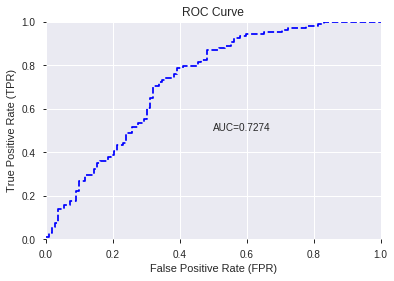

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


'log_likelihood'
--2019-08-28 17:03:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.226.24
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.226.24|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


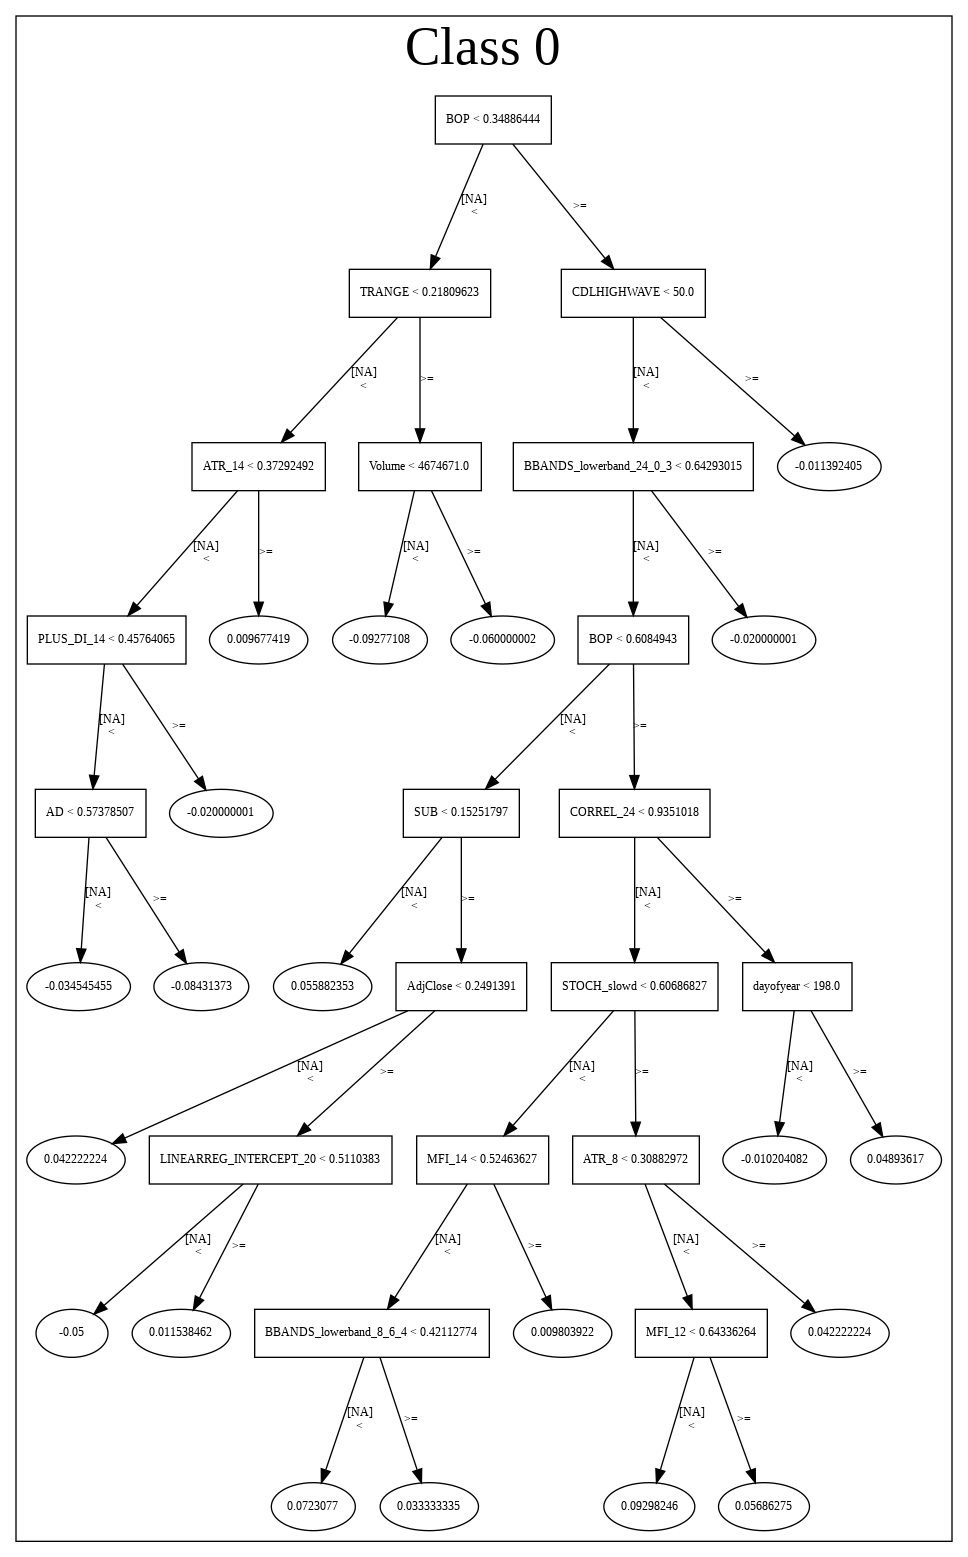

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_170336_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_170336_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8492',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['SUB',
 'BOP',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'CDLDRAGONFLYDOJI',
 'STOCH_slowk',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'DIV',
 'aroonup_20',
 'AROONOSC_8',
 'WILLR_14',
 'CDLTAKURI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'WILLR_24',
 'hour',
 'CDLBELTHOLD',
 'DX_30',
 'CDLHIKKAKE',
 'TRANGE',
 'CORREL_14',
 'ADXR_12',
 'WILLR_8',
 'CORREL_24',
 'CDLGRAVESTONEDOJI',
 'CDLSHORTLINE',
 'CDLMARUBOZU',
 'BETA_8',
 'MFI_14',
 'CDLLONGLINE',
 'CDLHIGHWAVE',
 'HT_DCPERIOD',
 'CMO_8',
 'ADOSC',
 'Volume',
 'RSI_8',
 'CORREL_12',
 'weekday',
 'WILLR_20',
 'quarter',
 'WILLR_12',
 'weekday_name',
 'STOCH_slowd',
 'HT_TRENDMODE',
 'aroonup_8',
 'CDLENGULFING',
 'CDLSPINNINGTOP']

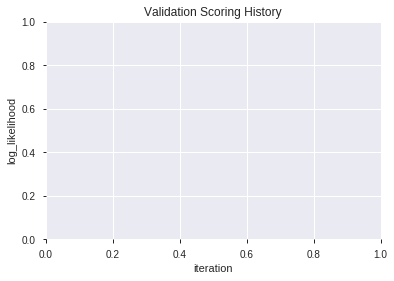

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_170354_model_3  0.728671  0.618886              0.288029  0.461902  0.213353
1               XGBoost_3_AutoML_20190828_170354  0.725777  0.617152              0.306382  0.462038  0.213479
2  XGBoost_grid_1_AutoML_20190828_170354_model_4  0.725446  0.614803              0.324074  0.461974  0.213420
3  XGBoost_grid_1_AutoML_20190828_170354_model_1  0.721974  0.625296              0.310516  0.465236  0.216444
4  XGBoost_grid_1_AutoML_20190828_170354_model_2  0.719329  0.620332              0.323909  0.463656  0.214977
5  XGBoost_grid_1_AutoML_20190828_170354_model_6  0.717427  0.627439              0.315146  0.467218  0.218293
6  XGBoost_grid_1_AutoML_20190828_170354_model_7  0.715278  0.631255              0.362434  0.469049  0.220007
7  XGBoost_grid_1_AutoML_20190828_170354_model_5  0.712880  0.656493              0.328373  0.475348  0.225955
8               XGBoost_2_AutoML_20190828_170354  0.712467  0.630643              0.311177  0.467847  0.218881
9               XGBoost_1_AutoML_20190828_170354  0.709243  0.637633              0.341601  0.471537  0.222347

variable  relative_importance  scaled_importance  percentage
0                  BOP          1833.427612           1.000000    0.233173
1                  DIV           382.609863           0.208686    0.048660
2         STOCHF_fastk           364.071533           0.198574    0.046302
3   CDLCLOSINGMARUBOZU           337.883606           0.184291    0.042972
4              WILLR_8           320.653687           0.174893    0.040780
5               TRANGE           285.761017           0.155862    0.036343
6               BETA_8           244.118912           0.133149    0.031047
7                  SUB           224.538162           0.122469    0.028556
8            aroonup_8           219.254639           0.119587    0.027885
9             WILLR_12           208.018387           0.113459    0.026456
10               ADOSC           185.832672           0.101358    0.023634
11      STOCHRSI_fastd           185.502029           0.101178    0.023592
12              Volume           179.251907           0.097769    0.022797
13      STOCHRSI_fastk           177.944809           0.097056    0.022631
14         STOCH_slowd           166.374802           0.090745    0.021159
15            WILLR_20           163.156326           0.088990    0.020750
16           CORREL_24           156.182983           0.085186    0.019863
17         HT_DCPERIOD           155.275742           0.084692    0.019748
18             ADXR_12           148.193985           0.080829    0.018847
19                hour           141.759705           0.077319    0.018029
20               DX_30           140.719864           0.076752    0.017897
21              ULTOSC           138.551376           0.075570    0.017621
22              MFI_14           133.405624           0.072763    0.016966
23          aroonup_20           132.797180           0.072431    0.016889
24         STOCH_slowk           117.156708           0.063900    0.014900
25               RSI_8           110.693893           0.060375    0.014078
26               CMO_8            99.529236           0.054286    0.012658
27            WILLR_14            98.494743           0.053722    0.012526
28         CDLLONGLINE            94.496872           0.051541    0.012018
29            WILLR_24            86.735764           0.047308    0.011031
30          AROONOSC_8            86.431847           0.047142    0.010992
31           CDLHAMMER            79.250130           0.043225    0.010079
32           CORREL_12            75.041161           0.040929    0.009544
33        STOCHF_fastd            72.102409           0.039327    0.009170
34           CORREL_14            69.968857           0.038163    0.008899
35    CDLDRAGONFLYDOJI            50.528221           0.027559    0.006426
36          CDLHIKKAKE            44.027393           0.024014    0.005599
37             quarter            32.392952           0.017668    0.004120
38             weekday            27.982025           0.015262    0.003559
39        weekday_name            24.811714           0.013533    0.003156
40        CDLSHORTLINE            17.046856           0.009298    0.002168
41         CDLHIGHWAVE            11.675497           0.006368    0.001485
42        HT_TRENDMODE            11.208809           0.006114    0.001426
43           CDLTAKURI            10.346523           0.005643    0.001316
44   CDLGRAVESTONEDOJI             7.053412           0.003847    0.000897
45      CDLSPINNINGTOP             5.871521           0.003202    0.000747
46       CDLHANGINGMAN             3.981699           0.002172    0.000506
47         CDLBELTHOLD             0.833918           0.000455    0.000106

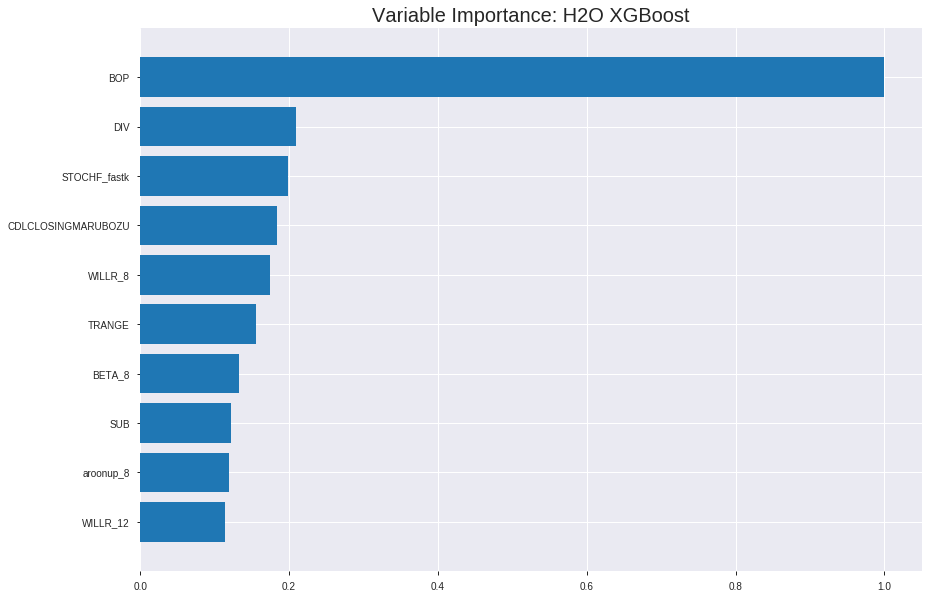

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_170354_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11909909113394453
RMSE: 0.3451073617498539
LogLoss: 0.3911617545779377
Mean Per-Class Error: 0.1411007025761124
AUC: 0.934808064351899
pr_auc: 0.9302607056814274
Gini: 0.869616128703798
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5055427153905233: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      690  115  0.1429   (115.0/805.0)
1      102  630  0.1393   (102.0/732.0)
Total  792  745  0.1412   (217.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.505543     0.853081  194
max f2                       0.348214     0.897469  262
max f0point5                 0.60371      0.875796  155
max accuracy                 0.560628     0.860117  174
max precision                0.964438     1         0
max recall                   0.141203     1         345
max specificity              0.964438     1         0
max absolute_mcc             0.560628     0.720726  174
max min_per_class_accuracy   0.505543     0.857143  194
max mean_per_class_accuracy  0.505543     0.858899  194

Gains/Lift Table: Avg response rate: 47.63 %, avg score: 47.75 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.941266           2.09973    2.09973            1                0.948016   1                           0.948016            0.0218579       0.0218579                  109.973   109.973
    2        0.0201692                   0.931184           2.09973    2.09973            1                0.935901   1                           0.942154            0.0204918       0.0423497                  109.973   109.973
    3        0.0305791                   0.91809            2.09973    2.09973            1                0.923872   1                           0.93593             0.0218579       0.0642077                  109.973   109.973
    4        0.0403383                   0.898133           2.09973    2.09973            1                0.907686   1                           0.929097            0.0204918       0.0846995                  109.973   109.973
    5        0.0500976                   0.879835           2.09973    2.09973            1                0.888575   1                           0.921203            0.0204918       0.105191                   109.973   109.973
    6        0.100195                    0.823294           2.09973    2.09973            1                0.849661   1                           0.885432            0.105191        0.210383                   109.973   109.973
    7        0.150293                    0.782266           2.04519    2.08155            0.974026         0.802003   0.991342                    0.857622            0.102459        0.312842                   104.519   108.155
    8        0.20039                     0.751665           2.04519    2.07246            0.974026         0.766724   0.987013                    0.834898            0.102459        0.415301                   104.519   107.246
    9        0.299935                    0.676835           1.81153    1.98586            0.862745         0.715259   0.94577                     0.795191            0.180328        0.595628                   81.1529   98.5859
    10       0.40013                     0.593412           1.63615    1.89829            0.779221         0.63978    0.904065                    0.756275            0.163934        0.759563                   63.6151   89.829
    11       0.500325                    0.48997            1.13167    1.74477            0.538961         0.542479   0.830949                    0.71346             0.113388        0.872951                   13.1671   74.4766
    12       0.59987                     0.394472           0.590119   1.55316            0.281046         0.444514   0.739696                    0.66883             0.0587432       0.931694                   -40.9881  55.316
    13       0.700065                    0.277886           0.449941   1.39526            0.214286         0.332764   0.664498                    0.620732            0.045082        0.976776                   -55.0059  39.5265
    14       0.79961                     0.173956           0.205856   1.24719            0.0980392        0.224599   0.593979                    0.571417            0.0204918       0.997268                   -79.4144  24.7193
    15       0.899805                    0.102479           0.0272692  1.11135            0.012987         0.137278   0.529284                    0.523074            0.00273224      1                          -97.2731  11.1352
    16       1                           0.0273286          0          1                  0                0.0678782  0.476252   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17846513901215763
RMSE: 0.422451345141849
LogLoss: 0.5289984808363426
Mean Per-Class Error: 0.2584811022311022
AUC: 0.812822594072594
pr_auc: 0.7909965135333006
Gini: 0.6256451881451881
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43782326579093933: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      163  68   0.2944   (68.0/231.0)
1      47   161  0.226    (47.0/208.0)
Total  210  229  0.262    (115.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.437823     0.736842  205
max f2                       0.146804     0.859766  333
max f0point5                 0.536324     0.741525  166
max accuracy                 0.536324     0.744875  166
max precision                0.954372     1         0
max recall                   0.0840527    1         370
max specificity              0.954372     1         0
max absolute_mcc             0.536324     0.488367  166
max min_per_class_accuracy   0.477646     0.730769  191
max mean_per_class_accuracy  0.440584     0.741519  201

Gains/Lift Table: Avg response rate: 47.38 %, avg score: 44.30 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.91942            2.11058    2.11058            1                0.936233   1                           0.936233            0.0240385       0.0240385                  111.058   111.058
    2        0.0205011                   0.906211           2.11058    2.11058            1                0.912358   1                           0.925622            0.0192308       0.0432692                  111.058   111.058
    3        0.0318907                   0.886894           2.11058    2.11058            1                0.893369   1                           0.914103            0.0240385       0.0673077                  111.058   111.058
    4        0.0410023                   0.869959           2.11058    2.11058            1                0.875647   1                           0.905557            0.0192308       0.0865385                  111.058   111.058
    5        0.0501139                   0.849213           2.11058    2.11058            1                0.858529   1                           0.897007            0.0192308       0.105769                   111.058   111.058
    6        0.100228                    0.773308           1.91871    2.01464            0.909091         0.810213   0.954545                    0.85361             0.0961538       0.201923                   91.8706   101.464
    7        0.150342                    0.736438           1.43903    1.82277            0.681818         0.755198   0.863636                    0.820806            0.0721154       0.274038                   43.903    82.2771
    8        0.200456                    0.690986           1.6309     1.7748             0.772727         0.710811   0.840909                    0.793307            0.0817308       0.355769                   63.09     77.4803
    9        0.300683                    0.630666           1.58293    1.71085            0.75             0.657554   0.810606                    0.748056            0.158654        0.514423                   58.2933   71.0846
    10       0.400911                    0.543342           1.24716    1.59492            0.590909         0.583166   0.755682                    0.706834            0.125           0.639423                   24.7159   59.4925
    11       0.501139                    0.452673           1.10326    1.49659            0.522727         0.508374   0.709091                    0.667142            0.110577        0.75                       10.3256   49.6591
    12       0.599089                    0.339177           0.736248   1.37228            0.348837         0.398772   0.65019                     0.623264            0.0721154       0.822115                   -26.3752  37.2276
    13       0.699317                    0.229939           0.767483   1.2856             0.363636         0.288482   0.609121                    0.575282            0.0769231       0.899038                   -23.2517  28.5596
    14       0.799544                    0.165292           0.719515   1.21463            0.340909         0.197652   0.575499                    0.527944            0.0721154       0.971154                   -28.0485  21.4634
    15       0.899772                    0.104893           0.239838   1.10605            0.113636         0.135895   0.524051                    0.484273            0.0240385       0.995192                   -76.0162  10.6049
    16       1                           0.0252927          0.0479677  1                  0.0227273        0.0720097  0.473804 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:04:01  2.368 sec   0                  0.5              0.693147            0.5             0                  1                0.523748                         0.5                0.693147              0.5               0                    1                  0.526196
    2019-08-28 17:04:02  2.482 sec   5                  0.470491         0.635462            0.848823        0.823626           2.09973          0.228367                         0.476105           0.646154              0.790137          0.768247             2.11058            0.318907
    2019-08-28 17:04:02  2.553 sec   10                 0.448041         0.592416            0.858446        0.84449            2.09973          0.247235                         0.459539           0.613759              0.797629          0.782825             2.11058            0.298405
    2019-08-28 17:04:02  2.625 sec   15                 0.428954         0.55576             0.870766        0.856861           2.09973          0.232271                         0.447392           0.589578              0.803519          0.785731             2.11058            0.300683
    2019-08-28 17:04:02  2.698 sec   20                 0.414466         0.527393            0.878819        0.86305            2.09973          0.213403                         0.438158           0.570376              0.806433          0.785508             2.11058            0.291572
    2019-08-28 17:04:02  2.770 sec   25                 0.403985         0.506577            0.886446        0.876728           2.09973          0.19974                          0.433165           0.559278              0.807453          0.785723             2.11058            0.248292
    2019-08-28 17:04:02  2.848 sec   30                 0.395803         0.489678            0.890697        0.880674           2.09973          0.208848                         0.430638           0.55261               0.80533           0.783776             2.11058            0.255125
    2019-08-28 17:04:02  2.928 sec   35                 0.387247         0.472604            0.898202        0.888779           2.09973          0.182824                         0.428527           0.547326              0.805611          0.774336             2.11058            0.257403
    2019-08-28 17:04:02  3.008 sec   40                 0.381099         0.46016             0.903946        0.895505           2.09973          0.176968                         0.427657           0.544063              0.804955          0.777794             2.11058            0.271071
    2019-08-28 17:04:02  3.091 sec   45                 0.374457         0.447054            0.909498        0.899547           2.09973          0.167859                         0.4255             0.538911              0.808837          0.781994             2.11058            0.275626
    2019-08-28 17:04:02  3.169 sec   50                 0.369313         0.436301            0.912218        0.904714           2.09973          0.172414                         0.422995           0.53296               0.81328           0.788963             2.11058            0.273349
    2019-08-28 17:04:02  3.250 sec   55                 0.365138         0.427528            0.915765        0.909161           2.09973          0.162655                         0.422597           0.531407              0.812802          0

Variable Importances: 


variable            relative_importance    scaled_importance       percentage
------------------  ---------------------  ----------------------  ----------------------
BOP                 1833.4276123046875     1.0                     0.23317303847841567
DIV                 382.60986328125        0.2086855574299413      0.048659845512501326
STOCHF_fastk        364.071533203125       0.1985742609960332      0.046302163800051005
CDLCLOSINGMARUBOZU  337.88360595703125     0.18429067157568269     0.04297161585452972
WILLR_8             320.6536865234375      0.17489301697619997     0.04078033617699768
---                 ---                    ---                     ---
CDLTAKURI           10.34652328491211      0.0056432679509534275   0.0013158579350716737
CDLGRAVESTONEDOJI   7.053412437438965      0.0038471180373314874   0.0008970442021497019
CDLSPINNINGTOP      5.87152099609375       0.0032024831286974168   0.0007467327217942398
CDLHANGINGMAN       3.981698513031006      0.002171723871893617    0.0005063874539455443
CDLBELTHOLD         0.8339176177978516     0.00045484076502457914  0.00010605660320462822


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7090909090909091)

('F1', 0.746031746031746)

('auc', 0.728670634920635)

('logloss', 0.6188857672911329)

('mean_per_class_error', 0.28802910052910047)

('rmse', 0.461901856105707)

('mse', 0.21335332467389725)

xgboost prediction progress: |████████████████████████████████████████████| 100%


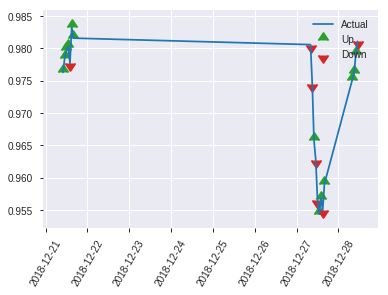


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21335332467389725
RMSE: 0.461901856105707
LogLoss: 0.6188857672911329
Mean Per-Class Error: 0.28802910052910047
AUC: 0.728670634920635
pr_auc: 0.6584745550200674
Gini: 0.45734126984127
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34579575061798096: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   50   0.4464   (50.0/112.0)
1      14   94   0.1296   (14.0/108.0)
Total  76   144  0.2909   (64.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.345796     0.746032  143
max f2                       0.143997     0.845295  194
max f0point5                 0.480584     0.692446  111
max accuracy                 0.347185     0.709091  141
max precision                0.929897     1         0
max recall                   0.0909259    1         206
max specificity              0.929897     1         0
max absolute_mcc             0.345796     0.445696  143
max min_per_class_accuracy   0.484324     0.6875    109
max mean_per_class_accuracy  0.345796     0.711971  143

Gains/Lift Table: Avg response rate: 49.09 %, avg score: 47.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.908933           0.679012  0.679012           0.333333         0.921372   0.333333                    0.921372            0.00925926      0.00925926                 -32.0988  -32.0988
    2        0.0227273                   0.892382           2.03704   1.22222            1                0.899388   0.6                         0.912578            0.0185185       0.0277778                  103.704   22.2222
    3        0.0318182                   0.883664           2.03704   1.45503            1                0.887249   0.714286                    0.905341            0.0185185       0.0462963                  103.704   45.5026
    4        0.0409091                   0.878454           1.01852   1.35802            0.5              0.880894   0.666667                    0.899909            0.00925926      0.0555556                  1.85185   35.8025
    5        0.05                        0.87163            2.03704   1.48148            1                0.877855   0.727273                    0.895899            0.0185185       0.0740741                  103.704   48.1481
    6        0.1                         0.804296           1.2963    1.38889            0.636364         0.832264   0.681818                    0.864082            0.0648148       0.138889                   29.6296   38.8889
    7        0.15                        0.764343           1.85185   1.54321            0.909091         0.786677   0.757576                    0.83828             0.0925926       0.231481                   85.1852   54.321
    8        0.2                         0.724663           1.11111   1.43519            0.545455         0.741495   0.704545                    0.814084            0.0555556       0.287037                   11.1111   43.5185
    9        0.3                         0.630924           1.2963    1.38889            0.636364         0.670865   0.681818                    0.766344            0.12963         0.416667                   29.6296   38.8889
    10       0.4                         0.571806           1.2963    1.36574            0.636364         0.606712   0.670455                    0.726436            0.12963         0.546296                   29.6296   36.5741
    11       0.5                         0.484032           1.48148   1.38889            0.727273         0.527981   0.681818                    0.686745            0.148148        0.694444                   48.1481   38.8889
    12       0.6                         0.394961           0.833333  1.2963             0.409091         0.441172   0.636364                    0.645816            0.0833333       0.777778                   -16.6667  29.6296
    13       0.7                         0.301309           0.925926  1.24339            0.454545         0.347852   0.61039                     0.60325             0.0925926       0.87037                    -7.40741  24.3386
    14       0.8                         0.210624           0.555556  1.15741            0.272727         0.256852   0.568182                    0.55995             0.0555556       0.925926                   -44.4444  15.7407
    15       0.9                         0.128527           0.555556  1.09053            0.272727         0.164351   0.535354                    0.515995            0.0555556       0.981481                   -44.4444  9.0535
    16       1                           0.0517117          0.185185  1                  0.0909091        0.0854312  0.490909                    

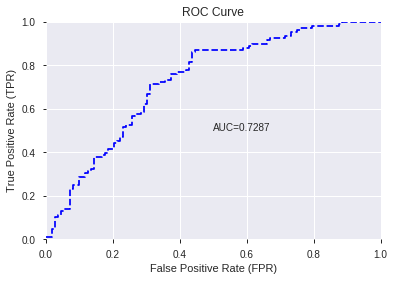

This function is available for GLM models only


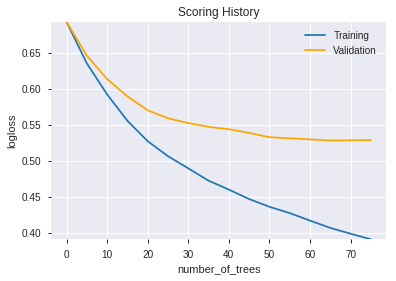

--2019-08-28 17:04:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.49.226
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.49.226|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

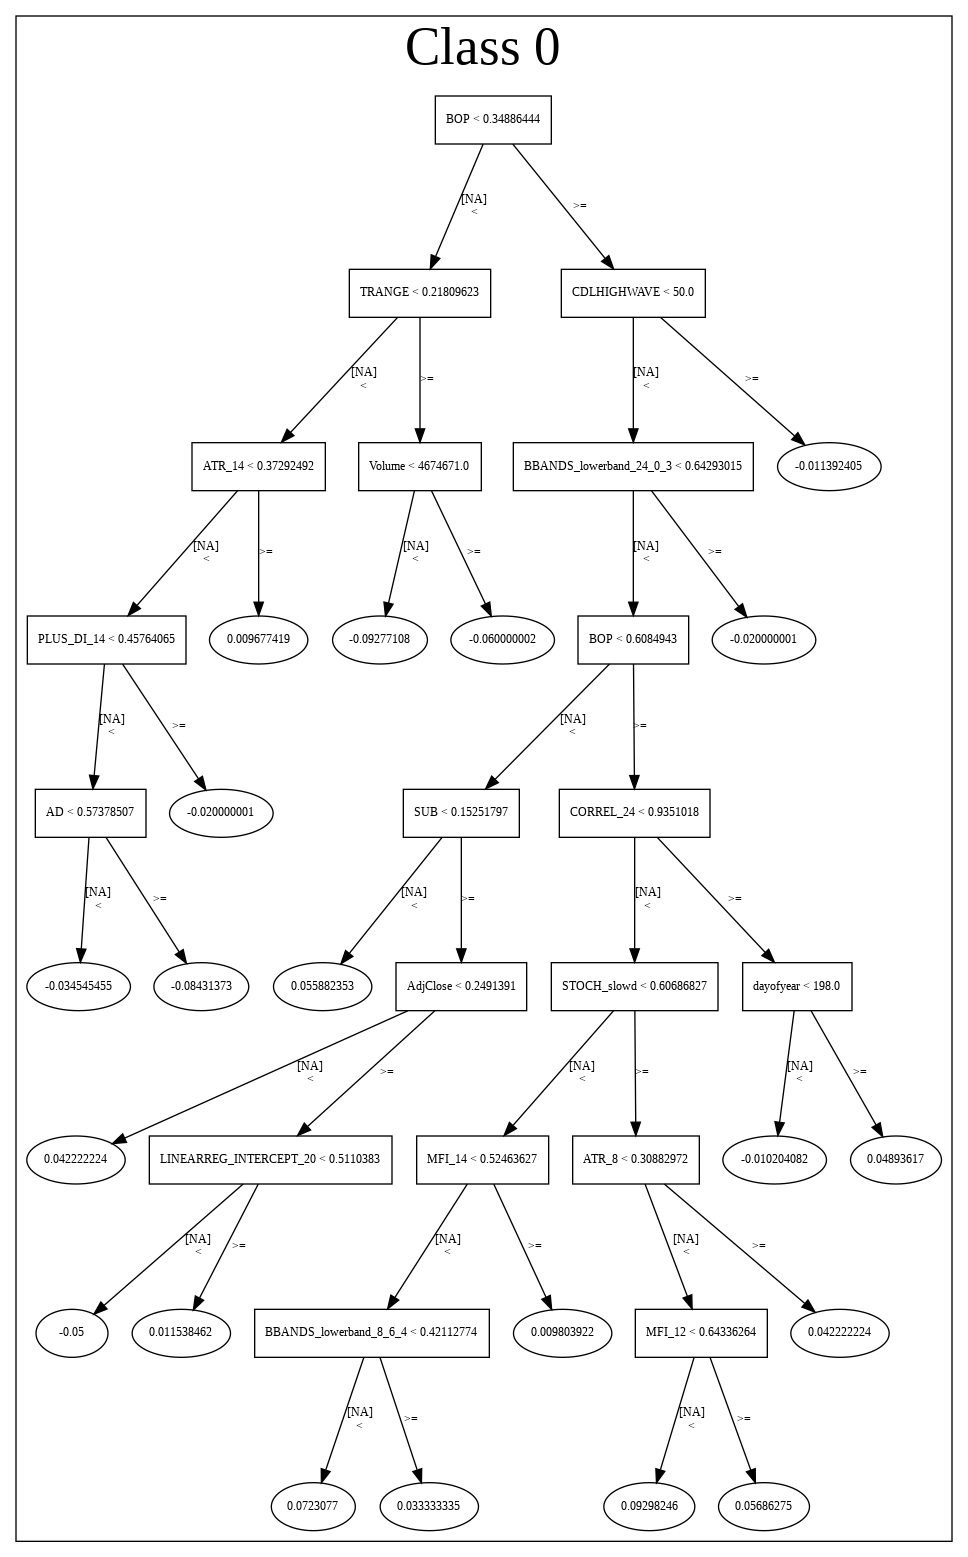

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_170354_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_170354_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8492',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'TRANGE',
 'BETA_8',
 'SUB',
 'aroonup_8',
 'WILLR_12',
 'ADOSC',
 'STOCHRSI_fastd',
 'Volume',
 'STOCHRSI_fastk',
 'STOCH_slowd',
 'WILLR_20',
 'CORREL_24',
 'HT_DCPERIOD',
 'ADXR_12',
 'hour',
 'DX_30',
 'ULTOSC',
 'MFI_14',
 'aroonup_20',
 'STOCH_slowk',
 'RSI_8',
 'CMO_8',
 'WILLR_14',
 'CDLLONGLINE',
 'WILLR_24',
 'AROONOSC_8',
 'CDLHAMMER',
 'CORREL_12',
 'STOCHF_fastd',
 'CORREL_14',
 'CDLDRAGONFLYDOJI',
 'CDLHIKKAKE',
 'quarter',
 'weekday',
 'weekday_name',
 'CDLSHORTLINE',
 'CDLHIGHWAVE',
 'HT_TRENDMODE',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'CDLSPINNINGTOP',
 'CDLHANGINGMAN',
 'CDLBELTHOLD']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_170428_model_1  0.671875  0.677648              0.397817  0.489607  0.239715

variable  relative_importance  scaled_importance    percentage
0                         BOP             0.274178           1.000000  3.642085e-02
1          CDLCLOSINGMARUBOZU             0.184063           0.671326  2.445026e-02
2                 CDLLONGLINE             0.142389           0.519331  1.891449e-02
3                   CDLHAMMER             0.111651           0.407219  1.483128e-02
4                         SUB             0.104330           0.380518  1.385880e-02
...                       ...                  ...                ...           ...
1028  BBANDS_lowerband_20_0_5             0.000023           0.000083  3.017788e-06
1029                   TSF_20             0.000012           0.000045  1.637226e-06
1030  BBANDS_lowerband_20_0_4             0.000008           0.000031  1.121707e-06
1031             LINEARREG_20             0.000004           0.000015  5.415176e-07
1032   BBANDS_upperband_8_4_2             0.000003           0.000011  3.939780e-07

[1033 rows x 4 columns]

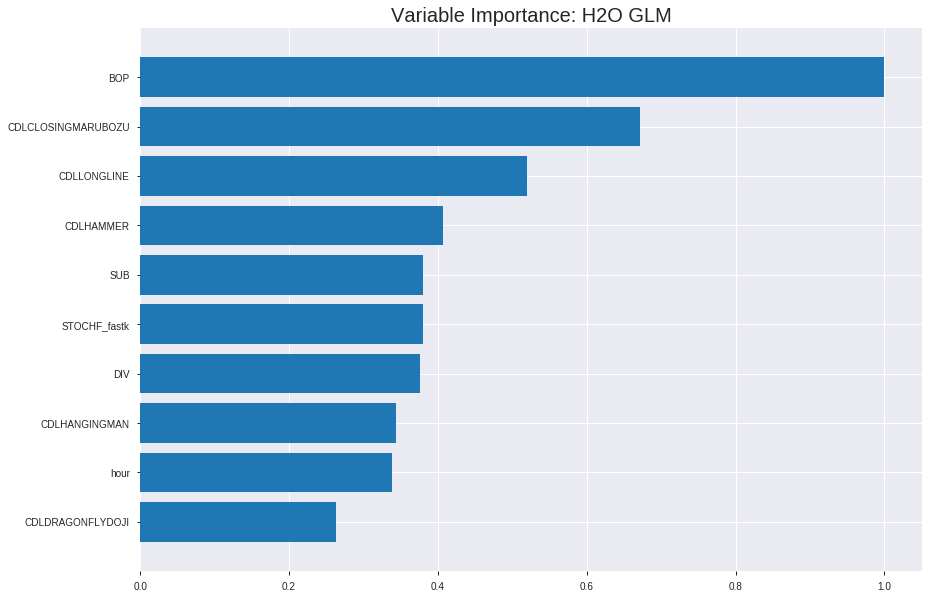

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_170428_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17404347750612412
RMSE: 0.4171851837087747
LogLoss: 0.5244548740235444
Null degrees of freedom: 1536
Residual degrees of freedom: 503
Null deviance: 2127.2659845544013
Residual deviance: 1612.1742827483754
AIC: 3680.1742827483754
AUC: 0.8313613684960799
pr_auc: 0.8079196552585601
Gini: 0.6627227369921598
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3766605653829159: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      450  355   0.441    (355.0/805.0)
1      72   660   0.0984   (72.0/732.0)
Total  522  1015  0.2778   (427.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376661     0.755581  254
max f2                       0.309518     0.852798  290
max f0point5                 0.535398     0.748466  169
max accuracy                 0.503555     0.750163  187
max precision                0.92883      1         0
max recall                   0.0745281    1         388
max specificity              0.92883      1         0
max absolute_mcc             0.492622     0.499397  192
max min_per_class_accuracy   0.486766     0.747826  196
max mean_per_class_accuracy  0.492622     0.749784  192

Gains/Lift Table: Avg response rate: 47.63 %, avg score: 47.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.89023            1.96849    1.96849            0.9375           0.908208  0.9375                      0.908208            0.0204918       0.0204918                  96.8494   96.8494
    2        0.0201692                   0.872756           1.95974    1.96426            0.933333         0.883421  0.935484                    0.896214            0.0191257       0.0396175                  95.9745   96.4261
    3        0.0305791                   0.851421           2.09973    2.01038            1                0.862355  0.957447                    0.884688            0.0218579       0.0614754                  109.973   101.038
    4        0.0403383                   0.834922           1.95974    1.99813            0.933333         0.840659  0.951613                    0.874036            0.0191257       0.0806011                  95.9745   99.8127
    5        0.0500976                   0.823111           1.95974    1.99065            0.933333         0.828003  0.948052                    0.865068            0.0191257       0.0997268                  95.9745   99.065
    6        0.100195                    0.764341           1.93611    1.96338            0.922078         0.791315  0.935065                    0.828192            0.0969945       0.196721                   93.6112   96.3381
    7        0.150293                    0.712947           1.71796    1.88157            0.818182         0.738146  0.896104                    0.798176            0.0860656       0.282787                   71.7958   88.1573
    8        0.20039                     0.668677           1.79977    1.86112            0.857143         0.68877   0.886364                    0.770825            0.0901639       0.372951                   79.9766   86.1121
    9        0.299935                    0.602789           1.45471    1.72624            0.69281          0.634824  0.822126                    0.725688            0.144809        0.51776                    45.4713   72.624
    10       0.40013                     0.54443            1.33619    1.62857            0.636364         0.572102  0.77561                     0.687229            0.13388         0.651639                   33.619    62.8569
    11       0.500325                    0.475845           1.0635     1.51541            0.506494         0.509421  0.721717                    0.651621            0.106557        0.758197                   6.3498    51.5407
    12       0.59987                     0.416875           0.919488   1.41652            0.437908         0.44455   0.67462                     0.617259            0.0915301       0.849727                   -8.05118  41.6518
    13       0.700065                    0.346641           0.777172   1.32501            0.37013          0.382441  0.631041                    0.583651            0.0778689       0.927596                   -22.2828  32.5013
    14       0.79961                     0.283527           0.37054    1.20619            0.176471         0.318003  0.574451                    0.55058             0.0368852       0.964481                   -62.946   20.619
    15       0.899805                    0.18345            0.286326   1.10376            0.136364         0.238892  0.525669                    0.515873            0.0286885       0.993169                   -71.3674  10.3761
    16       1                           0.0196807          0.0681729  1                  0.0324675        0.120438  0.476252                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2041630806425728
RMSE: 0.45184408886536603
LogLoss: 0.5961801163486447
Null degrees of freedom: 438
Residual degrees of freedom: -595
Null deviance: 607.3882128516068
Residual deviance: 523.44614215411
AIC: 2591.44614215411
AUC: 0.7481789044289044
pr_auc: 0.739490390361096
Gini: 0.4963578088578089
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3381991071120128: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      118  113  0.4892   (113.0/231.0)
1      36   172  0.1731   (36.0/208.0)
Total  154  285  0.3394   (149.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.338199     0.697769  255
max f2                       0.0715793    0.826709  388
max f0point5                 0.46721      0.685146  169
max accuracy                 0.416838     0.699317  202
max precision                0.929252     1         0
max recall                   0.0715793    1         388
max specificity              0.929252     1         0
max absolute_mcc             0.416838     0.399805  202
max min_per_class_accuracy   0.429164     0.692308  195
max mean_per_class_accuracy  0.416838     0.700164  202

Gains/Lift Table: Avg response rate: 47.38 %, avg score: 43.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.887951           2.11058   2.11058            1                0.903589   1                           0.903589            0.0240385       0.0240385                  111.058   111.058
    2        0.0205011                   0.865063           2.11058   2.11058            1                0.875376   1                           0.89105             0.0192308       0.0432692                  111.058   111.058
    3        0.0318907                   0.838247           1.68846   1.95982            0.8              0.853637   0.928571                    0.877688            0.0192308       0.0625                     68.8462   95.9821
    4        0.0410023                   0.813728           2.11058   1.99332            1                0.82615    0.944444                    0.866235            0.0192308       0.0817308                  111.058   99.3323
    5        0.0501139                   0.79163            2.11058   2.01464            1                0.800961   0.954545                    0.854367            0.0192308       0.100962                   111.058   101.464
    6        0.100228                    0.731156           1.82277   1.91871            0.863636         0.752844   0.909091                    0.803605            0.0913462       0.192308                   82.2771   91.8706
    7        0.150342                    0.680326           1.6309    1.82277            0.772727         0.70967    0.863636                    0.772294            0.0817308       0.274038                   63.09     82.2771
    8        0.200456                    0.639994           1.43903   1.72684            0.681818         0.656363   0.818182                    0.743311            0.0721154       0.346154                   43.903    72.6836
    9        0.300683                    0.565257           1.19919   1.55095            0.568182         0.609511   0.734848                    0.698711            0.120192        0.466346                   19.9191   55.0954
    10       0.400911                    0.485631           1.24716   1.47501            0.590909         0.527696   0.698864                    0.655957            0.125           0.591346                   24.7159   47.5005
    11       0.501139                    0.419603           1.15122   1.41025            0.545455         0.451241   0.668182                    0.615014            0.115385        0.706731                   15.1224   41.0249
    12       0.599089                    0.363284           0.687165  1.29203            0.325581         0.392686   0.612167                    0.578664            0.0673077       0.774038                   -31.2835  29.2026
    13       0.699317                    0.314895           0.719515  1.20997            0.340909         0.337466   0.57329                     0.544095            0.0721154       0.846154                   -28.0485  20.9972
    14       0.799544                    0.249631           0.671547  1.14248            0.318182         0.282154   0.541311                    0.511259            0.0673077       0.913462                   -32.8453  14.2478
    15       0.899772                    0.150052           0.479677  1.06865            0.227273         0.200638   0.506329                    0.476658            0.0480769       0.961538                   -52.0323  6.86465
    16       1                           0.0154927          0.383741  1                  0.181818         0.0908327  0.473804                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 17:04:32  0.000 sec   2            .23E2     1034          1.3519025480448292  1.3640627675912058
     2019-08-28 17:04:33  1.981 sec   4            .17E2     1034          1.3438296287826181  1.3580391044145848
     2019-08-28 17:04:35  3.983 sec   6            .12E2     1034          1.333891532509228   1.3503430568064587
     2019-08-28 17:04:38  6.023 sec   8            .89E1     1034          1.321712987219893   1.3407457414980566
     2019-08-28 17:04:39  7.993 sec   10           .65E1     1034          1.3069383899345843  1.3289770337349136
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 17:05:04  32.366 sec  34           .14E0     1034          1.0306605801455089  1.1956479987101734
     2019-08-28 17:05:06  34.387 sec  36           .1E0      1034          1.0144050020998683  1.2020756840821745
     2019-08-28 17:05:08  36.476 sec  38           .76E-1    1034          1.0000585090891239  1.21120728913546
     2019-08-28 17:05:10  38.509 sec  40           .55E-1    1034          0.9875090494851245  1.2227570697275387
     2019-08-28 17:05:12  40.550 sec  42           .4E-1     1034          0.9766294626286782  1.2366229933485995


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6272727272727273)

('F1', 0.7023411371237458)

('auc', 0.671875)

('logloss', 0.6776480418535656)

('mean_per_class_error', 0.3726851851851851)

('rmse', 0.48960653291280903)

('mse', 0.23971455707090153)

glm prediction progress: |████████████████████████████████████████████████| 100%


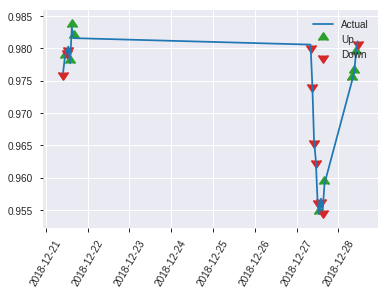


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23971455707090153
RMSE: 0.48960653291280903
LogLoss: 0.6776480418535656
Null degrees of freedom: 219
Residual degrees of freedom: -814
Null deviance: 305.10134599958155
Residual deviance: 298.1651384155689
AIC: 2366.165138415569
AUC: 0.671875
pr_auc: 0.6310987851582835
Gini: 0.34375
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1312684303808379: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      26   86   0.7679   (86.0/112.0)
1      3    105  0.0278   (3.0/108.0)
Total  29   191  0.4045   (89.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.131268     0.702341  190
max f2                       0.131268     0.842697  190
max f0point5                 0.416523     0.620229  103
max accuracy                 0.419986     0.627273  101
max precision                0.946792     1         0
max recall                   0.0608241    1         209
max specificity              0.946792     1         0
max absolute_mcc             0.131268     0.302003  190
max min_per_class_accuracy   0.413166     0.611111  108
max mean_per_class_accuracy  0.240096     0.627315  164

Gains/Lift Table: Avg response rate: 49.09 %, avg score: 42.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.90627            1.35802   1.35802            0.666667         0.931543   0.666667                    0.931543            0.0185185       0.0185185                  35.8025   35.8025
    2        0.0227273                   0.852474           2.03704   1.62963            1                0.859639   0.8                         0.902781            0.0185185       0.037037                   103.704   62.963
    3        0.0318182                   0.836383           1.01852   1.45503            0.5              0.84244    0.714286                    0.885541            0.00925926      0.0462963                  1.85185   45.5026
    4        0.0409091                   0.814462           1.01852   1.35802            0.5              0.82638    0.666667                    0.872394            0.00925926      0.0555556                  1.85185   35.8025
    5        0.05                        0.801387           2.03704   1.48148            1                0.808392   0.727273                    0.860758            0.0185185       0.0740741                  103.704   48.1481
    6        0.1                         0.760145           1.66667   1.57407            0.818182         0.785893   0.772727                    0.823325            0.0833333       0.157407                   66.6667   57.4074
    7        0.15                        0.679855           1.2963    1.48148            0.636364         0.726429   0.727273                    0.791027            0.0648148       0.222222                   29.6296   48.1481
    8        0.2                         0.654844           1.2963    1.43519            0.636364         0.669839   0.704545                    0.76073             0.0648148       0.287037                   29.6296   43.5185
    9        0.3                         0.561982           1.11111   1.32716            0.545455         0.609304   0.651515                    0.710255            0.111111        0.398148                   11.1111   32.716
    10       0.4                         0.470496           1.2037    1.2963             0.590909         0.513755   0.636364                    0.66113             0.12037         0.518519                   20.3704   29.6296
    11       0.5                         0.411294           0.925926  1.22222            0.454545         0.432289   0.6                         0.615361            0.0925926       0.611111                   -7.40741  22.2222
    12       0.6                         0.339764           0.925926  1.17284            0.454545         0.382921   0.575758                    0.576621            0.0925926       0.703704                   -7.40741  17.284
    13       0.7                         0.270138           1.11111   1.16402            0.545455         0.305873   0.571429                    0.537943            0.111111        0.814815                   11.1111   16.4021
    14       0.8                         0.185693           0.833333  1.12269            0.409091         0.229052   0.551136                    0.499332            0.0833333       0.898148                   -16.6667  12.2685
    15       0.9                         0.111789           0.740741  1.08025            0.363636         0.144428   0.530303                    0.459898            0.0740741       0.972222                   -25.9259  8.02469
    16       1                           0.0300106          0.277778  1                  0.136364         0.0675411  0.490909                    0.

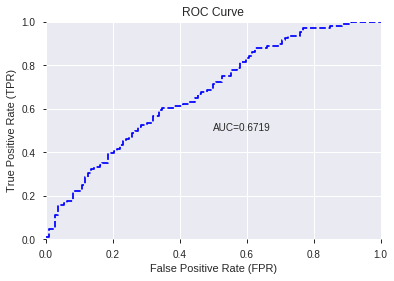

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


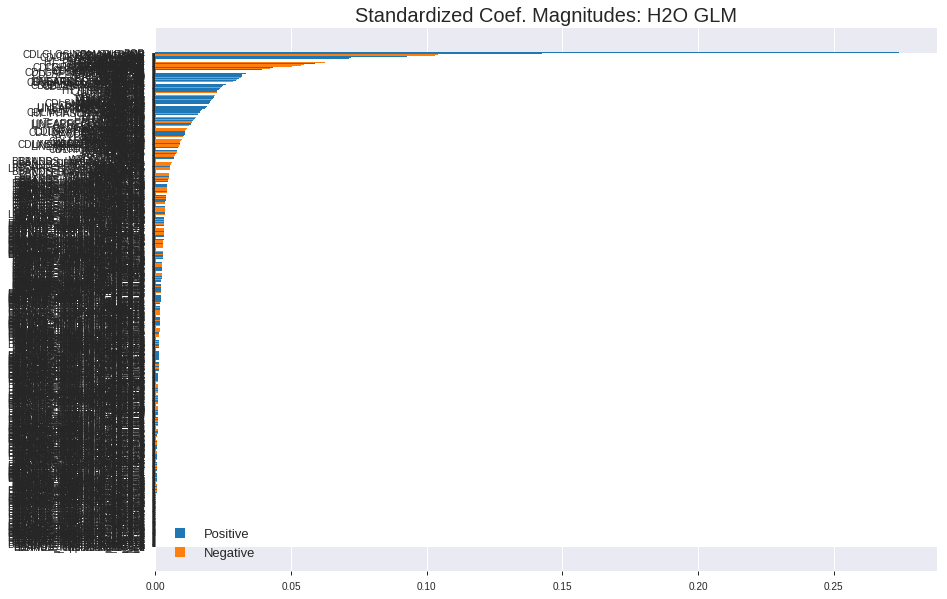

'log_likelihood'
--2019-08-28 17:05:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


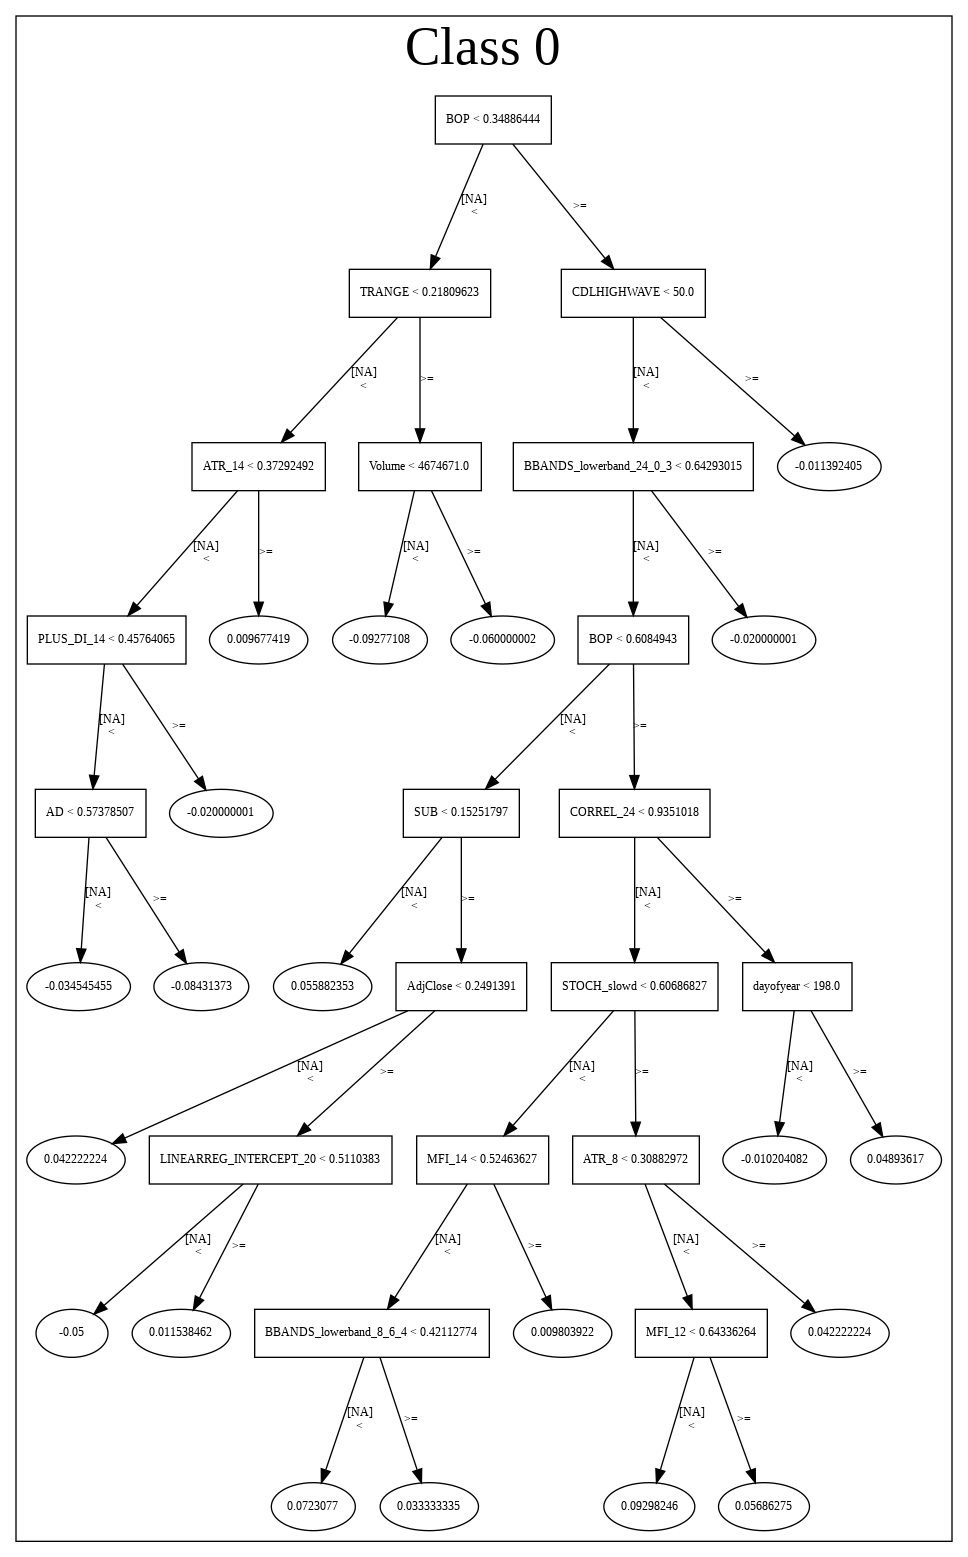

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_170428_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_170428_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8492',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

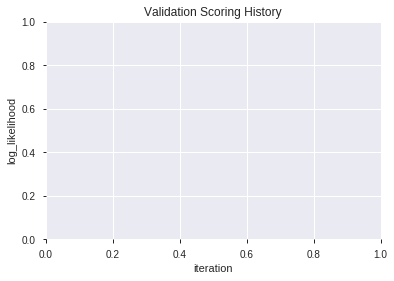

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_170549_model_1  0.730572  0.633521              0.310681  0.466411  0.217539
1  XGBoost_grid_1_AutoML_20190828_170549_model_6  0.728671  0.617997              0.301918  0.462701  0.214092
2  XGBoost_grid_1_AutoML_20190828_170549_model_4  0.727844  0.612459              0.346065  0.460374  0.211944
3  XGBoost_grid_1_AutoML_20190828_170549_model_7  0.725860  0.622215              0.328373  0.463816  0.215125
4  XGBoost_grid_1_AutoML_20190828_170549_model_2  0.722553  0.616429              0.315311  0.462520  0.213924
5  XGBoost_grid_1_AutoML_20190828_170549_model_3  0.722305  0.620642              0.323247  0.464111  0.215399
6  XGBoost_grid_1_AutoML_20190828_170549_model_5  0.720238  0.635320              0.388724  0.471005  0.221846
7               XGBoost_2_AutoML_20190828_170549  0.719163  0.625917              0.350364  0.466618  0.217733
8               XGBoost_1_AutoML_20190828_170549  0.714782  0.627126              0.336971  0.466850  0.217949
9               XGBoost_3_AutoML_20190828_170549  0.711558  0.637794              0.341931  0.470625  0.221488

variable  relative_importance  scaled_importance  percentage
0                        BOP          3539.082520           1.000000    0.361056
1                        DIV           541.670105           0.153054    0.055261
2         CDLCLOSINGMARUBOZU           458.638519           0.129592    0.046790
3               STOCHF_fastk           447.692871           0.126500    0.045674
4                     TRANGE           237.608688           0.067138    0.024241
..                       ...                  ...                ...         ...
216  BBANDS_upperband_24_6_5             1.626789           0.000460    0.000166
217                      APO             0.860916           0.000243    0.000088
218           STOCHRSI_fastk             0.708897           0.000200    0.000072
219  BBANDS_lowerband_30_1_5             0.628405           0.000178    0.000064
220                   CCI_24             0.069260           0.000020    0.000007

[221 rows x 4 columns]

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_170549_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11549764961070018
RMSE: 0.3398494513909066
LogLoss: 0.38144430354614905
Mean Per-Class Error: 0.13626412788921693
AUC: 0.9456521739130435
pr_auc: 0.9389696327462136
Gini: 0.8913043478260869
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46222636103630066: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      640  165  0.205    (165.0/805.0)
1      50   682  0.0683   (50.0/732.0)
Total  690  847  0.1399   (215.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462226     0.863838  219
max f2                       0.396297     0.919184  245
max f0point5                 0.634743     0.870748  145
max accuracy                 0.467513     0.860768  217
max precision                0.963675     1         0
max recall                   0.226829     1         308
max specificity              0.963675     1         0
max absolute_mcc             0.462226     0.729722  219
max min_per_class_accuracy   0.52633      0.853825  193
max mean_per_class_accuracy  0.467513     0.863736  217

Gains/Lift Table: Avg response rate: 47.63 %, avg score: 47.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.945628           2.09973    2.09973            1                0.954595   1                           0.954595            0.0218579       0.0218579                  109.973   109.973
    2        0.0201692                   0.937094           2.09973    2.09973            1                0.942661   1                           0.948821            0.0204918       0.0423497                  109.973   109.973
    3        0.0305791                   0.921864           2.09973    2.09973            1                0.930723   1                           0.94266             0.0218579       0.0642077                  109.973   109.973
    4        0.0403383                   0.904949           2.09973    2.09973            1                0.913716   1                           0.935657            0.0204918       0.0846995                  109.973   109.973
    5        0.0500976                   0.881843           2.09973    2.09973            1                0.891652   1                           0.927085            0.0204918       0.105191                   109.973   109.973
    6        0.100195                    0.807213           2.09973    2.09973            1                0.841032   1                           0.884058            0.105191        0.210383                   109.973   109.973
    7        0.150293                    0.762345           2.09973    2.09973            1                0.783934   1                           0.850684            0.105191        0.315574                   109.973   109.973
    8        0.20039                     0.73325            2.07246    2.09291            0.987013         0.747331   0.996753                    0.824846            0.103825        0.419399                   107.246   109.291
    9        0.299935                    0.671706           1.86642    2.01774            0.888889         0.702431   0.960954                    0.784218            0.185792        0.605191                   86.6424   101.774
    10       0.40013                     0.606275           1.44527    1.87439            0.688312         0.640172   0.892683                    0.748148            0.144809        0.75                       44.5266   87.439
    11       0.500325                    0.510481           1.22711    1.74477            0.584416         0.555029   0.830949                    0.709474            0.122951        0.872951                   22.7113   74.4766
    12       0.59987                     0.411517           0.892041   1.60326            0.424837         0.461611   0.763557                    0.668343            0.0887978       0.961749                   -10.7959  60.3262
    13       0.700065                    0.296532           0.286326   1.41478            0.136364         0.351122   0.673792                    0.622941            0.0286885       0.990437                   -71.3674  41.4779
    14       0.79961                     0.170957           0.0960659  1.25061            0.0457516        0.230833   0.595606                    0.574127            0.00956284      1                          -90.3934  25.061
    15       0.899805                    0.0791157          0          1.11135            0                0.121008   0.529284                    0.523671            0               1                          -100      11.1352
    16       1                           0.0304309          0          1                  0                0.0575159  0.476252   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17885679160095
RMSE: 0.4229146386694956
LogLoss: 0.5316559389089803
Mean Per-Class Error: 0.2498334998334999
AUC: 0.8060897435897436
pr_auc: 0.7819632808926845
Gini: 0.6121794871794872
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43546590209007263: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      160  71   0.3074   (71.0/231.0)
1      40   168  0.1923   (40.0/208.0)
Total  200  239  0.2528   (111.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.435466     0.751678  221
max f2                       0.134528     0.84596   327
max f0point5                 0.558464     0.737448  173
max accuracy                 0.442792     0.747153  219
max precision                0.963671     1         0
max recall                   0.0596782    1         382
max specificity              0.963671     1         0
max absolute_mcc             0.435466     0.501629  221
max min_per_class_accuracy   0.510895     0.730769  197
max mean_per_class_accuracy  0.435466     0.750167  221

Gains/Lift Table: Avg response rate: 47.38 %, avg score: 46.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.938069           2.11058   2.11058            1                0.95188    1                           0.95188             0.0240385       0.0240385                  111.058   111.058
    2        0.0205011                   0.923696           2.11058   2.11058            1                0.931625   1                           0.942878            0.0192308       0.0432692                  111.058   111.058
    3        0.0318907                   0.912698           2.11058   2.11058            1                0.91741    1                           0.933782            0.0240385       0.0673077                  111.058   111.058
    4        0.0410023                   0.894689           2.11058   2.11058            1                0.899228   1                           0.926104            0.0192308       0.0865385                  111.058   111.058
    5        0.0501139                   0.877561           2.11058   2.11058            1                0.883241   1                           0.91831             0.0192308       0.105769                   111.058   111.058
    6        0.100228                    0.809282           1.82277   1.96667            0.863636         0.840748   0.931818                    0.879529            0.0913462       0.197115                   82.2771   96.6674
    7        0.150342                    0.771328           1.43903   1.79079            0.681818         0.787006   0.848485                    0.848688            0.0721154       0.269231                   43.903    79.0793
    8        0.200456                    0.738862           1.43903   1.70285            0.681818         0.752966   0.806818                    0.824757            0.0721154       0.341346                   43.903    70.2852
    9        0.300683                    0.667745           1.487     1.6309             0.704545         0.704494   0.772727                    0.78467             0.149038        0.490385                   48.6997   63.09
    10       0.400911                    0.581272           1.53497   1.60692            0.727273         0.635043   0.761364                    0.747263            0.153846        0.644231                   53.4965   60.6917
    11       0.501139                    0.490784           1.00732   1.487              0.477273         0.535319   0.704545                    0.704874            0.100962        0.745192                   0.73208   48.6997
    12       0.599089                    0.375875           0.883497  1.38833            0.418605         0.433991   0.657795                    0.660585            0.0865385       0.831731                   -11.6503  38.8326
    13       0.699317                    0.256434           0.671547  1.2856             0.318182         0.321207   0.609121                    0.611945            0.0673077       0.899038                   -32.8453  28.5596
    14       0.799544                    0.146149           0.62358   1.20261            0.295455         0.200191   0.569801                    0.560329            0.0625          0.961538                   -37.642   20.2608
    15       0.899772                    0.0768859          0.239838  1.09536            0.113636         0.104275   0.518987                    0.509528            0.0240385       0.985577                   -76.0162  9.53627
    16       1                           0.0313346          0.143903  1                  0.0681818        0.0590524  0.473804                    0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:06:10  0.011 sec   0                  0.5              0.693147            0.5             0                  1                0.523748                         0.5                0.693147              0.5               0                    1                  0.526196
    2019-08-28 17:06:11  1.110 sec   5                  0.463309         0.621789            0.864955        0.813294           2.09973          0.218608                         0.472579           0.639264              0.781531          0.767021             2.11058            0.328018
    2019-08-28 17:06:11  1.318 sec   10                 0.439668         0.576417            0.868074        0.823651           2.09973          0.229668                         0.454994           0.604517              0.785454          0.762188             2.11058            0.277904
    2019-08-28 17:06:11  1.533 sec   15                 0.421672         0.54125             0.877278        0.854853           2.09973          0.227716                         0.444458           0.582591              0.790137          0.77349              2.11058            0.275626
    2019-08-28 17:06:11  1.746 sec   20                 0.407869         0.51355             0.884419        0.867741           2.09973          0.227716                         0.438437           0.568865              0.79458           0.784075             2.11058            0.291572
    2019-08-28 17:06:12  1.954 sec   25                 0.396743         0.490664            0.892115        0.873159           2.09973          0.216005                         0.434039           0.558251              0.795434          0.783546             2.11058            0.291572
    2019-08-28 17:06:12  2.164 sec   30                 0.388165         0.47301             0.898617        0.881314           2.09973          0.195185                         0.43078            0.550486              0.798868          0.784852             2.11058            0.277904
    2019-08-28 17:06:12  2.370 sec   35                 0.380411         0.457304            0.905464        0.892381           2.09973          0.181522                         0.428938           0.545787              0.800959          0.783936             2.11058            0.277904
    2019-08-28 17:06:12  2.596 sec   40                 0.372988         0.442292            0.913533        0.899444           2.09973          0.174366                         0.428326           0.54361               0.800075          0.781605             2.11058            0.271071
    2019-08-28 17:06:13  2.798 sec   45                 0.36657          0.429728            0.920777        0.908524           2.09973          0.163956                         0.426589           0.539549              0.802437          0.785665             2.11058            0.273349
    2019-08-28 17:06:13  3.122 sec   50                 0.359859         0.417163            0.927371        0.919222           2.09973          0.165257                         0.4255             0.537244              0.802968          0.784316             2.11058            0.268793
    2019-08-28 17:06:13  3.319 sec   55                 0.354886         0.407885            0.931892        0.924544           2.09973          0.153546                         0.425236           0.536282              0.802885          0

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      3539.08251953125       1.0                     0.3610564146299563
DIV                      541.6701049804688      0.15305382171541249     0.05526106411397938
CDLCLOSINGMARUBOZU       458.6385192871094      0.12959249092271968     0.04679020013552233
STOCHF_fastk             447.69287109375        0.1264996983322804      0.04567352753162423
TRANGE                   237.6086883544922      0.06713849904408653     0.02424078574849463
---                      ---                    ---                     ---
BBANDS_upperband_24_6_5  1.6267890930175781     0.00045966407509284235  0.00016596466288721666
APO                      0.8609161376953125     0.00024325969596474412  8.783047364900377e-05
STOCHRSI_fastk           0.7088966369628906     0.0002003052014330493   7.232147786114796e-05
BBANDS_lowerband_30_1_5  0.6284046173095703     0.0001775614481554395   6.410969984750587e-05
CCI_24                   0.0692596435546875     1.956994310600616e-05   7.065853492366816e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6863636363636364)

('F1', 0.7272727272727273)

('auc', 0.73057208994709)

('logloss', 0.6335210344222031)

('mean_per_class_error', 0.310681216931217)

('rmse', 0.4664111499948935)

('mse', 0.21753936083955905)

xgboost prediction progress: |████████████████████████████████████████████| 100%


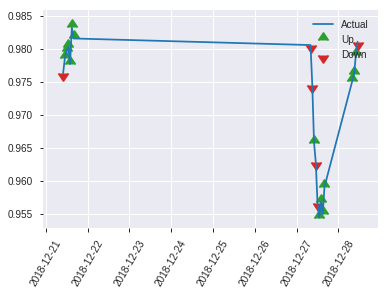


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21753936083955905
RMSE: 0.4664111499948935
LogLoss: 0.6335210344222031
Mean Per-Class Error: 0.310681216931217
AUC: 0.73057208994709
pr_auc: 0.676562332611005
Gini: 0.46114417989418
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4125332236289978: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   53   0.4732   (53.0/112.0)
1      16   92   0.1481   (16.0/108.0)
Total  75   145  0.3136   (69.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412533     0.727273  144
max f2                       0.110689     0.849359  191
max f0point5                 0.451233     0.672468  130
max accuracy                 0.451233     0.686364  130
max precision                0.958077     1         0
max recall                   0.0718209    1         208
max specificity              0.958077     1         0
max absolute_mcc             0.412533     0.399328  144
max min_per_class_accuracy   0.554154     0.660714  109
max mean_per_class_accuracy  0.412533     0.689319  144

Gains/Lift Table: Avg response rate: 49.09 %, avg score: 52.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.943444           1.35802   1.35802            0.666667         0.953107   0.666667                    0.953107            0.0185185       0.0185185                  35.8025   35.8025
    2        0.0227273                   0.93273            1.01852   1.22222            0.5              0.936245   0.6                         0.946362            0.00925926      0.0277778                  1.85185   22.2222
    3        0.0318182                   0.9176             2.03704   1.45503            1                0.924072   0.714286                    0.939994            0.0185185       0.0462963                  103.704   45.5026
    4        0.0409091                   0.897901           1.01852   1.35802            0.5              0.912085   0.666667                    0.933792            0.00925926      0.0555556                  1.85185   35.8025
    5        0.05                        0.8895             2.03704   1.48148            1                0.892527   0.727273                    0.926289            0.0185185       0.0740741                  103.704   48.1481
    6        0.1                         0.849425           1.48148   1.48148            0.727273         0.864606   0.727273                    0.895448            0.0740741       0.148148                   48.1481   48.1481
    7        0.15                        0.830006           2.03704   1.66667            1                0.84225    0.818182                    0.877715            0.101852        0.25                       103.704   66.6667
    8        0.2                         0.811147           1.11111   1.52778            0.545455         0.818251   0.75                        0.862849            0.0555556       0.305556                   11.1111   52.7778
    9        0.3                         0.746647           1.2037    1.41975            0.590909         0.775358   0.69697                     0.833685            0.12037         0.425926                   20.3704   41.9753
    10       0.4                         0.64577            1.2963    1.38889            0.636364         0.688314   0.681818                    0.797342            0.12963         0.555556                   29.6296   38.8889
    11       0.5                         0.551816           1.11111   1.33333            0.545455         0.607579   0.654545                    0.75939             0.111111        0.666667                   11.1111   33.3333
    12       0.6                         0.447333           1.2037    1.31173            0.590909         0.506159   0.643939                    0.717185            0.12037         0.787037                   20.3704   31.1728
    13       0.7                         0.351528           0.833333  1.24339            0.409091         0.410963   0.61039                     0.673439            0.0833333       0.87037                    -16.6667  24.3386
    14       0.8                         0.226389           0.37037   1.13426            0.181818         0.280232   0.556818                    0.624288            0.037037        0.907407                   -62.963   13.4259
    15       0.9                         0.0937836          0.740741  1.09053            0.363636         0.143135   0.535354                    0.570826            0.0740741       0.981481                   -25.9259  9.0535
    16       1                           0.0401741          0.185185  1                  0.0909091        0.0685041  0.490909                    

This function is available for GLM models only


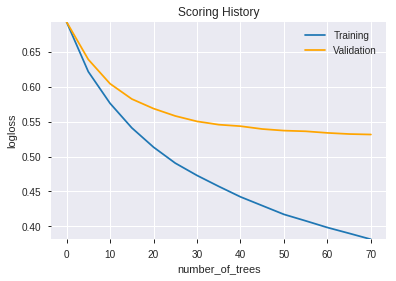

--2019-08-28 17:06:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

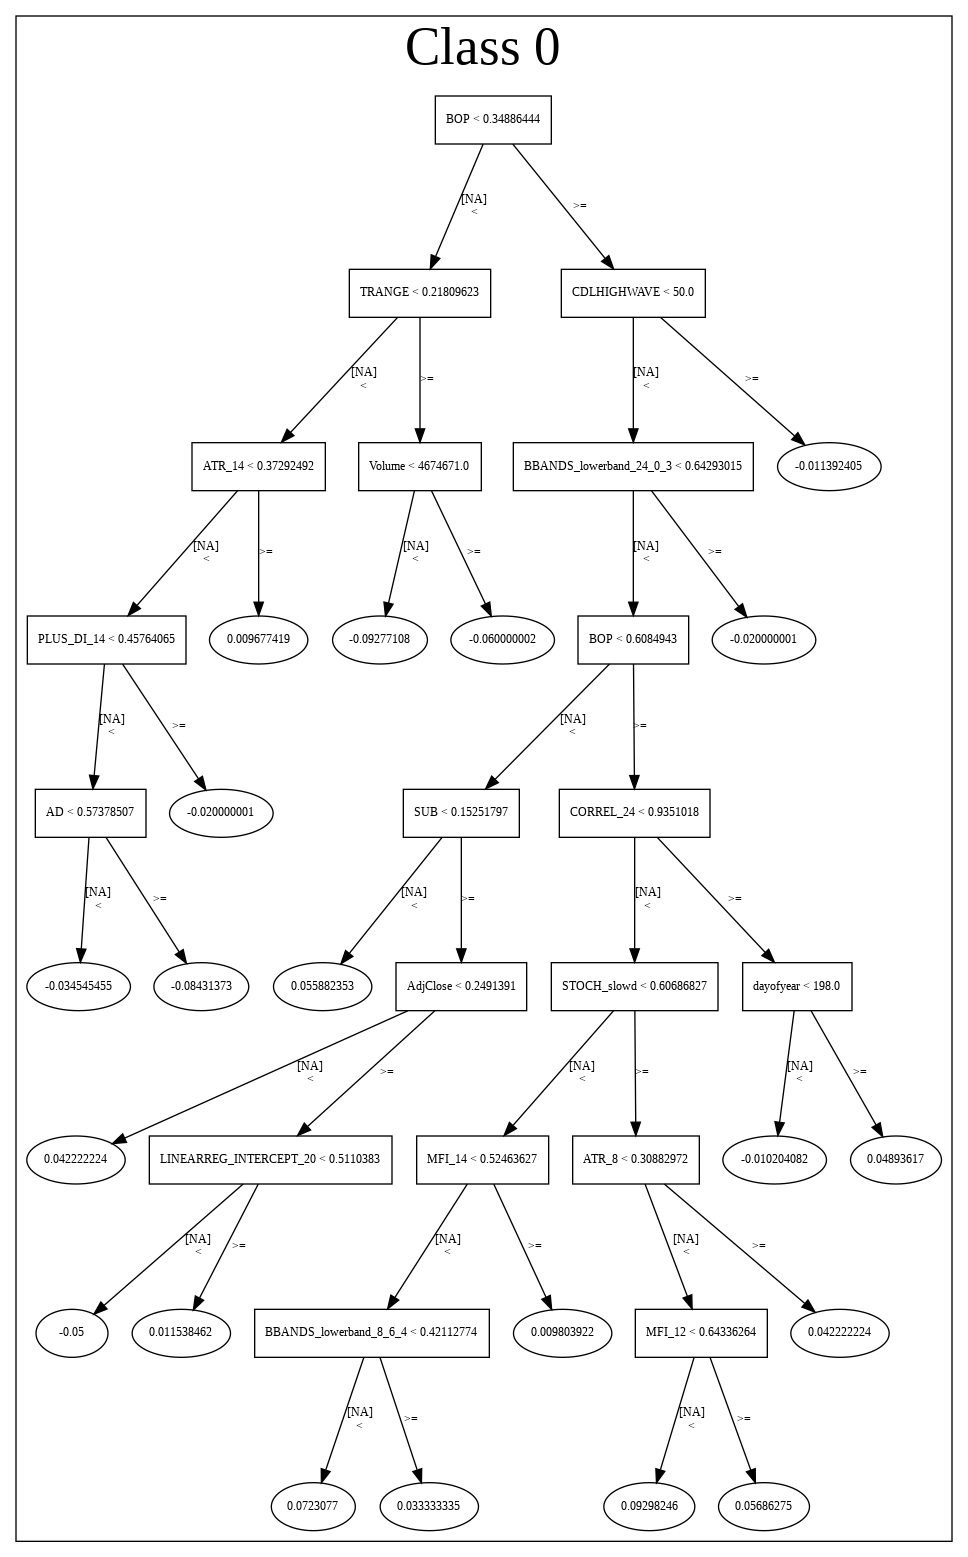

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_170549_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_170549_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8492',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_170709_model_6  0.741815  0.642913              0.281085  0.462163  0.213594
1  DeepLearning_grid_1_AutoML_20190828_170709_model_7  0.739501  0.673009              0.302579  0.463431  0.214768
2  DeepLearning_grid_1_AutoML_20190828_170709_model_9  0.739253  0.605054              0.302083  0.456346  0.208251
3  DeepLearning_grid_1_AutoML_20190828_170709_model_5  0.729415  0.660577              0.340774  0.465634  0.216815
4  DeepLearning_grid_1_AutoML_20190828_170709_model_8  0.713211  0.652330              0.332672  0.470522  0.221391
5               DeepLearning_1_AutoML_20190828_170709  0.705771  0.765003              0.379960  0.489585  0.239694
6  DeepLearning_grid_1_AutoML_20190828_170709_model_2  0.696842  0.785502              0.379630  0.492350  0.242408
7  DeepLearning_grid_1_AutoML_20190828_170709_model_3  0.695106  0.893804              0.358300  0.496038  0.246054
8  DeepLearning_grid_1_AutoML_20190828_170709_model_1  0.675265  1.052064              0.397652  0.528665  0.279487
9  DeepLearning_grid_1_AutoML_20190828_170709_model_4  0.660466  1.087288              0.419974  0.537770  0.289197

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.036896
1   CDLCLOSINGMARUBOZU             0.987465           0.987465    0.036434
2          CDLLONGLINE             0.787879           0.787879    0.029070
3        CDLHANGINGMAN             0.635730           0.635730    0.023456
4                  SUB             0.626384           0.626384    0.023111
5                  DIV             0.613068           0.613068    0.022620
6               TRANGE             0.599082           0.599082    0.022104
7            CDLHAMMER             0.591177           0.591177    0.021812
8              weekday             0.568283           0.568283    0.020967
9                 hour             0.550079           0.550079    0.020296
10             ADXR_12             0.543907           0.543907    0.020068
11              ULTOSC             0.543105           0.543105    0.020038
12        HT_TRENDMODE             0.537321           0.537321    0.019825
13         CDLMARUBOZU             0.534238           0.534238    0.019711
14           CORREL_14             0.532310           0.532310    0.019640
15           CDLTAKURI             0.528266           0.528266    0.019491
16          aroonup_20             0.528253           0.528253    0.019490
17               DX_30             0.524970           0.524970    0.019369
18    CDLDRAGONFLYDOJI             0.522485           0.522485    0.019278
19              BETA_8             0.518196           0.518196    0.019119
20      STOCHRSI_fastk             0.517980           0.517980    0.019111
21         CDLHIGHWAVE             0.517737           0.517737    0.019102
22        CDLSHORTLINE             0.516837           0.516837    0.019069
23      STOCHRSI_fastd             0.516514           0.516514    0.019057
24        STOCHF_fastk             0.516411           0.516411    0.019054
25         STOCH_slowk             0.511472           0.511472    0.018871
26           aroonup_8             0.511307           0.511307    0.018865
27        weekday_name             0.510232           0.510232    0.018826
28              MFI_14             0.505233           0.505233    0.018641
29            WILLR_24             0.504942           0.504942    0.018630
30         HT_DCPERIOD             0.502819           0.502819    0.018552
31            WILLR_20             0.501813           0.501813    0.018515
32         STOCH_slowd             0.501739           0.501739    0.018512
33              Volume             0.500654           0.500654    0.018472
34      CDLSPINNINGTOP             0.500341           0.500341    0.018461
35             quarter             0.498106           0.498106    0.018378
36            WILLR_14             0.497132           0.497132    0.018342
37        STOCHF_fastd             0.492446           0.492446    0.018169
38        CDLENGULFING             0.491656           0.491656    0.018140
39   CDLGRAVESTONEDOJI             0.491324           0.491324    0.018128
40          AROONOSC_8             0.490817           0.490817    0.018109
41             WILLR_8             0.489201           0.489201    0.018050
42            WILLR_12             0.487623           0.487623    0.017991
43           CORREL_12             0.483560           0.483560    0.017841
44               ADOSC             0.475537           0.475537    0.017545
45               RSI_8             0.473698           0.473698    0.017478
46           CORREL_24             0.471503           0.471503    0.017397
47          CDLHIKKAKE             0.460096           0.460096    0.016976
48               CMO_8             0.455902           0.455902    0.016821
49         CDLBELTHOLD             0.436297           0.436297    0.016098

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_170709_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1662085956141653
RMSE: 0.40768688428028355
LogLoss: 0.4935180158578111
Mean Per-Class Error: 0.24040915724807377
AUC: 0.8391092217357363
pr_auc: 0.8102090137966645
Gini: 0.6782184434714726
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5019438629369092: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      534  271  0.3366   (271.0/805.0)
1      116  616  0.1585   (116.0/732.0)
Total  650  887  0.2518   (387.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.501944     0.760964  210
max f2                       0.196174     0.860215  321
max f0point5                 0.601071     0.749694  157
max accuracy                 0.573327     0.75797   173
max precision                0.998719     1         0
max recall                   0.0768601    1         366
max specificity              0.998719     1         0
max absolute_mcc             0.543491     0.519089  190
max min_per_class_accuracy   0.562722     0.750311  179
max mean_per_class_accuracy  0.543491     0.759591  190

Gains/Lift Table: Avg response rate: 47.63 %, avg score: 51.42 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.994972           2.09973    2.09973            1                0.997283   1                           0.997283            0.0218579       0.0218579                  109.973   109.973
    2        0.0201692                   0.990342           2.09973    2.09973            1                0.992718   1                           0.995074            0.0204918       0.0423497                  109.973   109.973
    3        0.0305791                   0.982616           2.09973    2.09973            1                0.98594    1                           0.991964            0.0218579       0.0642077                  109.973   109.973
    4        0.0403383                   0.977568           1.81976    2.03199            0.866667         0.979838   0.967742                    0.989031            0.0177596       0.0819672                  81.9763   103.199
    5        0.0500976                   0.971344           1.95974    2.01792            0.933333         0.974363   0.961039                    0.986173            0.0191257       0.101093                   95.9745   101.792
    6        0.100195                    0.9081             1.96338    1.99065            0.935065         0.945378   0.948052                    0.965775            0.0983607       0.199454                   96.3381   99.065
    7        0.150293                    0.815933           1.82703    1.93611            0.87013          0.858673   0.922078                    0.930075            0.0915301       0.290984                   82.7035   93.6112
    8        0.20039                     0.746472           1.39073    1.79977            0.662338         0.779174   0.857143                    0.892349            0.0696721       0.360656                   39.0728   79.9766
    9        0.299935                    0.660377           1.59195    1.73079            0.75817          0.698125   0.824295                    0.827889            0.15847         0.519126                   59.195    73.0794
    10       0.40013                     0.607122           1.33619    1.63198            0.636364         0.6311     0.777236                    0.778612            0.13388         0.653005                   33.619    63.1983
    11       0.500325                    0.555234           1.15894    1.53725            0.551948         0.580723   0.73212                     0.738982            0.11612         0.769126                   15.894    53.7251
    12       0.59987                     0.484484           0.864593   1.42563            0.411765         0.521549   0.678959                    0.702901            0.0860656       0.855191                   -13.5407  42.5628
    13       0.700065                    0.389488           0.708999   1.32306            0.337662         0.440836   0.630112                    0.665393            0.0710383       0.92623                    -29.1001  32.3062
    14       0.79961                     0.223212           0.494053   1.21986            0.235294         0.304934   0.58096                     0.620519            0.0491803       0.97541                    -50.5947  21.9858
    15       0.899805                    0.0783747          0.231788   1.10983            0.11039          0.145978   0.528561                    0.567678            0.023224        0.998634                   -76.8212  10.9834
    16       1                           0.000600515        0.0136346  1                  0.00649351       0.0336411  0.476252  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18810785741976296
RMSE: 0.43371402723426294
LogLoss: 0.5584007487203635
Mean Per-Class Error: 0.2726648351648351
AUC: 0.7898976023976024
pr_auc: 0.7671545732725656
Gini: 0.5797952047952049
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24031761782887082: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  116  0.5022   (116.0/231.0)
1      18   190  0.0865   (18.0/208.0)
Total  133  306  0.3052   (134.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.240318     0.7393    284
max f2                       0.0722945    0.84507   346
max f0point5                 0.508981     0.709586  198
max accuracy                 0.508981     0.726651  198
max precision                0.997799     1         0
max recall                   0.00825297   1         391
max specificity              0.997799     1         0
max absolute_mcc             0.497887     0.454047  204
max min_per_class_accuracy   0.508981     0.725962  198
max mean_per_class_accuracy  0.497887     0.727335  204

Gains/Lift Table: Avg response rate: 47.38 %, avg score: 46.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.993462           2.11058   2.11058            1                0.995786   1                           0.995786            0.0240385       0.0240385                  111.058   111.058
    2        0.0205011                   0.988658           2.11058   2.11058            1                0.990836   1                           0.993586            0.0192308       0.0432692                  111.058   111.058
    3        0.0318907                   0.9843             1.68846   1.95982            0.8              0.986512   0.928571                    0.991059            0.0192308       0.0625                     68.8462   95.9821
    4        0.0410023                   0.976825           2.11058   1.99332            1                0.980441   0.944444                    0.9887              0.0192308       0.0817308                  111.058   99.3323
    5        0.0501139                   0.964977           2.11058   2.01464            1                0.974372   0.954545                    0.986095            0.0192308       0.100962                   111.058   101.464
    6        0.100228                    0.894435           1.91871   1.96667            0.909091         0.927946   0.931818                    0.95702             0.0961538       0.197115                   91.8706   96.6674
    7        0.150342                    0.814792           1.53497   1.82277            0.727273         0.852335   0.863636                    0.922125            0.0769231       0.274038                   53.4965   82.2771
    8        0.200456                    0.752025           1.82277   1.82277            0.863636         0.787217   0.863636                    0.888398            0.0913462       0.365385                   82.2771   82.2771
    9        0.300683                    0.659604           1.10326   1.58293            0.522727         0.69698    0.75                        0.824592            0.110577        0.475962                   10.3256   58.2933
    10       0.400911                    0.569821           1.29513   1.51098            0.613636         0.615848   0.715909                    0.772406            0.129808        0.605769                   29.5127   51.0981
    11       0.501139                    0.497887           1.34309   1.4774             0.636364         0.541474   0.7                         0.72622             0.134615        0.740385                   34.3094   47.7404
    12       0.599089                    0.390383           0.834414  1.37228            0.395349         0.443711   0.65019                     0.68003             0.0817308       0.822115                   -16.5586  37.2276
    13       0.699317                    0.219897           0.911385  1.30622            0.431818         0.317544   0.618893                    0.628078            0.0913462       0.913462                   -8.86145  30.622
    14       0.799544                    0.112958           0.335774  1.18457            0.159091         0.163934   0.561254                    0.569894            0.0336538       0.947115                   -66.4226  18.4569
    15       0.899772                    0.0436575          0.383741  1.09536            0.181818         0.0754202  0.518987                    0.514814            0.0384615       0.985577                   -61.6259  9.53627
    16       1                           0.00152312         0.143903  1                  0.0681818        0.0176357  0.473804                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:11:13  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 17:11:15  2 min  9.266 sec  865 obs/sec       1         1             1537       0.478152         0.832552            0.0834146      0.798889        0.654808           2.09973          0.303839                         0.507594           0.874818              -0.0334439       0.770927          0.747949             2.11058            0.346241
    2019-08-28 17:11:20  2 min 14.528 sec  1410 obs/sec      6         6             9222       0.421051         0.528204            0.289261       0.826741        0.799078           2.09973          0.266753                         0.439314           0.56268               0.225889         0.785329          0.765649             2.11058            0.275626
    2019-08-28 17:11:26  2 min 20.011 sec  1999 obs/sec      15        15            23055      0.407687         0.493518            0.333663       0.839109        0.810209           2.09973          0.251789                         0.433714           0.558401              0.245498         0.789898          0.767155             2.11058            0.305239
    2019-08-28 17:11:31  2 min 25.052 sec  2294 obs/sec      24        24            36888      0.399113         0.475909            0.361393       0.850905        0.825814           2.09973          0.253741                         0.436131           0.567888              0.237063         0.794008          0.773918             2.11058            0.323462
    2019-08-28 17:11:36  2 min 30.388 sec  2497 obs/sec      34        34            52258      0.390624         0.457933            0.388272       0.863585        0.839001           2.09973          0.232921                         0.439392           0.588362              0.225613         0.787504          0.755588             2.11058            0.314351
    2019-08-28 17:11:41  2 min 35.743 sec  2621 obs/sec      44        44            67628      0.381775         0.441175            0.415672       0.876449        0.852393           2.09973          0.219909                         0.436331           0.58082               0.236366         0.79202           0.7573               2.11058            0.284738
    2019-08-28 17:11:47  2 min 41.000 sec  2714 obs/sec      54        54            82998      0.375086         0.426422            0.43597        0.886051        0.850246           2.09973          0.214053                         0.443228           0.60721               0.212032         0.784424          0.745314             2.11058            0.275626
    2019-08-28 17:11:47  2 min 41.519 sec  2712 obs/sec      54        54            82998      0.407687         0.493518            0.333663       0.839109        0.810209           2.09973          0.251789                         0.433714           0.558401              0.245498         0.789898          0.767155             2.11058            0.305239

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.0368961120978873
CDLCLOSINGMARUBOZU  0.9874650835990906     0.9874650835990906   0.0364336224172217
CDLLONGLINE         0.787878692150116      0.787878692150116    0.029069660545107515
CDLHANGINGMAN       0.6357300281524658     0.6357300281524658   0.023455966382706427
SUB                 0.6263842582702637     0.6263842582702637   0.023111143809491638
---                 ---                    ---                  ---
RSI_8               0.47369784116744995    0.47369784116744995  0.017477608648241445
CORREL_24           0.4715028703212738     0.4715028703212738   0.017396622757849336
CDLHIKKAKE          0.46009647846221924    0.46009647846221924  0.01697577124518523
CMO_8               0.45590245723724365    0.45590245723724365  0.01682102816792761
CDLBELTHOLD         0.43629658222198486    0.43629658222198486  0.016097647605587455


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7181818181818181)

('F1', 0.7256637168141593)

('auc', 0.7418154761904762)

('logloss', 0.6429131385905998)

('mean_per_class_error', 0.28108465608465605)

('rmse', 0.46216268009832356)

('mse', 0.21359434287566534)

deeplearning prediction progress: |███████████████████████████████████████| 100%


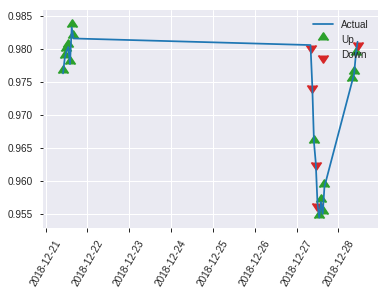


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21359434287566534
RMSE: 0.46216268009832356
LogLoss: 0.6429131385905998
Mean Per-Class Error: 0.28108465608465605
AUC: 0.7418154761904762
pr_auc: 0.6854709409629851
Gini: 0.48363095238095233
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5449867663405527: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   36   0.3214   (36.0/112.0)
1      26   82   0.2407   (26.0/108.0)
Total  102  118  0.2818   (62.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.544987     0.725664  117
max f2                       0.0855907    0.849057  203
max f0point5                 0.544987     0.706897  117
max accuracy                 0.544987     0.718182  117
max precision                0.999771     1         0
max recall                   0.0855907    1         203
max specificity              0.999771     1         0
max absolute_mcc             0.544987     0.438921  117
max min_per_class_accuracy   0.561491     0.694444  106
max mean_per_class_accuracy  0.544987     0.718915  117

Gains/Lift Table: Avg response rate: 49.09 %, avg score: 52.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.994293           2.03704   2.03704            1                0.997446   1                           0.997446            0.0277778       0.0277778                  103.704   103.704
    2        0.0227273                   0.991858           2.03704   2.03704            1                0.993135   1                           0.995722            0.0185185       0.0462963                  103.704   103.704
    3        0.0318182                   0.985083           0         1.45503            0                0.988015   0.714286                    0.99352             0               0.0462963                  -100      45.5026
    4        0.0409091                   0.97304            2.03704   1.58436            1                0.980859   0.777778                    0.990706            0.0185185       0.0648148                  103.704   58.4362
    5        0.05                        0.956891           1.01852   1.48148            0.5              0.970686   0.727273                    0.987066            0.00925926      0.0740741                  1.85185   48.1481
    6        0.1                         0.886948           1.48148   1.48148            0.727273         0.923374   0.727273                    0.95522             0.0740741       0.148148                   48.1481   48.1481
    7        0.15                        0.839254           1.48148   1.48148            0.727273         0.857964   0.727273                    0.922801            0.0740741       0.222222                   48.1481   48.1481
    8        0.2                         0.755845           1.48148   1.48148            0.727273         0.803715   0.727273                    0.89303             0.0740741       0.296296                   48.1481   48.1481
    9        0.3                         0.689519           1.2963    1.41975            0.636364         0.716135   0.69697                     0.834065            0.12963         0.425926                   29.6296   41.9753
    10       0.4                         0.621384           1.57407   1.45833            0.772727         0.652631   0.715909                    0.788706            0.157407        0.583333                   57.4074   45.8333
    11       0.5                         0.558523           1.11111   1.38889            0.545455         0.589876   0.681818                    0.74894             0.111111        0.694444                   11.1111   38.8889
    12       0.6                         0.495042           1.01852   1.32716            0.5              0.533284   0.651515                    0.712997            0.101852        0.796296                   1.85185   32.716
    13       0.7                         0.38984            0.740741  1.24339            0.363636         0.439528   0.61039                     0.67393             0.0740741       0.87037                    -25.9259  24.3386
    14       0.8                         0.254962           0.462963  1.14583            0.227273         0.324543   0.5625                      0.630257            0.0462963       0.916667                   -53.7037  14.5833
    15       0.9                         0.121046           0.648148  1.09053            0.318182         0.168136   0.535354                    0.57891             0.0648148       0.981481                   -35.1852  9.0535
    16       1                           0.00105622         0.185185  1                  0.0909091        0.0516988  0.490909                    0

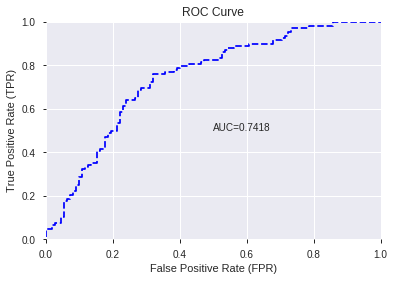

This function is available for GLM models only


--2019-08-28 17:14:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


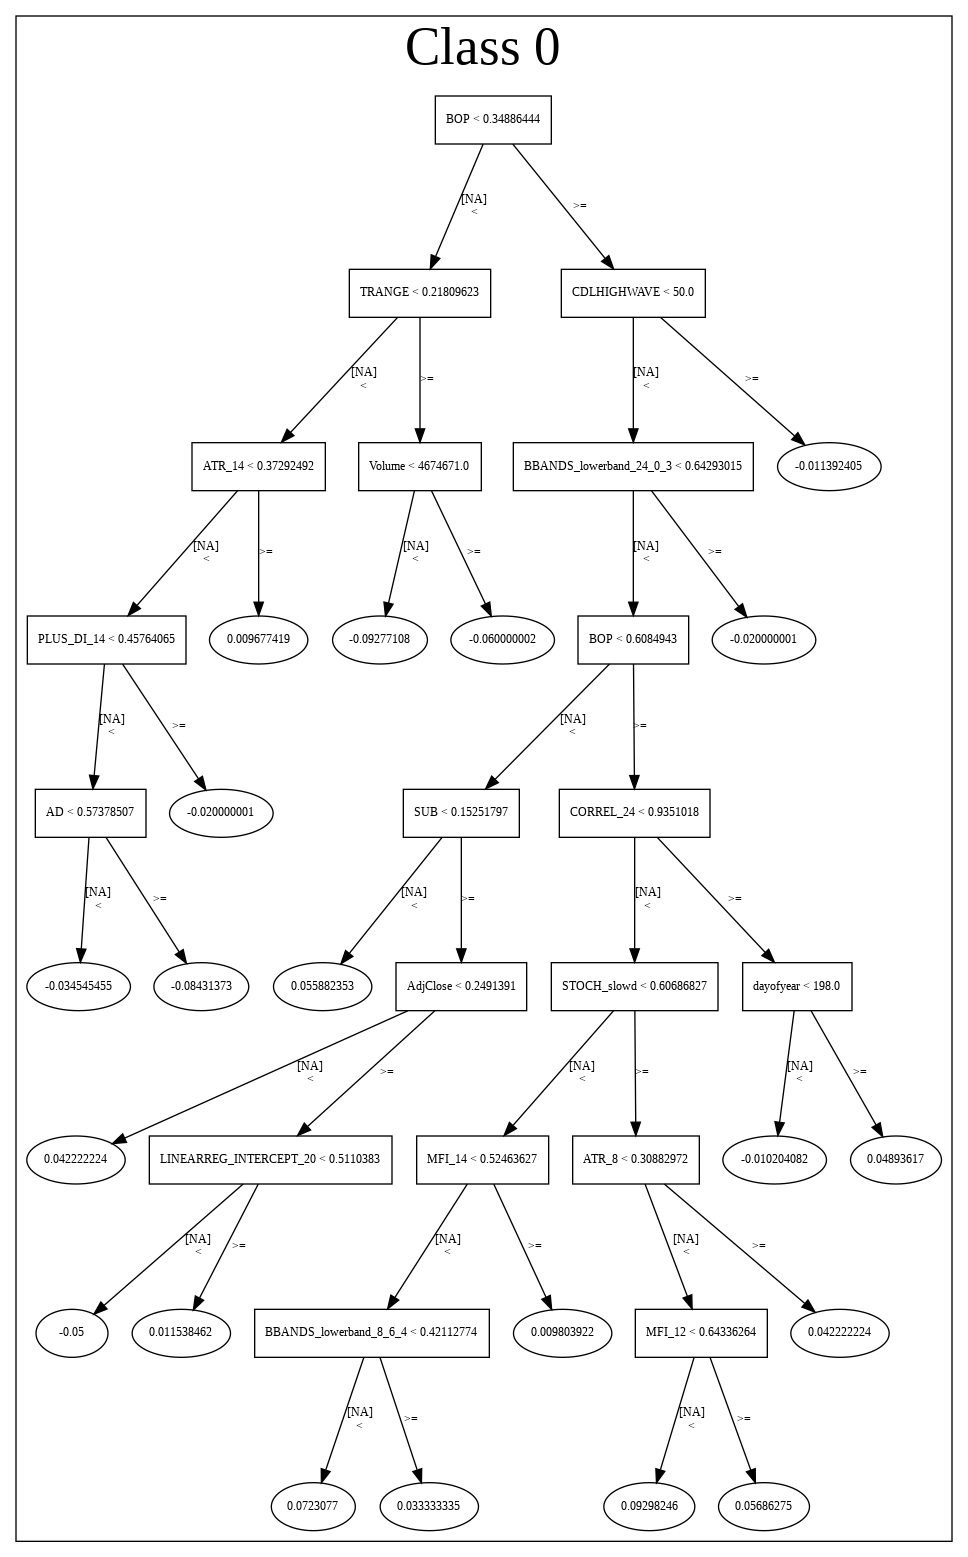

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_170709_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_170709_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8492',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLHANGINGMAN',
 'SUB',
 'DIV',
 'TRANGE',
 'CDLHAMMER',
 'weekday',
 'hour',
 'ADXR_12',
 'ULTOSC',
 'HT_TRENDMODE',
 'CDLMARUBOZU',
 'CORREL_14',
 'CDLTAKURI',
 'aroonup_20',
 'DX_30',
 'CDLDRAGONFLYDOJI',
 'BETA_8',
 'STOCHRSI_fastk',
 'CDLHIGHWAVE',
 'CDLSHORTLINE',
 'STOCHRSI_fastd',
 'STOCHF_fastk',
 'STOCH_slowk',
 'aroonup_8',
 'weekday_name',
 'MFI_14',
 'WILLR_24',
 'HT_DCPERIOD',
 'WILLR_20',
 'STOCH_slowd',
 'Volume',
 'CDLSPINNINGTOP',
 'quarter',
 'WILLR_14',
 'STOCHF_fastd',
 'CDLENGULFING',
 'CDLGRAVESTONEDOJI',
 'AROONOSC_8',
 'WILLR_8',
 'WILLR_12',
 'CORREL_12',
 'ADOSC',
 'RSI_8',
 'CORREL_24',
 'CDLHIKKAKE',
 'CMO_8',
 'CDLBELTHOLD']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190828_171507_model_1  0.727431  0.648043              0.318287  0.46692  0.218014

variable  relative_importance  scaled_importance  percentage
0                  SUB             0.909812           1.000000    0.086147
1                  BOP             0.884802           0.972511    0.083779
2         STOCHF_fastk             0.595286           0.654296    0.056366
3         STOCHF_fastd             0.511014           0.561670    0.048386
4     CDLDRAGONFLYDOJI             0.486954           0.535225    0.046108
5          STOCH_slowk             0.479206           0.526709    0.045374
6               ULTOSC             0.471809           0.518578    0.044674
7   CDLCLOSINGMARUBOZU             0.419051           0.460591    0.039678
8       STOCHRSI_fastd             0.387290           0.425682    0.036671
9       STOCHRSI_fastk             0.370946           0.407718    0.035124
10                 DIV             0.322806           0.354806    0.030565
11          aroonup_20             0.317673           0.349164    0.030079
12          AROONOSC_8             0.303747           0.333857    0.028761
13            WILLR_14             0.288862           0.317497    0.027351
14           CDLTAKURI             0.286165           0.314532    0.027096
15           CDLHAMMER             0.277342           0.304835    0.026261
16       CDLHANGINGMAN             0.262351           0.288358    0.024841
17            WILLR_24             0.213664           0.234844    0.020231
18                hour             0.205407           0.225768    0.019449
19         CDLBELTHOLD             0.201297           0.221251    0.019060
20               DX_30             0.177498           0.195093    0.016807
21          CDLHIKKAKE             0.173296           0.190474    0.016409
22              TRANGE             0.161367           0.177363    0.015279
23           CORREL_14             0.139486           0.153313    0.013207
24             ADXR_12             0.139036           0.152818    0.013165
25             WILLR_8             0.132369           0.145490    0.012534
26           CORREL_24             0.122253           0.134372    0.011576
27   CDLGRAVESTONEDOJI             0.104637           0.115009    0.009908
28        CDLSHORTLINE             0.103090           0.113309    0.009761
29         CDLMARUBOZU             0.096411           0.105968    0.009129
30              BETA_8             0.086774           0.095376    0.008216
31              MFI_14             0.084402           0.092769    0.007992
32         CDLLONGLINE             0.081952           0.090076    0.007760
33         CDLHIGHWAVE             0.079254           0.087111    0.007504
34         HT_DCPERIOD             0.073663           0.080966    0.006975
35               CMO_8             0.069113           0.075964    0.006544
36               ADOSC             0.066828           0.073453    0.006328
37              Volume             0.061609           0.067716    0.005834
38               RSI_8             0.055914           0.061456    0.005294
39           CORREL_12             0.055491           0.060992    0.005254
40             weekday             0.054734           0.060159    0.005183
41            WILLR_20             0.053043           0.058301    0.005022
42             quarter             0.047595           0.052313    0.004507
43            WILLR_12             0.040885           0.044938    0.003871
44        weekday_name             0.034585           0.038013    0.003275
45         STOCH_slowd             0.017207           0.018913    0.001629
46        HT_TRENDMODE             0.016748           0.018409    0.001586
47           aroonup_8             0.013355           0.014679    0.001265
48        CDLENGULFING             0.013019           0.014309    0.001233
49      CDLSPINNINGTOP             0.010074           0.011073    0.000954

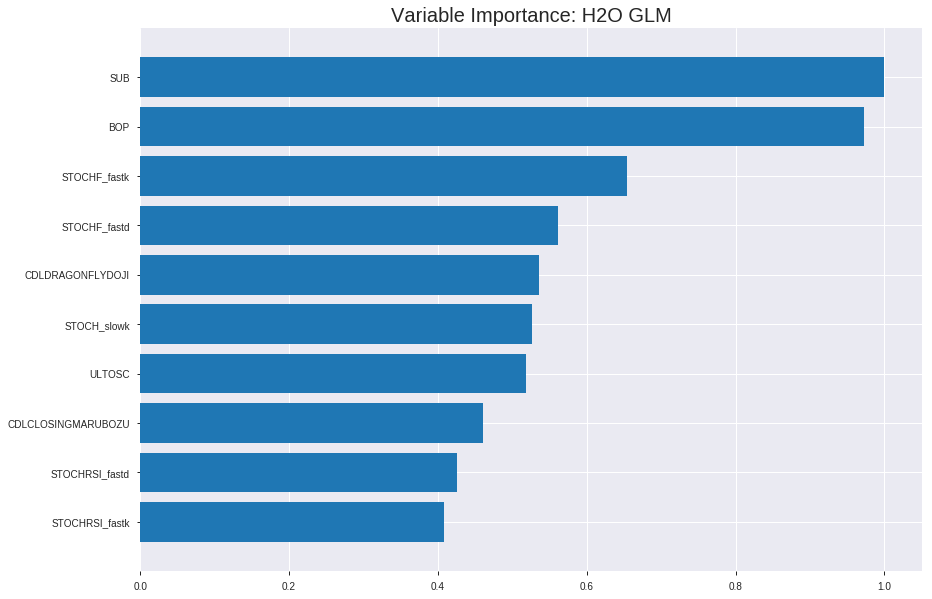

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_171507_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.16910915808249305
RMSE: 0.4112288390695539
LogLoss: 0.5055700810671874
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2127.2659845544013
Residual deviance: 1554.1224292005338
AIC: 1656.1224292005338
AUC: 0.8281726232902284
pr_auc: 0.8010668602561984
Gini: 0.6563452465804569
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36347048147005734: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      497  308  0.3826   (308.0/805.0)
1      105  627  0.1434   (105.0/732.0)
Total  602  935  0.2687   (413.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36347      0.75225   251
max f2                       0.180176     0.856254  325
max f0point5                 0.552397     0.744332  174
max accuracy                 0.486592     0.752765  200
max precision                0.989228     1         0
max recall                   0.0560102    1         372
max specificity              0.989228     1         0
max absolute_mcc             0.486592     0.505395  200
max min_per_class_accuracy   0.492587     0.750311  198
max mean_per_class_accuracy  0.486592     0.752949  200

Gains/Lift Table: Avg response rate: 47.63 %, avg score: 47.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.97845            1.96849    1.96849            0.9375           0.984026   0.9375                      0.984026            0.0204918       0.0204918                  96.8494   96.8494
    2        0.0201692                   0.965466           2.09973    2.03199            1                0.970887   0.967742                    0.977668            0.0204918       0.0409836                  109.973   103.199
    3        0.0305791                   0.959361           1.83726    1.9657             0.875            0.961962   0.93617                     0.972322            0.0191257       0.0601093                  83.7261   96.5702
    4        0.0403383                   0.951385           1.81976    1.93039            0.866667         0.955325   0.919355                    0.968209            0.0177596       0.0778689                  81.9763   93.0394
    5        0.0500976                   0.940754           1.95974    1.93611            0.933333         0.946125   0.922078                    0.963907            0.0191257       0.0969945                  95.9745   93.6112
    6        0.100195                    0.881507           1.93611    1.93611            0.922078         0.915418   0.922078                    0.939663            0.0969945       0.193989                   93.6112   93.6112
    7        0.150293                    0.808122           1.7725     1.88157            0.844156         0.842413   0.896104                    0.907246            0.0887978       0.282787                   77.2497   88.1573
    8        0.20039                     0.756049           1.55434    1.79977            0.74026          0.781217   0.857143                    0.875739            0.0778689       0.360656                   55.4343   79.9766
    9        0.299935                    0.661469           1.52333    1.70802            0.72549          0.70787    0.813449                    0.820025            0.151639        0.512295                   52.3331   70.8021
    10       0.40013                     0.570108           1.29529    1.60467            0.616883         0.616889   0.764228                    0.769159            0.129781        0.642077                   29.5286   60.4669
    11       0.500325                    0.474967           1.18621    1.52087            0.564935         0.526345   0.724317                    0.720533            0.118852        0.760929                   18.6209   52.0868
    12       0.59987                     0.37068            0.878317   1.41424            0.418301         0.426205   0.673536                    0.671691            0.0874317       0.848361                   -12.1683  41.4241
    13       0.700065                    0.278137           0.695364   1.31135            0.331169         0.323084   0.624535                    0.621797            0.0696721       0.918033                   -30.4636  31.1354
    14       0.79961                     0.19148            0.521501   1.21302            0.248366         0.232298   0.577705                    0.573308            0.0519126       0.969945                   -47.8499  21.3024
    15       0.899805                    0.0834099          0.259057   1.1068             0.123377         0.139022   0.527115                    0.524949            0.0259563       0.995902                   -74.0943  10.6797
    16       1                           0.000804772        0.0409038  1                  0.0194805        0.0389274  0.476252 



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19184777699079486
RMSE: 0.438004311612106
LogLoss: 0.558816735485613
Null degrees of freedom: 438
Residual degrees of freedom: 388
Null deviance: 607.3882128516068
Residual deviance: 490.6410937563682
AIC: 592.6410937563683
AUC: 0.7801053113553114
pr_auc: 0.759767256861327
Gini: 0.5602106227106227
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3305908864550004: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      132  99   0.4286   (99.0/231.0)
1      35   173  0.1683   (35.0/208.0)
Total  167  272  0.3052   (134.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330591     0.720833  249
max f2                       0.0822443    0.842105  366
max f0point5                 0.481894     0.703125  186
max accuracy                 0.481894     0.71754   186
max precision                0.995531     1         0
max recall                   0.0822443    1         366
max specificity              0.995531     1         0
max absolute_mcc             0.449426     0.436304  202
max min_per_class_accuracy   0.462388     0.711538  195
max mean_per_class_accuracy  0.449426     0.718438  202

Gains/Lift Table: Avg response rate: 47.38 %, avg score: 46.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.974335           2.11058   2.11058            1                0.986956   1                           0.986956            0.0240385       0.0240385                  111.058   111.058
    2        0.0205011                   0.955228           2.11058   2.11058            1                0.965085   1                           0.977236            0.0192308       0.0432692                  111.058   111.058
    3        0.0318907                   0.946974           2.11058   2.11058            1                0.950603   1                           0.967724            0.0240385       0.0673077                  111.058   111.058
    4        0.0410023                   0.935148           1.58293   1.99332            0.75             0.940561   0.944444                    0.961688            0.0144231       0.0817308                  58.2933   99.3323
    5        0.0501139                   0.929641           2.11058   2.01464            1                0.930835   0.954545                    0.956078            0.0192308       0.100962                   111.058   101.464
    6        0.100228                    0.843748           1.91871   1.96667            0.909091         0.888865   0.931818                    0.922472            0.0961538       0.197115                   91.8706   96.6674
    7        0.150342                    0.789161           1.43903   1.79079            0.681818         0.813306   0.848485                    0.886083            0.0721154       0.269231                   43.903    79.0793
    8        0.200456                    0.741972           1.72684   1.7748             0.818182         0.771885   0.840909                    0.857534            0.0865385       0.355769                   72.6836   77.4803
    9        0.300683                    0.643589           1.24716   1.59892            0.590909         0.689792   0.757576                    0.80162             0.125           0.480769                   24.7159   59.8922
    10       0.400911                    0.550237           1.10326   1.47501            0.522727         0.597762   0.698864                    0.750655            0.110577        0.591346                   10.3256   47.5005
    11       0.501139                    0.452055           1.34309   1.44862            0.636364         0.496709   0.686364                    0.699866            0.134615        0.725962                   34.3094   44.8623
    12       0.599089                    0.345228           0.785331  1.34018            0.372093         0.40116    0.634981                    0.651028            0.0769231       0.802885                   -21.4669  34.0176
    13       0.699317                    0.24763            0.81545   1.26497            0.386364         0.294853   0.599349                    0.59998             0.0817308       0.884615                   -18.455   26.4971
    14       0.799544                    0.180833           0.575612  1.17856            0.272727         0.212031   0.558405                    0.551349            0.0576923       0.942308                   -42.4388  17.8556
    15       0.899772                    0.104494           0.383741  1.09002            0.181818         0.14298    0.516456                    0.505859            0.0384615       0.980769                   -61.6259  9.00195
    16       1                           0.00368177         0.191871  1                  0.0909091        0.0484659  0.473804                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 17:15:07  0.000 sec   2            .23E2     51            1.3599543810529564  1.3632146593674597
     2019-08-28 17:15:07  0.012 sec   4            .14E2     51            1.3476484227442609  1.3528752676042324
     2019-08-28 17:15:07  0.024 sec   6            .89E1     51            1.3305420570235107  1.3385773008344917
     2019-08-28 17:15:07  0.037 sec   8            .55E1     51            1.3079772712676947  1.3198413668432707
     2019-08-28 17:15:07  0.049 sec   10           .34E1     51            1.2798550225611127  1.2967023887811522
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 17:15:07  0.289 sec   46           .25E-3    51            1.011230117882321   1.1179189039854678
     2019-08-28 17:15:07  0.295 sec   47           .16E-3    51            1.0111853845169596  1.1178036094478472
     2019-08-28 17:15:07  0.302 sec   48           .96E-4    51            1.0111609420278578  1.1177196349528387
     2019-08-28 17:15:07  0.310 sec   49           .6E-4     51            1.0111480444359198  1.1176792895080263
     2019-08-28 17:15:07  0.317 sec   50           .37E-4    51            1.0111401621343747  1.117633470971226


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6954545454545454)

('F1', 0.7380073800738006)

('auc', 0.7274305555555556)

('logloss', 0.6480428775985559)

('mean_per_class_error', 0.3029100529100529)

('rmse', 0.46691981661079274)

('mse', 0.21801411514385632)

glm prediction progress: |████████████████████████████████████████████████| 100%


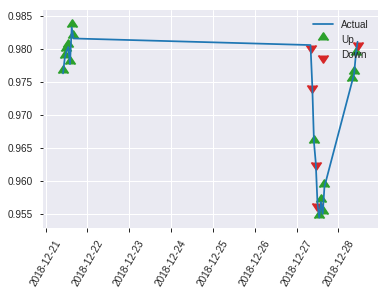


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21801411514385632
RMSE: 0.46691981661079274
LogLoss: 0.6480428775985559
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 305.10134599958155
Residual deviance: 285.13886614336457
AIC: 387.13886614336457
AUC: 0.7274305555555556
pr_auc: 0.6538484426422289
Gini: 0.45486111111111116
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3174237974900482: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   63   0.5625   (63.0/112.0)
1      8    100  0.0741   (8.0/108.0)
Total  57   163  0.3227   (71.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.317424     0.738007  162
max f2                       0.0910004    0.853081  200
max f0point5                 0.534263     0.683453  111
max accuracy                 0.449734     0.695455  128
max precision                0.985666     1         0
max recall                   0.0910004    1         200
max specificity              0.985666     1         0
max absolute_mcc             0.317424     0.414673  162
max min_per_class_accuracy   0.547544     0.678571  109
max mean_per_class_accuracy  0.449734     0.69709   128

Gains/Lift Table: Avg response rate: 49.09 %, avg score: 52.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.981545           1.35802    1.35802            0.666667         0.983889   0.666667                    0.983889            0.0185185       0.0185185                  35.8025   35.8025
    2        0.0227273                   0.971745           1.01852    1.22222            0.5              0.976017   0.6                         0.98074             0.00925926      0.0277778                  1.85185   22.2222
    3        0.0318182                   0.968943           2.03704    1.45503            1                0.969931   0.714286                    0.977652            0.0185185       0.0462963                  103.704   45.5026
    4        0.0409091                   0.965881           1.01852    1.35802            0.5              0.967987   0.666667                    0.975504            0.00925926      0.0555556                  1.85185   35.8025
    5        0.05                        0.957552           2.03704    1.48148            1                0.965135   0.727273                    0.973619            0.0185185       0.0740741                  103.704   48.1481
    6        0.1                         0.917572           1.48148    1.48148            0.727273         0.940884   0.727273                    0.957252            0.0740741       0.148148                   48.1481   48.1481
    7        0.15                        0.860675           1.2963     1.41975            0.636364         0.887031   0.69697                     0.933845            0.0648148       0.212963                   29.6296   41.9753
    8        0.2                         0.8119             1.48148    1.43519            0.727273         0.840834   0.704545                    0.910592            0.0740741       0.287037                   48.1481   43.5185
    9        0.3                         0.716694           1.11111    1.32716            0.545455         0.761038   0.651515                    0.860741            0.111111        0.398148                   11.1111   32.716
    10       0.4                         0.638411           1.2963     1.31944            0.636364         0.674251   0.647727                    0.814118            0.12963         0.527778                   29.6296   31.9444
    11       0.5                         0.546049           1.57407    1.37037            0.772727         0.590318   0.672727                    0.769358            0.157407        0.685185                   57.4074   37.037
    12       0.6                         0.441007           1.11111    1.32716            0.545455         0.488908   0.651515                    0.722616            0.111111        0.796296                   11.1111   32.716
    13       0.7                         0.334094           0.833333   1.25661            0.409091         0.390819   0.616883                    0.675217            0.0833333       0.87963                    -16.6667  25.6614
    14       0.8                         0.267427           0.740741   1.19213            0.363636         0.30409    0.585227                    0.628826            0.0740741       0.953704                   -25.9259  19.213
    15       0.9                         0.103923           0.37037    1.10082            0.181818         0.186412   0.540404                    0.579669            0.037037        0.990741                   -62.963   10.0823
    16       1                           0.0176805          0.0925926  1                  0.0454545        0.0532814  0.490909     

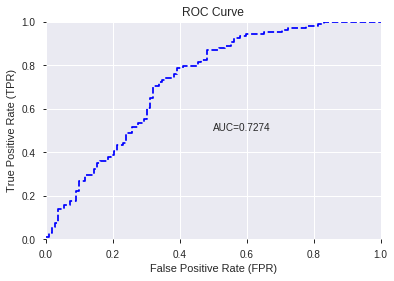

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


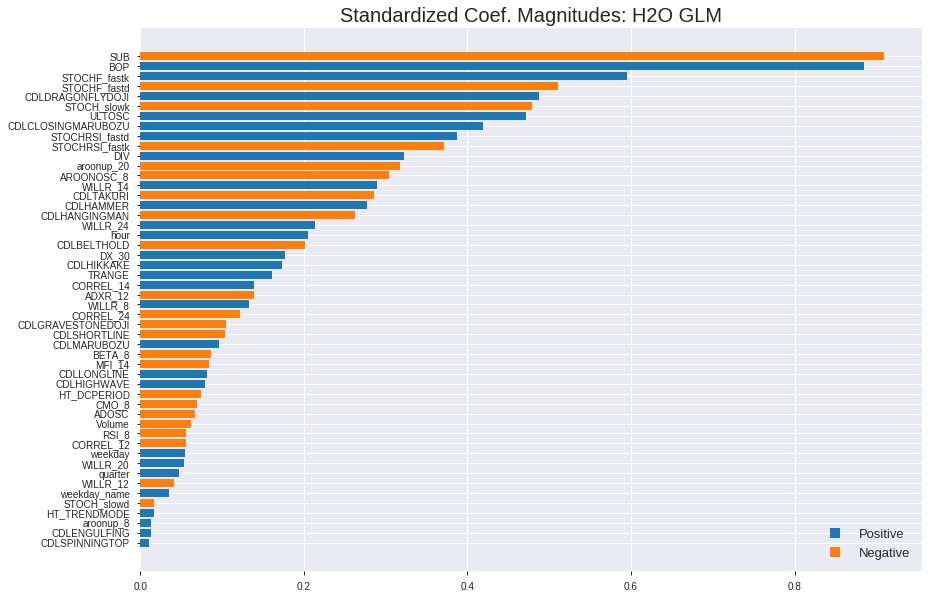

'log_likelihood'
--2019-08-28 17:15:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.99.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.99.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


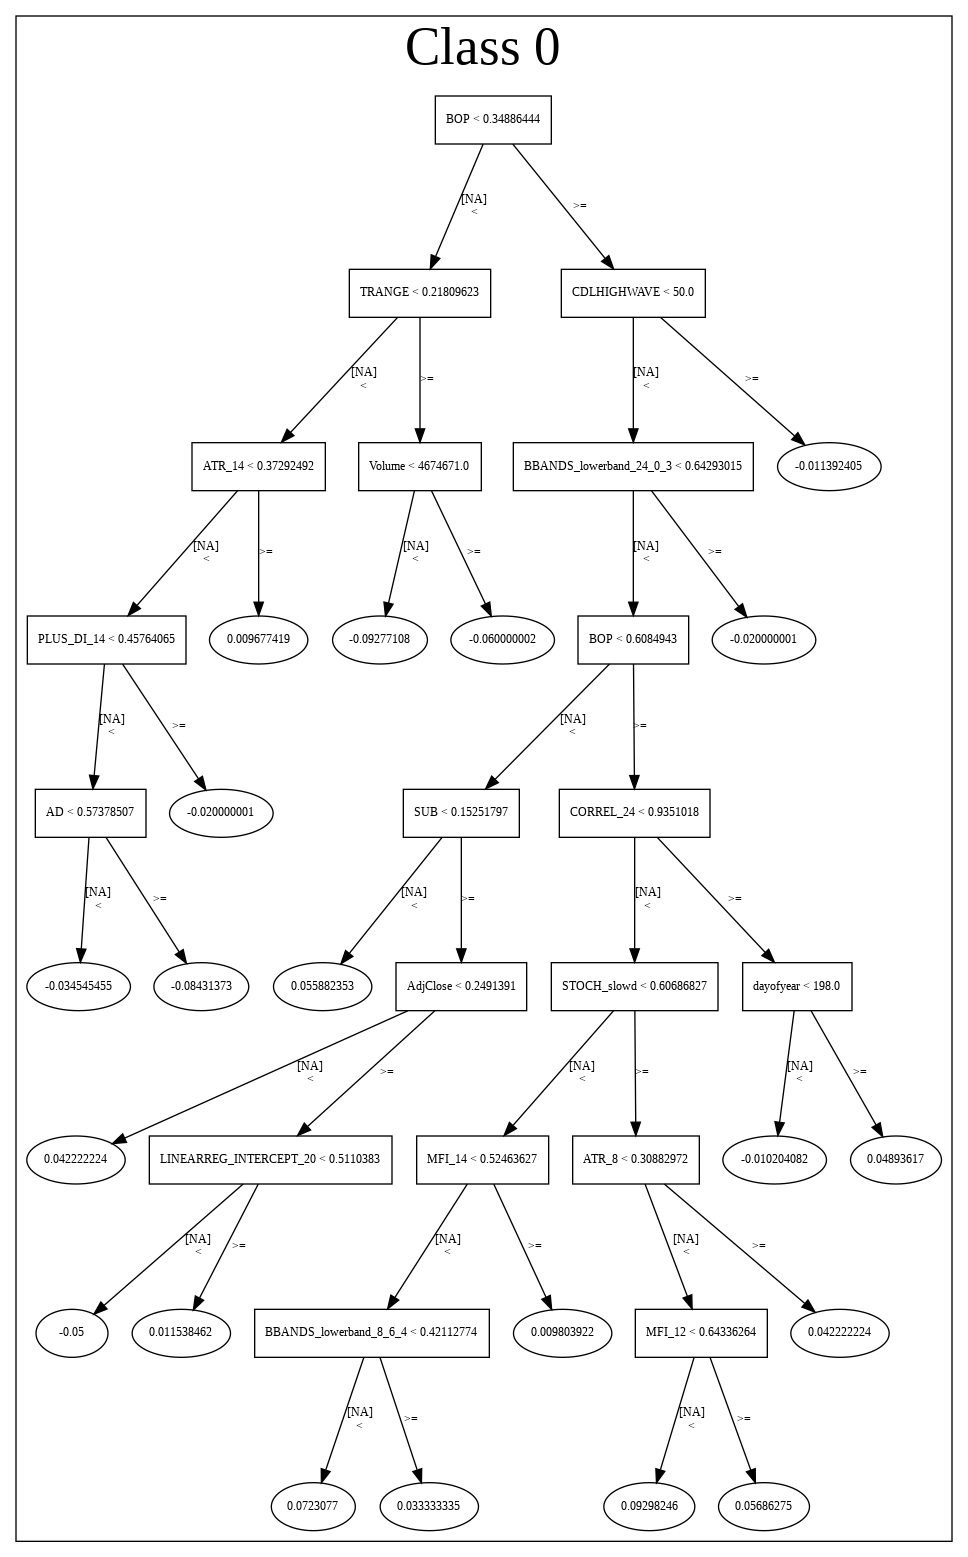

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_171507_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_171507_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8492',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['SUB',
 'BOP',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'CDLDRAGONFLYDOJI',
 'STOCH_slowk',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'DIV',
 'aroonup_20',
 'AROONOSC_8',
 'WILLR_14',
 'CDLTAKURI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'WILLR_24',
 'hour',
 'CDLBELTHOLD',
 'DX_30',
 'CDLHIKKAKE',
 'TRANGE',
 'CORREL_14',
 'ADXR_12',
 'WILLR_8',
 'CORREL_24',
 'CDLGRAVESTONEDOJI',
 'CDLSHORTLINE',
 'CDLMARUBOZU',
 'BETA_8',
 'MFI_14',
 'CDLLONGLINE',
 'CDLHIGHWAVE',
 'HT_DCPERIOD',
 'CMO_8',
 'ADOSC',
 'Volume',
 'RSI_8',
 'CORREL_12',
 'weekday',
 'WILLR_20',
 'quarter',
 'WILLR_12',
 'weekday_name',
 'STOCH_slowd',
 'HT_TRENDMODE',
 'aroonup_8',
 'CDLENGULFING',
 'CDLSPINNINGTOP']

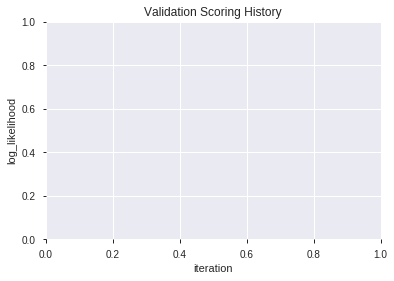

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_171524_model_3  0.728671  0.618886              0.288029  0.461902  0.213353
1               XGBoost_3_AutoML_20190828_171524  0.725777  0.617152              0.306382  0.462038  0.213479
2  XGBoost_grid_1_AutoML_20190828_171524_model_4  0.725446  0.614803              0.324074  0.461974  0.213420
3  XGBoost_grid_1_AutoML_20190828_171524_model_1  0.721974  0.625296              0.310516  0.465236  0.216444
4  XGBoost_grid_1_AutoML_20190828_171524_model_2  0.719329  0.620332              0.323909  0.463656  0.214977
5  XGBoost_grid_1_AutoML_20190828_171524_model_6  0.717427  0.627439              0.315146  0.467218  0.218293
6  XGBoost_grid_1_AutoML_20190828_171524_model_7  0.715278  0.631255              0.362434  0.469049  0.220007
7               XGBoost_2_AutoML_20190828_171524  0.712467  0.630643              0.311177  0.467847  0.218881
8  XGBoost_grid_1_AutoML_20190828_171524_model_5  0.711723  0.651504              0.328704  0.474115  0.224785
9               XGBoost_1_AutoML_20190828_171524  0.709243  0.637633              0.341601  0.471537  0.222347

variable  relative_importance  scaled_importance  percentage
0                  BOP          1833.427612           1.000000    0.233173
1                  DIV           382.609863           0.208686    0.048660
2         STOCHF_fastk           364.071533           0.198574    0.046302
3   CDLCLOSINGMARUBOZU           337.883606           0.184291    0.042972
4              WILLR_8           320.653687           0.174893    0.040780
5               TRANGE           285.761017           0.155862    0.036343
6               BETA_8           244.118912           0.133149    0.031047
7                  SUB           224.538162           0.122469    0.028556
8            aroonup_8           219.254639           0.119587    0.027885
9             WILLR_12           208.018387           0.113459    0.026456
10               ADOSC           185.832672           0.101358    0.023634
11      STOCHRSI_fastd           185.502029           0.101178    0.023592
12              Volume           179.251907           0.097769    0.022797
13      STOCHRSI_fastk           177.944809           0.097056    0.022631
14         STOCH_slowd           166.374802           0.090745    0.021159
15            WILLR_20           163.156326           0.088990    0.020750
16           CORREL_24           156.182983           0.085186    0.019863
17         HT_DCPERIOD           155.275742           0.084692    0.019748
18             ADXR_12           148.193985           0.080829    0.018847
19                hour           141.759705           0.077319    0.018029
20               DX_30           140.719864           0.076752    0.017897
21              ULTOSC           138.551376           0.075570    0.017621
22              MFI_14           133.405624           0.072763    0.016966
23          aroonup_20           132.797180           0.072431    0.016889
24         STOCH_slowk           117.156708           0.063900    0.014900
25               RSI_8           110.693893           0.060375    0.014078
26               CMO_8            99.529236           0.054286    0.012658
27            WILLR_14            98.494743           0.053722    0.012526
28         CDLLONGLINE            94.496872           0.051541    0.012018
29            WILLR_24            86.735764           0.047308    0.011031
30          AROONOSC_8            86.431847           0.047142    0.010992
31           CDLHAMMER            79.250130           0.043225    0.010079
32           CORREL_12            75.041161           0.040929    0.009544
33        STOCHF_fastd            72.102409           0.039327    0.009170
34           CORREL_14            69.968857           0.038163    0.008899
35    CDLDRAGONFLYDOJI            50.528221           0.027559    0.006426
36          CDLHIKKAKE            44.027393           0.024014    0.005599
37             quarter            32.392952           0.017668    0.004120
38             weekday            27.982025           0.015262    0.003559
39        weekday_name            24.811714           0.013533    0.003156
40        CDLSHORTLINE            17.046856           0.009298    0.002168
41         CDLHIGHWAVE            11.675497           0.006368    0.001485
42        HT_TRENDMODE            11.208809           0.006114    0.001426
43           CDLTAKURI            10.346523           0.005643    0.001316
44   CDLGRAVESTONEDOJI             7.053412           0.003847    0.000897
45      CDLSPINNINGTOP             5.871521           0.003202    0.000747
46       CDLHANGINGMAN             3.981699           0.002172    0.000506
47         CDLBELTHOLD             0.833918           0.000455    0.000106

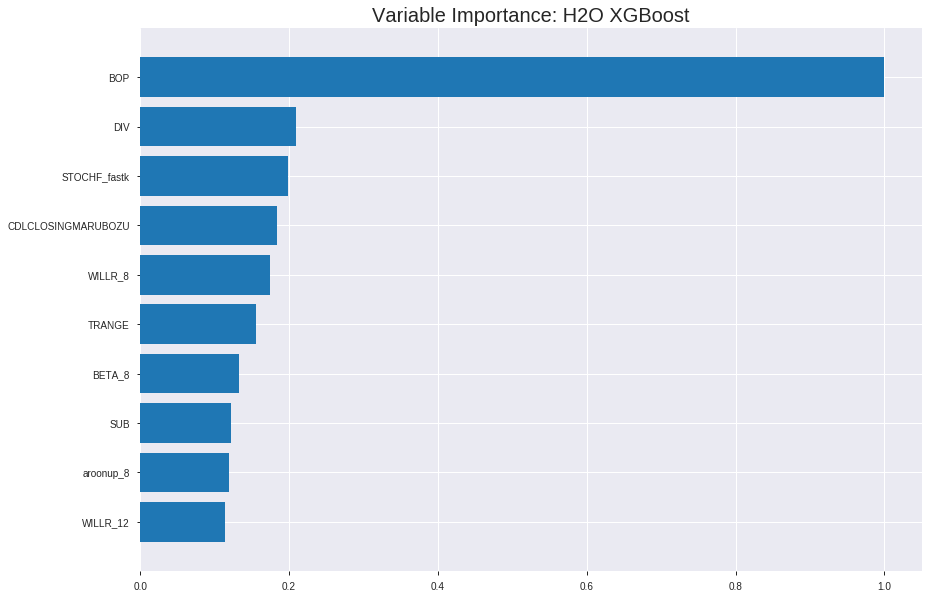

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_171524_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11923442823379443
RMSE: 0.34530338578385594
LogLoss: 0.3916931891850003
Mean Per-Class Error: 0.14103876047924513
AUC: 0.9348683094050164
pr_auc: 0.930433902776595
Gini: 0.8697366188100328
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5056614279747009: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      689  116  0.1441   (116.0/805.0)
1      101  631  0.138    (101.0/732.0)
Total  790  747  0.1412   (217.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.505661     0.853279  192
max f2                       0.329583     0.897175  264
max f0point5                 0.603909     0.877081  151
max accuracy                 0.560981     0.860117  171
max precision                0.964438     1         0
max recall                   0.140318     1         344
max specificity              0.964438     1         0
max absolute_mcc             0.560981     0.72084   171
max min_per_class_accuracy   0.509416     0.855901  191
max mean_per_class_accuracy  0.505661     0.858961  192

Gains/Lift Table: Avg response rate: 47.63 %, avg score: 47.74 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.939649           2.09973    2.09973            1                0.947585   1                           0.947585            0.0218579       0.0218579                  109.973   109.973
    2        0.0201692                   0.929246           2.09973    2.09973            1                0.934993   1                           0.941492            0.0204918       0.0423497                  109.973   109.973
    3        0.0305791                   0.918027           2.09973    2.09973            1                0.922981   1                           0.93519             0.0218579       0.0642077                  109.973   109.973
    4        0.0403383                   0.898247           2.09973    2.09973            1                0.90696    1                           0.92836             0.0204918       0.0846995                  109.973   109.973
    5        0.0500976                   0.878278           2.09973    2.09973            1                0.887761   1                           0.920451            0.0204918       0.105191                   109.973   109.973
    6        0.100195                    0.82233            2.09973    2.09973            1                0.849108   1                           0.88478             0.105191        0.210383                   109.973   109.973
    7        0.150293                    0.779991           2.04519    2.08155            0.974026         0.800822   0.991342                    0.856794            0.102459        0.312842                   104.519   108.155
    8        0.20039                     0.749587           2.04519    2.07246            0.974026         0.765085   0.987013                    0.833866            0.102459        0.415301                   104.519   107.246
    9        0.299935                    0.675861           1.82525    1.99041            0.869281         0.714182   0.947939                    0.794145            0.181694        0.596995                   82.5253   99.0413
    10       0.40013                     0.593233           1.62252    1.89829            0.772727         0.639168   0.904065                    0.755337            0.162568        0.759563                   62.2516   89.829
    11       0.500325                    0.489141           1.13167    1.74477            0.538961         0.542752   0.830949                    0.712765            0.113388        0.872951                   13.1671   74.4766
    12       0.59987                     0.395198           0.590119   1.55316            0.281046         0.443591   0.739696                    0.668097            0.0587432       0.931694                   -40.9881  55.316
    13       0.700065                    0.278811           0.449941   1.39526            0.214286         0.333084   0.664498                    0.620149            0.045082        0.976776                   -55.0059  39.5265
    14       0.79961                     0.174823           0.205856   1.24719            0.0980392        0.226314   0.593979                    0.57112             0.0204918       0.997268                   -79.4144  24.7193
    15       0.899805                    0.103789           0.0272692  1.11135            0.012987         0.137948   0.529284                    0.522886            0.00273224      1                          -97.2731  11.1352
    16       1                           0.028576           0          1                  0                0.0688595  0.476252   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1783231767440416
RMSE: 0.4222832896812774
LogLoss: 0.528720950800744
Mean Per-Class Error: 0.25607725607725607
AUC: 0.8126040626040626
pr_auc: 0.7903623878974457
Gini: 0.6252081252081252
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4408074915409088: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      166  65   0.2814   (65.0/231.0)
1      48   160  0.2308   (48.0/208.0)
Total  214  225  0.2574   (113.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440807     0.73903   201
max f2                       0.15628      0.861204  329
max f0point5                 0.539335     0.738397  162
max accuracy                 0.539335     0.742597  162
max precision                0.954372     1         0
max recall                   0.0840527    1         372
max specificity              0.954372     1         0
max absolute_mcc             0.440807     0.487328  201
max min_per_class_accuracy   0.475852     0.727273  191
max mean_per_class_accuracy  0.440807     0.743923  201

Gains/Lift Table: Avg response rate: 47.38 %, avg score: 44.36 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.920275           2.11058    2.11058            1                0.936779   1                           0.936779            0.0240385       0.0240385                  111.058   111.058
    2        0.0205011                   0.902034           2.11058    2.11058            1                0.910385   1                           0.925048            0.0192308       0.0432692                  111.058   111.058
    3        0.0318907                   0.884275           2.11058    2.11058            1                0.891558   1                           0.913088            0.0240385       0.0673077                  111.058   111.058
    4        0.0410023                   0.869268           2.11058    2.11058            1                0.875822   1                           0.904806            0.0192308       0.0865385                  111.058   111.058
    5        0.0501139                   0.853831           2.11058    2.11058            1                0.858279   1                           0.896347            0.0192308       0.105769                   111.058   111.058
    6        0.100228                    0.773138           1.91871    2.01464            0.909091         0.809827   0.954545                    0.853087            0.0961538       0.201923                   91.8706   101.464
    7        0.150342                    0.735073           1.43903    1.82277            0.681818         0.753147   0.863636                    0.819773            0.0721154       0.274038                   43.903    82.2771
    8        0.200456                    0.690483           1.6309     1.7748             0.772727         0.710212   0.840909                    0.792383            0.0817308       0.355769                   63.09     77.4803
    9        0.300683                    0.630819           1.53497    1.69486            0.727273         0.656557   0.80303                     0.747108            0.153846        0.509615                   53.4965   69.4857
    10       0.400911                    0.546213           1.29513    1.59492            0.613636         0.580665   0.755682                    0.705497            0.129808        0.639423                   29.5127   59.4925
    11       0.501139                    0.455051           1.10326    1.49659            0.522727         0.507774   0.709091                    0.665952            0.110577        0.75                       10.3256   49.6591
    12       0.599089                    0.336121           0.736248   1.37228            0.348837         0.399438   0.65019                     0.622378            0.0721154       0.822115                   -26.3752  37.2276
    13       0.699317                    0.232231           0.767483   1.2856             0.363636         0.290743   0.609121                    0.574847            0.0769231       0.899038                   -23.2517  28.5596
    14       0.799544                    0.17158            0.719515   1.21463            0.340909         0.201482   0.575499                    0.528043            0.0721154       0.971154                   -28.0485  21.4634
    15       0.899772                    0.106894           0.239838   1.10605            0.113636         0.139598   0.524051                    0.484774            0.0240385       0.995192                   -76.0162  10.6049
    16       1                           0.0265364          0.0479677  1                  0.0227273        0.0740186  0.473804 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:15:32  2.452 sec   0                  0.5              0.693147            0.5             0                  1                0.523748                         0.5                0.693147              0.5               0                    1                  0.526196
    2019-08-28 17:15:32  2.564 sec   5                  0.470491         0.635462            0.848823        0.823626           2.09973          0.228367                         0.476105           0.646154              0.790137          0.768247             2.11058            0.318907
    2019-08-28 17:15:32  2.633 sec   10                 0.448041         0.592416            0.858446        0.84449            2.09973          0.247235                         0.459539           0.613759              0.797629          0.782825             2.11058            0.298405
    2019-08-28 17:15:32  2.702 sec   15                 0.428954         0.55576             0.870766        0.856861           2.09973          0.232271                         0.447392           0.589578              0.803519          0.785731             2.11058            0.300683
    2019-08-28 17:15:32  2.777 sec   20                 0.414466         0.527393            0.878819        0.86305            2.09973          0.213403                         0.438158           0.570376              0.806433          0.785508             2.11058            0.291572
    2019-08-28 17:15:32  2.856 sec   25                 0.403985         0.506577            0.886446        0.876728           2.09973          0.19974                          0.433165           0.559278              0.807453          0.785723             2.11058            0.248292
    2019-08-28 17:15:33  2.928 sec   30                 0.395803         0.489678            0.890697        0.880674           2.09973          0.208848                         0.430638           0.55261               0.80533           0.783776             2.11058            0.255125
    2019-08-28 17:15:33  3.005 sec   35                 0.387247         0.472604            0.898202        0.888779           2.09973          0.182824                         0.428527           0.547326              0.805611          0.774336             2.11058            0.257403
    2019-08-28 17:15:33  3.090 sec   40                 0.381099         0.46016             0.903946        0.895505           2.09973          0.176968                         0.427657           0.544063              0.804955          0.777794             2.11058            0.271071
    2019-08-28 17:15:33  3.169 sec   45                 0.374457         0.447054            0.909498        0.899547           2.09973          0.167859                         0.4255             0.538911              0.808837          0.781994             2.11058            0.275626
    2019-08-28 17:15:33  3.255 sec   50                 0.369313         0.436301            0.912218        0.904714           2.09973          0.172414                         0.422995           0.53296               0.81328           0.788963             2.11058            0.273349
    2019-08-28 17:15:33  3.336 sec   55                 0.365138         0.427528            0.915765        0.909161           2.09973          0.162655                         0.422597           0.531407              0.812802          0

Variable Importances: 


variable            relative_importance    scaled_importance       percentage
------------------  ---------------------  ----------------------  ----------------------
BOP                 1833.4276123046875     1.0                     0.23317303847841567
DIV                 382.60986328125        0.2086855574299413      0.048659845512501326
STOCHF_fastk        364.071533203125       0.1985742609960332      0.046302163800051005
CDLCLOSINGMARUBOZU  337.88360595703125     0.18429067157568269     0.04297161585452972
WILLR_8             320.6536865234375      0.17489301697619997     0.04078033617699768
---                 ---                    ---                     ---
CDLTAKURI           10.34652328491211      0.0056432679509534275   0.0013158579350716737
CDLGRAVESTONEDOJI   7.053412437438965      0.0038471180373314874   0.0008970442021497019
CDLSPINNINGTOP      5.87152099609375       0.0032024831286974168   0.0007467327217942398
CDLHANGINGMAN       3.981698513031006      0.002171723871893617    0.0005063874539455443
CDLBELTHOLD         0.8339176177978516     0.00045484076502457914  0.00010605660320462822


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7090909090909091)

('F1', 0.746031746031746)

('auc', 0.728670634920635)

('logloss', 0.6188857672911329)

('mean_per_class_error', 0.28802910052910047)

('rmse', 0.461901856105707)

('mse', 0.21335332467389725)

xgboost prediction progress: |████████████████████████████████████████████| 100%



ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21335332467389725
RMSE: 0.461901856105707
LogLoss: 0.6188857672911329
Mean Per-Class Error: 0.28802910052910047
AUC: 0.728670634920635
pr_auc: 0.6584745550200674
Gini: 0.45734126984127
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34579575061798096: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   50   0.4464   (50.0/112.0)
1      14   94   0.1296   (14.0/108.0)
Total  76   144  0.2909   (64.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.345796     0.746032  143
max f2                       0.143997     0.845295  194
max f0point5                 0.480584     0.692446  111
max accuracy                 0.347185     0.709091  141
max precision                0.929897     1         0
max recall                   0.0909259    1         206
max specificity              0.929897     1         0
max absolute_mcc             0.345796     0.445696  143
max min_per_class_accuracy   0.484324     0.6875    109
max mean_per_class_accuracy  0.345796     0.711971  143

Gains/Lift Table: Avg response rate: 49.09 %, avg score: 47.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.908933           0.679012  0.679012           0.333333         0.921372   0.333333                    0.921372            0.00925926      0.00925926                 -32.0988  -32.0988
    2        0.0227273                   0.892382           2.03704   1.22222            1                0.899388   0.6                         0.912578            0.0185185       0.0277778                  103.704   22.2222
    3        0.0318182                   0.883664           2.03704   1.45503            1                0.887249   0.714286                    0.905341            0.0185185       0.0462963                  103.704   45.5026
    4        0.0409091                   0.878454           1.01852   1.35802            0.5              0.880894   0.666667                    0.899909            0.00925926      0.0555556                  1.85185   35.8025
    5        0.05                        0.87163            2.03704   1.48148            1                0.877855   0.727273                    0.895899            0.0185185       0.0740741                  103.704   48.1481
    6        0.1                         0.804296           1.2963    1.38889            0.636364         0.832264   0.681818                    0.864082            0.0648148       0.138889                   29.6296   38.8889
    7        0.15                        0.764343           1.85185   1.54321            0.909091         0.786677   0.757576                    0.83828             0.0925926       0.231481                   85.1852   54.321
    8        0.2                         0.724663           1.11111   1.43519            0.545455         0.741495   0.704545                    0.814084            0.0555556       0.287037                   11.1111   43.5185
    9        0.3                         0.630924           1.2963    1.38889            0.636364         0.670865   0.681818                    0.766344            0.12963         0.416667                   29.6296   38.8889
    10       0.4                         0.571806           1.2963    1.36574            0.636364         0.606712   0.670455                    0.726436            0.12963         0.546296                   29.6296   36.5741
    11       0.5                         0.484032           1.48148   1.38889            0.727273         0.527981   0.681818                    0.686745            0.148148        0.694444                   48.1481   38.8889
    12       0.6                         0.394961           0.833333  1.2963             0.409091         0.441172   0.636364                    0.645816            0.0833333       0.777778                   -16.6667  29.6296
    13       0.7                         0.301309           0.925926  1.24339            0.454545         0.347852   0.61039                     0.60325             0.0925926       0.87037                    -7.40741  24.3386
    14       0.8                         0.210624           0.555556  1.15741            0.272727         0.256852   0.568182                    0.55995             0.0555556       0.925926                   -44.4444  15.7407
    15       0.9                         0.128527           0.555556  1.09053            0.272727         0.164351   0.535354                    0.515995            0.0555556       0.981481                   -44.4444  9.0535
    16       1                           0.0517117          0.185185  1                  0.0909091        0.0854312  0.490909                    

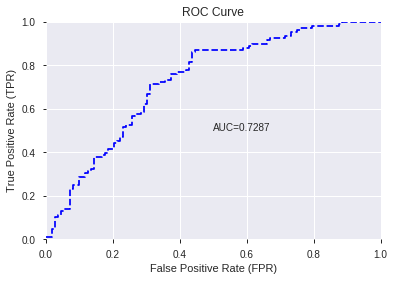

This function is available for GLM models only


--2019-08-28 17:15:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.160.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.160.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

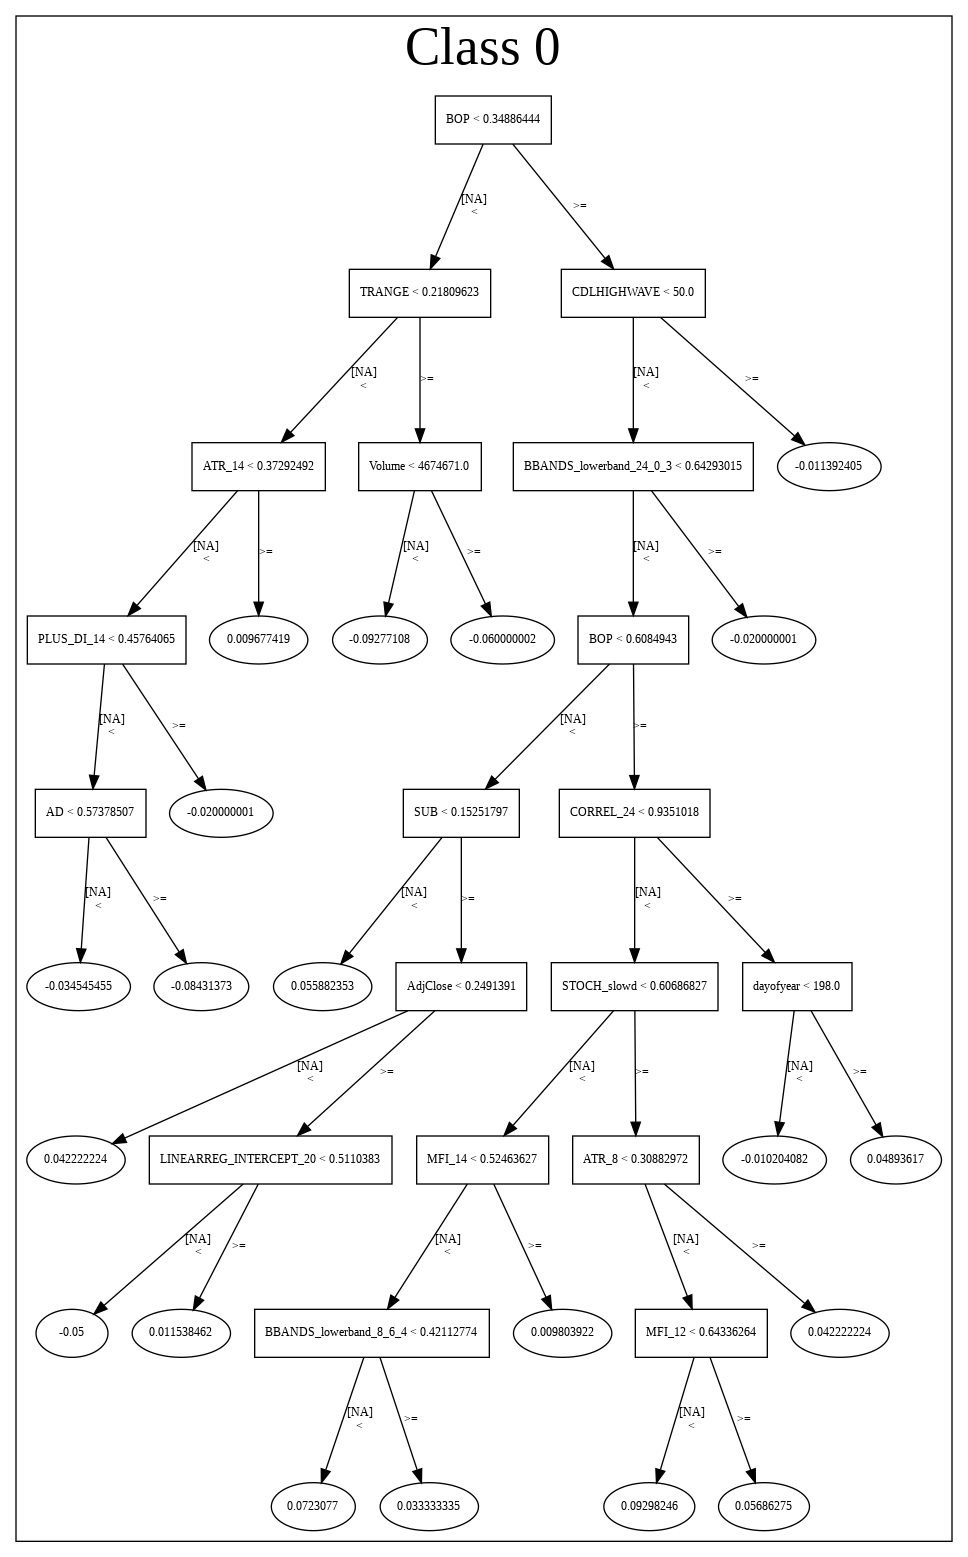

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_171524_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_171524_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8492',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'TRANGE',
 'BETA_8',
 'SUB',
 'aroonup_8',
 'WILLR_12',
 'ADOSC',
 'STOCHRSI_fastd',
 'Volume',
 'STOCHRSI_fastk',
 'STOCH_slowd',
 'WILLR_20',
 'CORREL_24',
 'HT_DCPERIOD',
 'ADXR_12',
 'hour',
 'DX_30',
 'ULTOSC',
 'MFI_14',
 'aroonup_20',
 'STOCH_slowk',
 'RSI_8',
 'CMO_8',
 'WILLR_14',
 'CDLLONGLINE',
 'WILLR_24',
 'AROONOSC_8',
 'CDLHAMMER',
 'CORREL_12',
 'STOCHF_fastd',
 'CORREL_14',
 'CDLDRAGONFLYDOJI',
 'CDLHIKKAKE',
 'quarter',
 'weekday',
 'weekday_name',
 'CDLSHORTLINE',
 'CDLHIGHWAVE',
 'HT_TRENDMODE',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'CDLSPINNINGTOP',
 'CDLHANGINGMAN',
 'CDLBELTHOLD']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 894 924 931] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


73

['hour',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'MOM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MOM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'MOM_20',
 'ROC_20',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'RSI_20',
 'WILLR_20',
 'CMO_24',
 'MOM_24',
 'ROC_24',
 'ROCP_24',
 'ROCR_24',
 'ROCR100_24',
 'RSI_24',
 'WILLR_24',
 'CMO_30',
 'MOM_30',
 'ROC_30',
 'ROCP_30',
 'ROCR_30',
 'ROCR100_30',
 'RSI_30',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLTAKURI',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_171559_model_9  0.750579  0.604562              0.315311  0.454623  0.206682
1  DeepLearning_grid_1_AutoML_20190828_171559_model_6  0.745701  0.635330              0.315146  0.459609  0.211240
2  DeepLearning_grid_1_AutoML_20190828_171559_model_3  0.743634  0.770485              0.289021  0.466556  0.217674
3  DeepLearning_grid_1_AutoML_20190828_171559_model_8  0.743056  0.640882              0.284557  0.456717  0.208591
4  DeepLearning_grid_1_AutoML_20190828_171559_model_4  0.740079  0.898418              0.271164  0.485857  0.236057
5  DeepLearning_grid_1_AutoML_20190828_171559_model_5  0.740038  0.670553              0.289021  0.462357  0.213774
6               DeepLearning_1_AutoML_20190828_171559  0.737186  0.693162              0.332672  0.482030  0.232353
7  DeepLearning_grid_1_AutoML_20190828_171559_model_2  0.737103  0.698208              0.319610  0.468479  0.219473
8  DeepLearning_grid_1_AutoML_20190828_171559_model_7  0.727596  0.872014              0.357804  0.510716  0.260831
9  DeepLearning_grid_1_AutoML_20190828_171559_model_1  0.703704  1.048964              0.338790  0.503957  0.253972

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.042457
1                  BOP             0.950806           0.950806    0.040369
2          CDLLONGLINE             0.767993           0.767993    0.032607
3        CDLHANGINGMAN             0.552281           0.552281    0.023448
4                  SUB             0.537637           0.537637    0.022827
..                 ...                  ...                ...         ...
68              CMO_14             0.233322           0.233322    0.009906
69             ROCR_20             0.231265           0.231265    0.009819
70             ROCP_24             0.230180           0.230180    0.009773
71            WILLR_24             0.229244           0.229244    0.009733
72             ROCP_20             0.224613           0.224613    0.009536

[73 rows x 4 columns]

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_171559_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1715365904811372
RMSE: 0.414169760461984
LogLoss: 0.5141169351765543
Mean Per-Class Error: 0.2527127244340359
AUC: 0.8242948783219631
pr_auc: 0.8008819745364123
Gini: 0.6485897566439263
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4298773437711984: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      465  340  0.4224   (340.0/805.0)
1      75   657  0.1025   (75.0/732.0)
Total  540  997  0.27     (415.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.429877     0.759977  239
max f2                       0.198273     0.852984  316
max f0point5                 0.575497     0.741585  154
max accuracy                 0.497346     0.743006  209
max precision                0.972413     1         0
max recall                   0.0492352    1         390
max specificity              0.972413     1         0
max absolute_mcc             0.497346     0.500204  209
max min_per_class_accuracy   0.532224     0.731677  185
max mean_per_class_accuracy  0.497346     0.747287  209

Gains/Lift Table: Avg response rate: 47.63 %, avg score: 48.93 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.946425           2.09973    2.09973            1                0.953675   1                           0.953675            0.0218579       0.0218579                  109.973   109.973
    2        0.0201692                   0.939972           1.95974    2.03199            0.933333         0.942811   0.967742                    0.948419            0.0191257       0.0409836                  95.9745   103.199
    3        0.0305791                   0.926503           1.96849    2.01038            0.9375           0.933436   0.957447                    0.943318            0.0204918       0.0614754                  96.8494   101.038
    4        0.0403383                   0.909014           1.81976    1.96426            0.866667         0.913891   0.935484                    0.936199            0.0177596       0.079235                   81.9763   96.4261
    5        0.0500976                   0.898151           2.09973    1.99065            1                0.904098   0.948052                    0.929945            0.0204918       0.0997268                  109.973   99.065
    6        0.100195                    0.842906           1.93611    1.96338            0.922078         0.873238   0.935065                    0.901592            0.0969945       0.196721                   93.6112   96.3381
    7        0.150293                    0.785039           1.69069    1.87248            0.805195         0.810719   0.891775                    0.871301            0.0846995       0.281421                   69.0689   87.2484
    8        0.20039                     0.722778           1.58161    1.79977            0.753247         0.753795   0.857143                    0.841924            0.079235        0.360656                   58.1612   79.9766
    9        0.299935                    0.608075           1.46844    1.6898             0.699346         0.667227   0.804772                    0.783945            0.146175        0.506831                   46.8436   68.9802
    10       0.40013                     0.548209           1.26802    1.58418            0.603896         0.572893   0.754472                    0.731096            0.127049        0.63388                    26.8017   58.4184
    11       0.500325                    0.530922           1.09077    1.48537            0.519481         0.537172   0.707412                    0.692261            0.10929         0.743169                   9.07672   48.5372
    12       0.59987                     0.479868           1.0979     1.42107            0.522876         0.51258    0.67679                     0.662444            0.10929         0.852459                   9.78964   42.1073
    13       0.700065                    0.345566           0.736268   1.32306            0.350649         0.42091    0.630112                    0.627875            0.0737705       0.92623                    -26.3732  32.3062
    14       0.79961                     0.196391           0.425435   1.21132            0.202614         0.269591   0.576892                    0.583272            0.0423497       0.968579                   -57.4565  21.1315
    15       0.899805                    0.116857           0.245423   1.10376            0.116883         0.151351   0.525669                    0.535176            0.0245902       0.993169                   -75.4577  10.3761
    16       1                           0.0154835          0.0681729  1                  0.0324675        0.0776057  0.476252  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18161116032901412
RMSE: 0.42615860935690847
LogLoss: 0.5369684210761037
Mean Per-Class Error: 0.2630494505494505
AUC: 0.801989676989677
pr_auc: 0.786360023319465
Gini: 0.6039793539793541
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3124378880535297: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      125  106  0.4589   (106.0/231.0)
1      25   183  0.1202   (25.0/208.0)
Total  150  289  0.2984   (131.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.312438     0.736419  257
max f2                       0.158912     0.840336  324
max f0point5                 0.532472     0.726987  162
max accuracy                 0.495267     0.735763  193
max precision                0.95901      1         0
max recall                   0.092158     1         372
max specificity              0.95901      1         0
max absolute_mcc             0.493354     0.47335   194
max min_per_class_accuracy   0.512706     0.727273  186
max mean_per_class_accuracy  0.493354     0.736951  194

Gains/Lift Table: Avg response rate: 47.38 %, avg score: 45.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.935595           2.11058   2.11058            1                0.94724    1                           0.94724             0.0240385       0.0240385                  111.058   111.058
    2        0.0205011                   0.9227             2.11058   2.11058            1                0.931571   1                           0.940276            0.0192308       0.0432692                  111.058   111.058
    3        0.0318907                   0.903889           2.11058   2.11058            1                0.910808   1                           0.929752            0.0240385       0.0673077                  111.058   111.058
    4        0.0410023                   0.883465           2.11058   2.11058            1                0.890049   1                           0.920929            0.0192308       0.0865385                  111.058   111.058
    5        0.0501139                   0.867136           2.11058   2.11058            1                0.874897   1                           0.912559            0.0192308       0.105769                   111.058   111.058
    6        0.100228                    0.804299           1.82277   1.96667            0.863636         0.844975   0.931818                    0.878767            0.0913462       0.197115                   82.2771   96.6674
    7        0.150342                    0.750344           1.82277   1.91871            0.863636         0.774708   0.909091                    0.844081            0.0913462       0.288462                   82.2771   91.8706
    8        0.200456                    0.710862           1.43903   1.79879            0.681818         0.731982   0.852273                    0.816056            0.0721154       0.360577                   43.903    79.8787
    9        0.300683                    0.577234           1.29513   1.6309             0.613636         0.643975   0.772727                    0.758696            0.129808        0.490385                   29.5127   63.09
    10       0.400911                    0.535902           1.29513   1.54696            0.613636         0.549811   0.732955                    0.706475            0.129808        0.620192                   29.5127   54.6957
    11       0.501139                    0.50503            1.24716   1.487              0.590909         0.52487    0.704545                    0.670154            0.125           0.745192                   24.7159   48.6997
    12       0.599089                    0.40116            0.785331  1.37228            0.372093         0.455722   0.65019                     0.635095            0.0769231       0.822115                   -21.4669  37.2276
    13       0.699317                    0.264121           0.719515  1.27872            0.340909         0.325571   0.605863                    0.590733            0.0721154       0.894231                   -28.0485  27.8721
    14       0.799544                    0.175572           0.527644  1.18457            0.25             0.216188   0.561254                    0.543781            0.0528846       0.947115                   -47.2356  18.4569
    15       0.899772                    0.111681           0.383741  1.09536            0.181818         0.138382   0.518987                    0.498623            0.0384615       0.985577                   -61.6259  9.53627
    16       1                           0.0212549          0.143903  1                  0.0681818        0.0774313  0.473804                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:23:28  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 17:23:30  2 min 13.207 sec  468 obs/sec       0.585556  1             900        0.514179         1.01496             -0.0599132     0.73063         0.70656            2.09973          0.409889                         0.530345           1.13731               -0.128162        0.706835          0.704853             2.11058            0.421412
    2019-08-28 17:23:39  2 min 22.518 sec  708 obs/sec       4.75342   8             7306       0.429098         0.544857            0.261836       0.808809        0.78369            2.09973          0.276513                         0.43595            0.557956              0.237697         0.787629          0.776791             2.11058            0.291572
    2019-08-28 17:23:49  2 min 32.445 sec  856 obs/sec       10.7664   18            16548      0.436904         0.562944            0.234733       0.815287        0.793712           2.09973          0.289525                         0.440835           0.570257              0.22052          0.794997          0.782978             2.11058            0.300683
    2019-08-28 17:23:59  2 min 41.960 sec  887 obs/sec       16.136    27            24801      0.418141         0.520745            0.29905        0.817115        0.793371           1.96849          0.276513                         0.432493           0.547746              0.24974          0.796277          0.776172             2.11058            0.289294
    2019-08-28 17:24:08  2 min 51.573 sec  977 obs/sec       23.2804   39            35782      0.428578         0.549873            0.263621       0.822848        0.798507           1.96849          0.276513                         0.43646            0.564597              0.235914         0.798628          0.765362             2.11058            0.259681
    2019-08-28 17:24:18  3 min  1.401 sec  1050 obs/sec      31.1054   52            47809      0.415879         0.517351            0.306614       0.823583        0.799223           1.96849          0.271308                         0.428467           0.543229              0.263642         0.799804          0.779766             2.11058            0.259681
    2019-08-28 17:24:28  3 min 11.279 sec  1116 obs/sec      39.5329   66            60762      0.41417          0.514117            0.312302       0.824295        0.800882           2.09973          0.270007                         0.426159           0.536968              0.271556         0.80199           0.78636              2.11058            0.298405

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.042457450838945435
BOP                 0.9508064985275269     0.9508064985275269   0.040368820168582314
CDLLONGLINE         0.7679930925369263     0.7679930925369263   0.03260702897103622
CDLHANGINGMAN       0.5522807836532593     0.5522807836532593   0.023448434221252517
SUB                 0.5376372337341309     0.5376372337341309   0.022826706420453476
---                 ---                    ---                  ---
CMO_14              0.23332245647907257    0.23332245647907257  0.00990627672558221
ROCR_20             0.23126521706581116    0.23126521706581116  0.009818931584329721
ROCP_24             0.23017986118793488    0.23017986118793488  0.00977285014050203
WILLR_24            0.22924382984638214    0.22924382984638214  0.009733108635834343
ROCP_20             0.2246125042438507     0.2246125042438507   0.009536474356745714


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7045454545454546)

('F1', 0.7222222222222222)

('auc', 0.7505787037037036)

('logloss', 0.6045622529947309)

('mean_per_class_error', 0.29580026455026454)

('rmse', 0.45462298195603545)

('mse', 0.20668205572259774)

deeplearning prediction progress: |███████████████████████████████████████| 100%


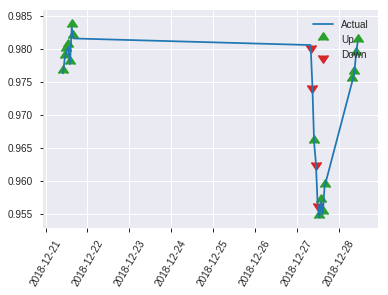


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20668205572259774
RMSE: 0.45462298195603545
LogLoss: 0.6045622529947309
Mean Per-Class Error: 0.29580026455026454
AUC: 0.7505787037037036
pr_auc: 0.7042727596220295
Gini: 0.5011574074074072
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4304025068489179: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   53   0.4732   (53.0/112.0)
1      17   91   0.1574   (17.0/108.0)
Total  76   144  0.3182   (70.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.430403     0.722222  143
max f2                       0.126167     0.847861  198
max f0point5                 0.553134     0.706967  94
max accuracy                 0.553134     0.704545  94
max precision                0.962617     1         0
max recall                   0.0889324    1         207
max specificity              0.962617     1         0
max absolute_mcc             0.553134     0.410513  94
max min_per_class_accuracy   0.536389     0.694444  107
max mean_per_class_accuracy  0.539015     0.7042    104

Gains/Lift Table: Avg response rate: 49.09 %, avg score: 50.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.954121           2.03704   2.03704            1                0.958057   1                           0.958057            0.0277778       0.0277778                  103.704   103.704
    2        0.0227273                   0.947267           2.03704   2.03704            1                0.95166    1                           0.955498            0.0185185       0.0462963                  103.704   103.704
    3        0.0318182                   0.929045           0         1.45503            0                0.94134    0.714286                    0.951453            0               0.0462963                  -100      45.5026
    4        0.0409091                   0.910277           2.03704   1.58436            1                0.919542   0.777778                    0.944362            0.0185185       0.0648148                  103.704   58.4362
    5        0.05                        0.876658           1.01852   1.48148            0.5              0.903007   0.727273                    0.936843            0.00925926      0.0740741                  1.85185   48.1481
    6        0.1                         0.830144           1.48148   1.48148            0.727273         0.860202   0.727273                    0.898522            0.0740741       0.148148                   48.1481   48.1481
    7        0.15                        0.793473           1.66667   1.54321            0.818182         0.809677   0.757576                    0.868907            0.0833333       0.231481                   66.6667   54.321
    8        0.2                         0.759961           1.48148   1.52778            0.727273         0.774681   0.75                        0.84535             0.0740741       0.305556                   48.1481   52.7778
    9        0.3                         0.63288            1.48148   1.51235            0.727273         0.687959   0.742424                    0.792887            0.148148        0.453704                   48.1481   51.2346
    10       0.4                         0.558182           1.2963    1.45833            0.636364         0.591448   0.715909                    0.742527            0.12963         0.583333                   29.6296   45.8333
    11       0.5                         0.535763           1.11111   1.38889            0.545455         0.54594    0.681818                    0.70321             0.111111        0.694444                   11.1111   38.8889
    12       0.6                         0.503491           1.01852   1.32716            0.5              0.522456   0.651515                    0.673084            0.101852        0.796296                   1.85185   32.716
    13       0.7                         0.366976           0.462963  1.2037             0.227273         0.440557   0.590909                    0.639866            0.0462963       0.842593                   -53.7037  20.3704
    14       0.8                         0.212978           0.925926  1.16898            0.454545         0.29889    0.573864                    0.597244            0.0925926       0.935185                   -7.40741  16.8981
    15       0.9                         0.127154           0.462963  1.09053            0.227273         0.171629   0.535354                    0.549953            0.0462963       0.981481                   -53.7037  9.0535
    16       1                           0.041588           0.185185  1                  0.0909091        0.0851112  0.490909                    0.

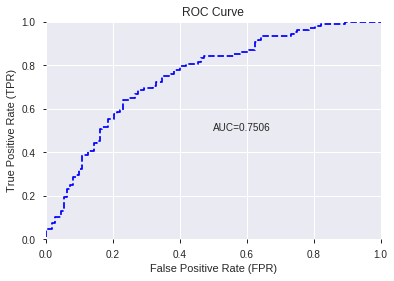

This function is available for GLM models only


--2019-08-28 17:24:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.188
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.188|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


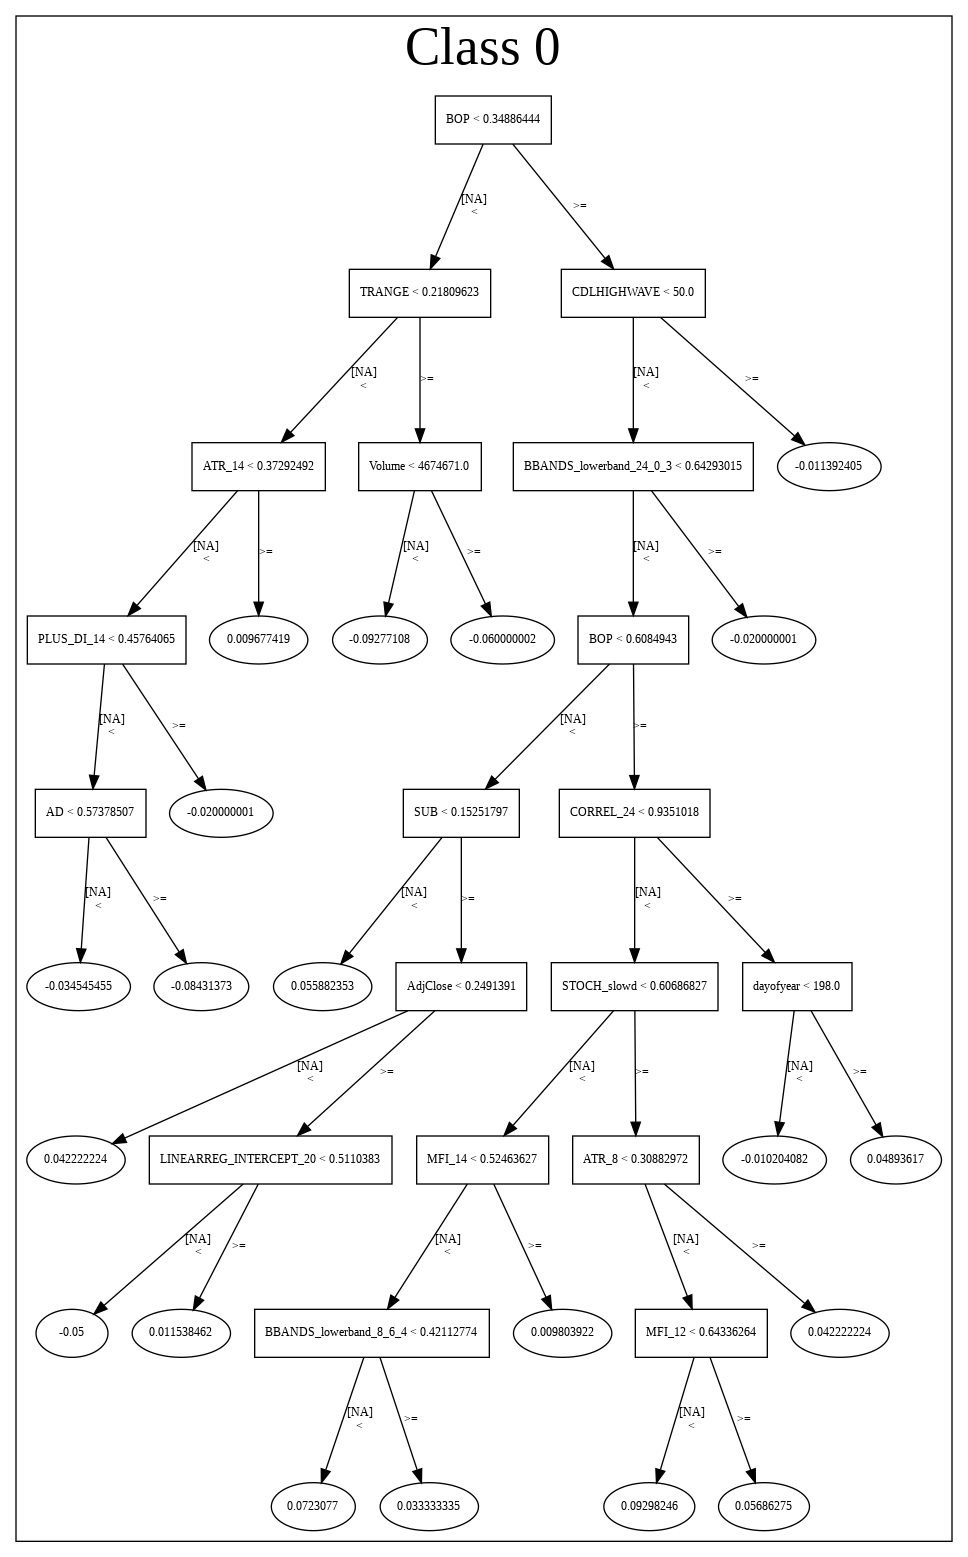

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_171559_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_171559_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8492',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLLONGLINE',
 'CDLHANGINGMAN',
 'SUB',
 'DIV',
 'CDLHAMMER',
 'TRANGE',
 'CDLMARUBOZU',
 'CDLTAKURI',
 'hour',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CCI_20',
 'STOCHF_fastk',
 'CDLSHORTLINE',
 'MINUS_DM_8',
 'STOCHRSI_fastk',
 'WILLR_14',
 'WILLR_12',
 'ULTOSC',
 'CCI_8',
 'CCI_12',
 'WILLR_8',
 'MINUS_DI_8',
 'CCI_14',
 'MOM_30',
 'MOM_14',
 'WILLR_20',
 'ROCP_30',
 'ADOSC',
 'CDLBELTHOLD',
 'ROC_20',
 'ROCR_14',
 'ROCP_8',
 'ROCR_30',
 'ROC_30',
 'ROCR100_30',
 'ROC_14',
 'ROCP_12',
 'ROC_12',
 'ROCR_12',
 'ROCR100_14',
 'RSI_24',
 'ROCP_14',
 'CMO_8',
 'CMO_12',
 'MOM_12',
 'MOM_8',
 'ROCR100_20',
 'CMO_24',
 'RSI_30',
 'MOM_24',
 'ROCR100_12',
 'RSI_8',
 'ROC_24',
 'MOM_20',
 'ROCR100_8',
 'CMO_20',
 'ROC_8',
 'ROCR_8',
 'RSI_20',
 'CMO_30',
 'ROCR_24',
 'ROCR100_24',
 'WILLR_30',
 'RSI_12',
 'RSI_14',
 'CMO_14',
 'ROCR_20',
 'ROCP_24',
 'WILLR_24',
 'ROCP_20']

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_172447_model_1  0.751405  0.607024              0.335979  0.453261  0.205446

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.909365           1.000000    0.122946
1   CDLCLOSINGMARUBOZU             0.395728           0.435170    0.053502
2               CCI_20             0.309411           0.340250    0.041832
3                CCI_8             0.283261           0.311493    0.038297
4        CDLHANGINGMAN             0.257160           0.282790    0.034768
..                 ...                  ...                ...         ...
68          ROCR100_20             0.007107           0.007815    0.000961
69              ROC_14             0.006588           0.007244    0.000891
70          ROCR100_14             0.005083           0.005590    0.000687
71            WILLR_30             0.003829           0.004210    0.000518
72      STOCHRSI_fastk             0.002928           0.003220    0.000396

[73 rows x 4 columns]

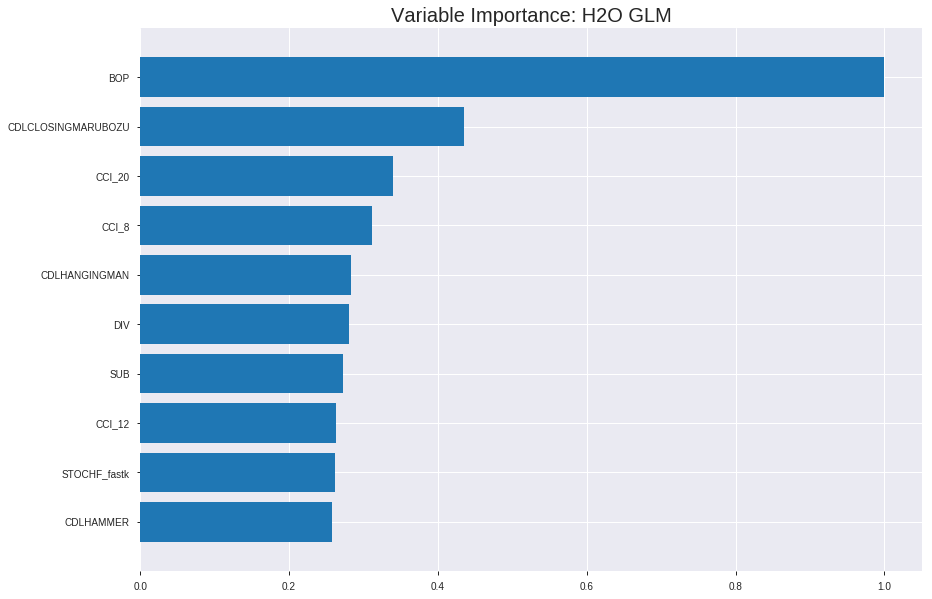

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_172447_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17391046129339768
RMSE: 0.4170257321717662
LogLoss: 0.5194843321074636
Null degrees of freedom: 1536
Residual degrees of freedom: 1463
Null deviance: 2127.2659845544013
Residual deviance: 1596.894836898343
AIC: 1744.894836898343
AUC: 0.8184561993008179
pr_auc: 0.7913374177954988
Gini: 0.6369123986016358
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3433845366245592: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      459  346  0.4298   (346.0/805.0)
1      83   649  0.1134   (83.0/732.0)
Total  542  995  0.2791   (429.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.343385     0.751592  260
max f2                       0.243074     0.853063  305
max f0point5                 0.602099     0.736698  145
max accuracy                 0.509175     0.735849  188
max precision                0.986695     1         0
max recall                   0.0291039    1         391
max specificity              0.986695     1         0
max absolute_mcc             0.343385     0.477493  260
max min_per_class_accuracy   0.493605     0.72795   196
max mean_per_class_accuracy  0.459552     0.735618  211

Gains/Lift Table: Avg response rate: 47.63 %, avg score: 47.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.965563           1.83726    1.83726            0.875            0.973321   0.875                       0.973321            0.0191257       0.0191257                  83.7261   83.7261
    2        0.0201692                   0.95587            2.09973    1.96426            1                0.961203   0.935484                    0.967457            0.0204918       0.0396175                  109.973   96.4261
    3        0.0305791                   0.948014           1.83726    1.92103            0.875            0.95196    0.914894                    0.962182            0.0191257       0.0587432                  83.7261   92.1027
    4        0.0403383                   0.940569           2.09973    1.96426            1                0.94497    0.935484                    0.958017            0.0204918       0.079235                   109.973   96.4261
    5        0.0500976                   0.93255            1.95974    1.96338            0.933333         0.936752   0.935065                    0.953875            0.0191257       0.0983607                  95.9745   96.3381
    6        0.100195                    0.848082           1.90884    1.93611            0.909091         0.900021   0.922078                    0.926948            0.0956284       0.193989                   90.8843   93.6112
    7        0.150293                    0.775986           1.71796    1.86339            0.818182         0.809279   0.887446                    0.887725            0.0860656       0.280055                   71.7958   86.3394
    8        0.20039                     0.729566           1.58161    1.79295            0.753247         0.752487   0.853896                    0.853915            0.079235        0.35929                    58.1612   79.2949
    9        0.299935                    0.642842           1.53705    1.70802            0.732026         0.685876   0.813449                    0.798145            0.153005        0.512295                   53.7055   70.8021
    10       0.40013                     0.564088           1.19984    1.58077            0.571429         0.603628   0.752846                    0.749437            0.120219        0.632514                   19.9844   58.077
    11       0.500325                    0.483623           1.09077    1.48264            0.519481         0.521796   0.706112                    0.70385             0.10929         0.741803                   9.07672   48.2642
    12       0.59987                     0.3903             0.933212   1.39147            0.444444         0.435021   0.66269                     0.659239            0.0928962       0.834699                   -6.67881  39.1468
    13       0.700065                    0.295645           0.858979   1.31526            0.409091         0.34081    0.626394                    0.613665            0.0860656       0.920765                   -14.1021  31.5256
    14       0.79961                     0.208376           0.411711   1.20277            0.196078         0.253844   0.572823                    0.56887             0.0409836       0.961749                   -58.8289  20.2773
    15       0.899805                    0.113109           0.299961   1.10224            0.142857         0.161913   0.524946                    0.523555            0.0300546       0.991803                   -70.0039  10.2243
    16       1                           0.00474381         0.0818075  1                  0.038961         0.0514533  0.476252  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18481371326046386
RMSE: 0.4298996548736273
LogLoss: 0.5430727655953835
Null degrees of freedom: 438
Residual degrees of freedom: 365
Null deviance: 607.3882128516068
Residual deviance: 476.81788819274675
AIC: 624.8178881927468
AUC: 0.7926968864468865
pr_auc: 0.7865913939821487
Gini: 0.585393772893773
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3171432537539008: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      126  105  0.4545   (105.0/231.0)
1      25   183  0.1202   (25.0/208.0)
Total  151  288  0.2961   (130.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.317143     0.737903  260
max f2                       0.12055      0.836735  357
max f0point5                 0.660604     0.704114  99
max accuracy                 0.434994     0.719818  199
max precision                0.982674     1         0
max recall                   0.0668477    1         377
max specificity              0.982674     1         0
max absolute_mcc             0.317143     0.447002  260
max min_per_class_accuracy   0.441618     0.709957  195
max mean_per_class_accuracy  0.434994     0.720363  199

Gains/Lift Table: Avg response rate: 47.38 %, avg score: 44.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.946278           2.11058   2.11058            1                0.955707   1                           0.955707            0.0240385       0.0240385                  111.058   111.058
    2        0.0205011                   0.935054           2.11058   2.11058            1                0.940326   1                           0.948871            0.0192308       0.0432692                  111.058   111.058
    3        0.0318907                   0.921105           2.11058   2.11058            1                0.925966   1                           0.940691            0.0240385       0.0673077                  111.058   111.058
    4        0.0410023                   0.909025           2.11058   2.11058            1                0.915553   1                           0.935104            0.0192308       0.0865385                  111.058   111.058
    5        0.0501139                   0.895905           2.11058   2.11058            1                0.904173   1                           0.929481            0.0192308       0.105769                   111.058   111.058
    6        0.100228                    0.795915           2.01464   2.06261            0.954545         0.833878   0.977273                    0.881679            0.100962        0.206731                   101.464   106.261
    7        0.150342                    0.742312           1.82277   1.98266            0.863636         0.763632   0.939394                    0.84233             0.0913462       0.298077                   82.2771   98.2663
    8        0.200456                    0.69062            1.43903   1.84675            0.681818         0.723694   0.875                       0.812671            0.0721154       0.370192                   43.903    84.6755
    9        0.300683                    0.615669           1.10326   1.59892            0.522727         0.65316    0.757576                    0.759501            0.110577        0.480769                   10.3256   59.8922
    10       0.400911                    0.520441           1.29513   1.52297            0.613636         0.563631   0.721591                    0.710533            0.129808        0.610577                   29.5127   52.2973
    11       0.501139                    0.43302            1.19919   1.45822            0.568182         0.474364   0.690909                    0.663299            0.120192        0.730769                   19.9191   45.8217
    12       0.599089                    0.36157            0.834414  1.35623            0.395349         0.402202   0.642586                    0.62061             0.0817308       0.8125                     -16.5586  35.6226
    13       0.699317                    0.273799           0.911385  1.29247            0.431818         0.319703   0.612378                    0.577484            0.0913462       0.903846                   -8.86145  29.2471
    14       0.799544                    0.184079           0.335774  1.17254            0.159091         0.219378   0.555556                    0.532593            0.0336538       0.9375                     -66.4226  17.2543
    15       0.899772                    0.112872           0.479677  1.09536            0.227273         0.152409   0.518987                    0.490243            0.0480769       0.985577                   -52.0323  9.53627
    16       1                           0.00618644         0.143903  1                  0.0681818        0.0599677  0.473804                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 17:24:48  0.000 sec   2            .23E2     74            1.354696279047545   1.3621066255096277
     2019-08-28 17:24:48  0.018 sec   4            .14E2     74            1.3427740905947718  1.3527654608590585
     2019-08-28 17:24:48  0.036 sec   6            .89E1     74            1.3274502431977186  1.3402004410249853
     2019-08-28 17:24:48  0.055 sec   8            .55E1     74            1.3079845390088292  1.3235529859664295
     2019-08-28 17:24:48  0.080 sec   10           .34E1     74            1.2837067854374877  1.3020538636795411
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 17:24:48  0.382 sec   40           .27E-2    74            1.0377837560126522  1.086654395874774
     2019-08-28 17:24:48  0.402 sec   42           .17E-2    74            1.0368241772520246  1.0874849420476878
     2019-08-28 17:24:48  0.421 sec   44           .1E-2     74            1.0360317717163072  1.088548724877143
     2019-08-28 17:24:48  0.441 sec   46           .65E-3    74            1.0354550429156217  1.0896614093364834
     2019-08-28 17:24:48  0.462 sec   48           .4E-3     74            1.034854576892884   1.0910008147296062


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7045454545454546)

('F1', 0.7292418772563177)

('auc', 0.7514054232804233)

('logloss', 0.6070236058864953)

('mean_per_class_error', 0.29646164021164023)

('rmse', 0.4532613288410293)

('mse', 0.2054458322227357)

glm prediction progress: |████████████████████████████████████████████████| 100%


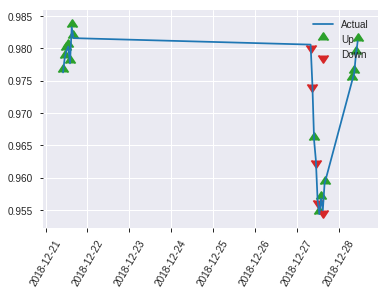


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2054458322227357
RMSE: 0.4532613288410293
LogLoss: 0.6070236058864953
Null degrees of freedom: 219
Residual degrees of freedom: 146
Null deviance: 305.10134599958155
Residual deviance: 267.0903865900579
AIC: 415.0903865900579
AUC: 0.7514054232804233
pr_auc: 0.7045491356646679
Gini: 0.5028108465608465
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2505305762536112: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      44   68   0.6071   (68.0/112.0)
1      7    101  0.0648   (7.0/108.0)
Total  51   169  0.3409   (75.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.250531     0.729242  168
max f2                       0.130882     0.843949  195
max f0point5                 0.570324     0.705645  96
max accuracy                 0.570324     0.704545  96
max precision                0.982975     1         0
max recall                   0.0499515    1         207
max specificity              0.982975     1         0
max absolute_mcc             0.570324     0.409882  96
max min_per_class_accuracy   0.523325     0.678571  109
max mean_per_class_accuracy  0.570324     0.703538  96

Gains/Lift Table: Avg response rate: 49.09 %, avg score: 49.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.969029           2.03704   2.03704            1                0.975765   1                           0.975765            0.0277778       0.0277778                  103.704   103.704
    2        0.0227273                   0.96383            1.01852   1.62963            0.5              0.965325   0.8                         0.971589            0.00925926      0.037037                   1.85185   62.963
    3        0.0318182                   0.953622           1.01852   1.45503            0.5              0.958096   0.714286                    0.967734            0.00925926      0.0462963                  1.85185   45.5026
    4        0.0409091                   0.938861           1.01852   1.35802            0.5              0.950163   0.666667                    0.963829            0.00925926      0.0555556                  1.85185   35.8025
    5        0.05                        0.924051           1.01852   1.2963             0.5              0.93374    0.636364                    0.958359            0.00925926      0.0648148                  1.85185   29.6296
    6        0.1                         0.835144           1.85185   1.57407            0.909091         0.883633   0.772727                    0.920996            0.0925926       0.157407                   85.1852   57.4074
    7        0.15                        0.806252           1.85185   1.66667            0.909091         0.823696   0.818182                    0.888562            0.0925926       0.25                       85.1852   66.6667
    8        0.2                         0.73802            1.66667   1.66667            0.818182         0.773989   0.818182                    0.859919            0.0833333       0.333333                   66.6667   66.6667
    9        0.3                         0.658112           1.2037    1.51235            0.590909         0.699761   0.742424                    0.806533            0.12037         0.453704                   20.3704   51.2346
    10       0.4                         0.596026           1.2963    1.45833            0.636364         0.627556   0.715909                    0.761789            0.12963         0.583333                   29.6296   45.8333
    11       0.5                         0.523077           1.01852   1.37037            0.5              0.558636   0.672727                    0.721158            0.101852        0.685185                   1.85185   37.037
    12       0.6                         0.402861           1.01852   1.31173            0.5              0.467135   0.643939                    0.678821            0.101852        0.787037                   1.85185   31.1728
    13       0.7                         0.293394           0.740741  1.23016            0.363636         0.356311   0.603896                    0.632748            0.0740741       0.861111                   -25.9259  23.0159
    14       0.8                         0.224854           0.740741  1.16898            0.363636         0.257827   0.573864                    0.585883            0.0740741       0.935185                   -25.9259  16.8981
    15       0.9                         0.104745           0.462963  1.09053            0.227273         0.170326   0.535354                    0.53971             0.0462963       0.981481                   -53.7037  9.0535
    16       1                           0.0194703          0.185185  1                  0.0909091        0.0549215  0.490909                    0.

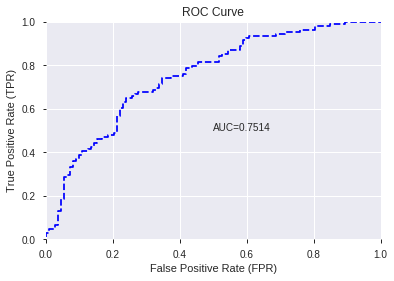

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


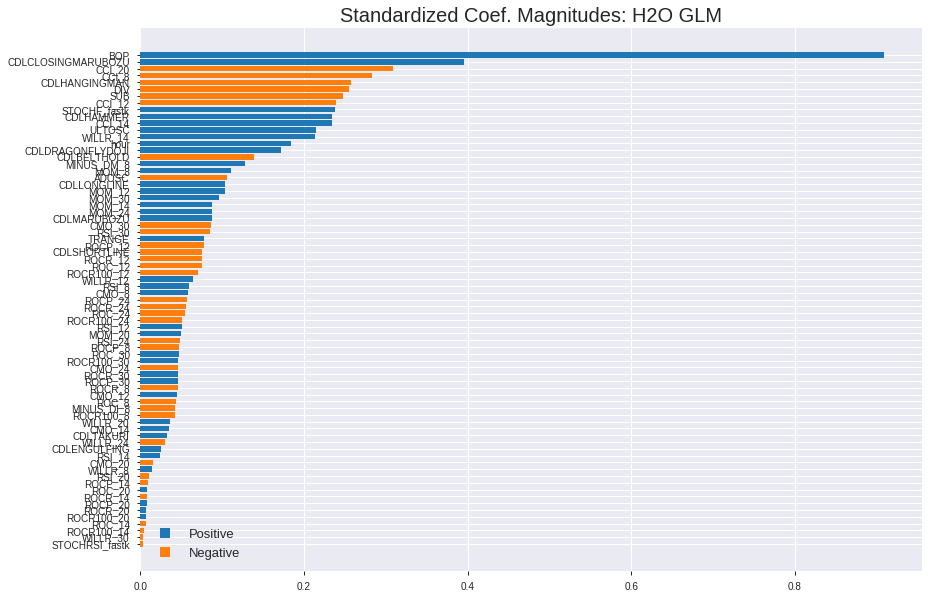

'log_likelihood'
--2019-08-28 17:24:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.16.48
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.16.48|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


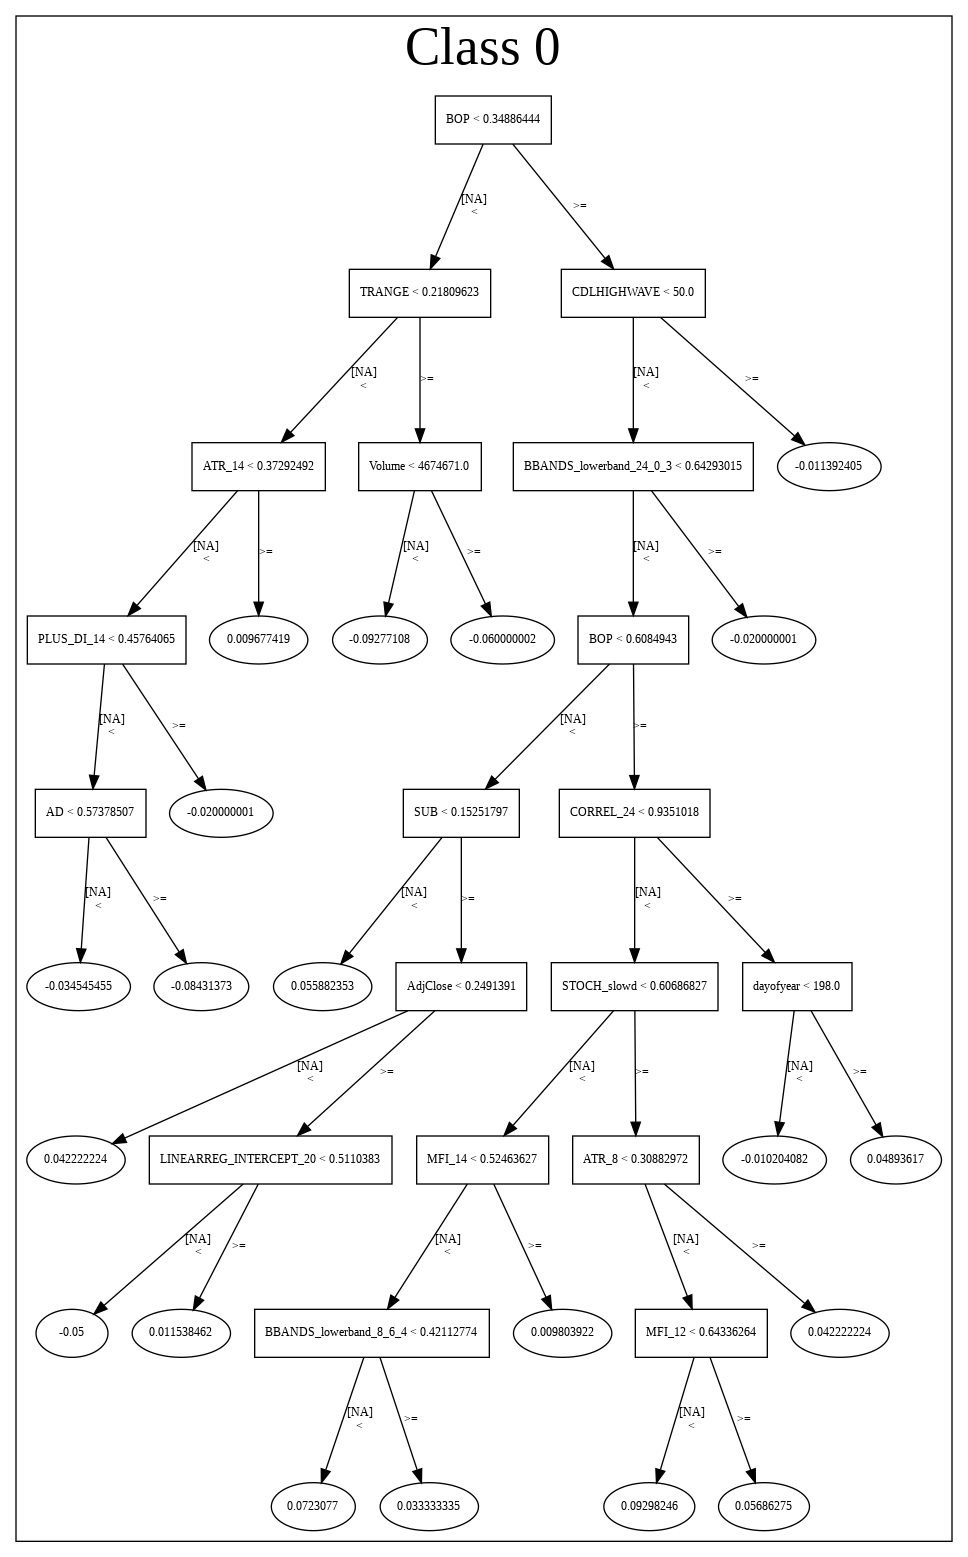

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_172447_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_172447_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8492',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CCI_20',
 'CCI_8',
 'CDLHANGINGMAN',
 'DIV',
 'SUB',
 'CCI_12',
 'STOCHF_fastk',
 'CDLHAMMER',
 'CCI_14',
 'ULTOSC',
 'WILLR_14',
 'hour',
 'CDLDRAGONFLYDOJI',
 'CDLBELTHOLD',
 'MINUS_DM_8',
 'MOM_8',
 'ADOSC',
 'CDLLONGLINE',
 'MOM_12',
 'MOM_30',
 'MOM_14',
 'MOM_24',
 'CDLMARUBOZU',
 'CMO_30',
 'RSI_30',
 'TRANGE',
 'ROCP_12',
 'CDLSHORTLINE',
 'ROCR_12',
 'ROC_12',
 'ROCR100_12',
 'WILLR_12',
 'RSI_8',
 'CMO_8',
 'ROCP_24',
 'ROCR_24',
 'ROC_24',
 'ROCR100_24',
 'RSI_12',
 'MOM_20',
 'RSI_24',
 'ROCP_8',
 'ROC_30',
 'ROCR100_30',
 'CMO_24',
 'ROCR_30',
 'ROCP_30',
 'ROCR_8',
 'CMO_12',
 'ROC_8',
 'MINUS_DI_8',
 'ROCR100_8',
 'WILLR_20',
 'CMO_14',
 'CDLTAKURI',
 'WILLR_24',
 'CDLENGULFING',
 'RSI_14',
 'CMO_20',
 'WILLR_8',
 'RSI_20',
 'ROCP_14',
 'ROC_20',
 'ROCR_14',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'ROC_14',
 'ROCR100_14',
 'WILLR_30',
 'STOCHRSI_fastk']

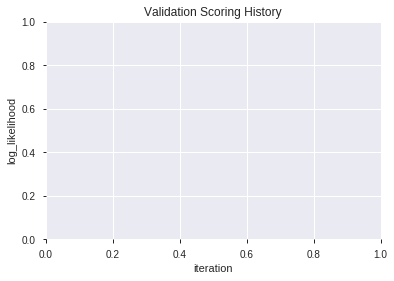

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_172505_model_3  0.747106  0.602444              0.349537  0.454837  0.206877
1  XGBoost_grid_1_AutoML_20190828_172505_model_2  0.740658  0.608558              0.324074  0.457759  0.209544
2               XGBoost_3_AutoML_20190828_172505  0.740327  0.608494              0.358300  0.457559  0.209360
3  XGBoost_grid_1_AutoML_20190828_172505_model_4  0.736276  0.609202              0.298942  0.458635  0.210346
4  XGBoost_grid_1_AutoML_20190828_172505_model_6  0.735202  0.614318              0.340939  0.460968  0.212492
5  XGBoost_grid_1_AutoML_20190828_172505_model_1  0.733962  0.625449              0.375661  0.463321  0.214666
6               XGBoost_2_AutoML_20190828_172505  0.733135  0.611481              0.358796  0.459851  0.211463
7               XGBoost_1_AutoML_20190828_172505  0.729415  0.616934              0.336640  0.462735  0.214124
8  XGBoost_grid_1_AutoML_20190828_172505_model_7  0.721644  0.626751              0.349702  0.465566  0.216752
9  XGBoost_grid_1_AutoML_20190828_172505_model_5  0.716601  0.654530              0.328208  0.477351  0.227864

variable  relative_importance  scaled_importance  percentage
0                  BOP          1989.072510           1.000000    0.251001
1         STOCHF_fastk           487.524292           0.245101    0.061521
2               TRANGE           360.511597           0.181246    0.045493
3                  DIV           332.078552           0.166951    0.041905
4   CDLCLOSINGMARUBOZU           267.608307           0.134539    0.033770
..                 ...                  ...                ...         ...
66        CDLENGULFING             7.583004           0.003812    0.000957
67          ROCR100_12             7.022948           0.003531    0.000886
68          ROCR100_24             6.080912           0.003057    0.000767
69          ROCR100_20             5.783264           0.002908    0.000730
70             ROCR_14             1.884749           0.000948    0.000238

[71 rows x 4 columns]

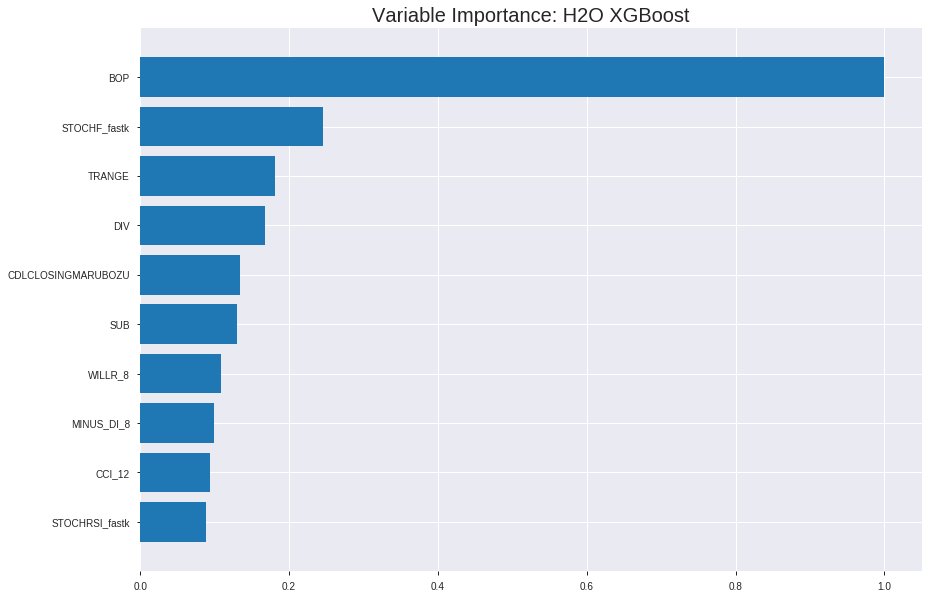

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_172505_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1206377043279216
RMSE: 0.347329388805384
LogLoss: 0.3937348778216977
Mean Per-Class Error: 0.15210009164036253
AUC: 0.934360044801955
pr_auc: 0.9297992267249947
Gini: 0.86872008960391
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4567389239867528: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      632  173  0.2149   (173.0/805.0)
1      66   666  0.0902   (66.0/732.0)
Total  698  839  0.1555   (239.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456739     0.847868  219
max f2                       0.248201     0.90089   301
max f0point5                 0.617272     0.871212  147
max accuracy                 0.512661     0.847105  194
max precision                0.96201      1         0
max recall                   0.166512     1         335
max specificity              0.96201      1         0
max absolute_mcc             0.460524     0.697399  217
max min_per_class_accuracy   0.517964     0.845628  192
max mean_per_class_accuracy  0.460524     0.8479    217

Gains/Lift Table: Avg response rate: 47.63 %, avg score: 47.66 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.939536           2.09973    2.09973            1                0.948308   1                           0.948308            0.0218579       0.0218579                  109.973   109.973
    2        0.0201692                   0.929304           2.09973    2.09973            1                0.934105   1                           0.941436            0.0204918       0.0423497                  109.973   109.973
    3        0.0305791                   0.915609           2.09973    2.09973            1                0.921299   1                           0.934581            0.0218579       0.0642077                  109.973   109.973
    4        0.0403383                   0.906923           2.09973    2.09973            1                0.910743   1                           0.928814            0.0204918       0.0846995                  109.973   109.973
    5        0.0500976                   0.884922           2.09973    2.09973            1                0.897406   1                           0.922695            0.0204918       0.105191                   109.973   109.973
    6        0.100195                    0.819818           2.07246    2.08609            0.987013         0.848198   0.993506                    0.885447            0.103825        0.209016                   107.246   108.609
    7        0.150293                    0.770121           2.04519    2.07246            0.974026         0.793524   0.987013                    0.854806            0.102459        0.311475                   104.519   107.246
    8        0.20039                     0.740896           2.07246    2.07246            0.987013         0.755435   0.987013                    0.829963            0.103825        0.415301                   107.246   107.246
    9        0.299935                    0.671655           1.88015    2.00863            0.895425         0.708574   0.956616                    0.789676            0.187158        0.602459                   88.0148   100.863
    10       0.40013                     0.59682            1.47254    1.87439            0.701299         0.633476   0.892683                    0.750562            0.147541        0.75                       47.2536   87.439
    11       0.500325                    0.49966            1.11804    1.72292            0.532468         0.548934   0.820546                    0.710184            0.112022        0.862022                   11.8036   72.2923
    12       0.59987                     0.398707           0.754804   1.56227            0.359477         0.450334   0.744035                    0.667064            0.0751366       0.937158                   -24.5196  56.227
    13       0.700065                    0.279942           0.449941   1.40307            0.214286         0.34198    0.668216                    0.620537            0.045082        0.98224                    -55.0059  40.307
    14       0.79961                     0.172865           0.164684   1.2489             0.0784314        0.223036   0.594793                    0.571051            0.0163934       0.998634                   -83.5316  24.8902
    15       0.899805                    0.0950291          0.0136346  1.11135            0.00649351       0.13224    0.529284                    0.522189            0.00136612      1                          -98.6365  11.1352
    16       1                           0.0298465          0          1                  0                0.0669887  0.476252    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1768170047045124
RMSE: 0.42049614112915756
LogLoss: 0.5253670996482787
Mean Per-Class Error: 0.2522165334665334
AUC: 0.8127497502497503
pr_auc: 0.7892039497736519
Gini: 0.6254995004995005
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3354506492614746: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      143  88   0.381    (88.0/231.0)
1      32   176  0.1538   (32.0/208.0)
Total  175  264  0.2733   (120.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.335451     0.745763  242
max f2                       0.18712      0.855319  312
max f0point5                 0.504123     0.739087  183
max accuracy                 0.504123     0.749431  183
max precision                0.943884     1         0
max recall                   0.0620855    1         385
max specificity              0.943884     1         0
max absolute_mcc             0.504123     0.496851  183
max min_per_class_accuracy   0.487143     0.740385  193
max mean_per_class_accuracy  0.504123     0.747783  183

Gains/Lift Table: Avg response rate: 47.38 %, avg score: 44.03 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.927542           2.11058    2.11058            1                0.937064   1                           0.937064            0.0240385       0.0240385                  111.058   111.058
    2        0.0205011                   0.916606           2.11058    2.11058            1                0.920784   1                           0.929828            0.0192308       0.0432692                  111.058   111.058
    3        0.0318907                   0.899016           2.11058    2.11058            1                0.908312   1                           0.922144            0.0240385       0.0673077                  111.058   111.058
    4        0.0410023                   0.868874           2.11058    2.11058            1                0.880173   1                           0.912817            0.0192308       0.0865385                  111.058   111.058
    5        0.0501139                   0.839655           2.11058    2.11058            1                0.854754   1                           0.90226             0.0192308       0.105769                   111.058   111.058
    6        0.100228                    0.771538           1.82277    1.96667            0.863636         0.810523   0.931818                    0.856391            0.0913462       0.197115                   82.2771   96.6674
    7        0.150342                    0.718115           1.53497    1.82277            0.727273         0.736557   0.863636                    0.816447            0.0769231       0.274038                   53.4965   82.2771
    8        0.200456                    0.686071           1.53497    1.75082            0.727273         0.704019   0.829545                    0.78834             0.0769231       0.350962                   53.4965   75.0819
    9        0.300683                    0.610204           1.39106    1.6309             0.659091         0.651804   0.772727                    0.742828            0.139423        0.490385                   39.1062   63.09
    10       0.400911                    0.537149           1.487      1.59492            0.704545         0.57593    0.755682                    0.701103            0.149038        0.639423                   48.6997   59.4925
    11       0.501139                    0.462939           1.19919    1.51578            0.568182         0.505919   0.718182                    0.662067            0.120192        0.759615                   19.9191   51.5778
    12       0.599089                    0.335642           0.834414   1.40438            0.395349         0.395036   0.665399                    0.618408            0.0817308       0.841346                   -16.5586  40.4376
    13       0.699317                    0.254783           0.719515   1.30622            0.340909         0.298716   0.618893                    0.572589            0.0721154       0.913462                   -28.0485  30.622
    14       0.799544                    0.158633           0.527644   1.20862            0.25             0.207772   0.57265                     0.526857            0.0528846       0.966346                   -47.2356  20.8621
    15       0.899772                    0.0921845          0.239838   1.10071            0.113636         0.121532   0.521519                    0.481706            0.0240385       0.990385                   -76.0162  10.0706
    16       1                           0.0298249          0.0959353  1                  0.0454545        0.0684712  0.473804    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:25:13  2.679 sec   0                  0.5              0.693147            0.5             0                  1                0.523748                         0.5                0.693147              0.5               0                    1                  0.526196
    2019-08-28 17:25:13  2.821 sec   5                  0.467578         0.629878            0.848272        0.816703           2.09973          0.235524                         0.472957           0.640053              0.795319          0.76733              2.11058            0.284738
    2019-08-28 17:25:13  2.902 sec   10                 0.444596         0.585675            0.862668        0.842513           2.09973          0.238126                         0.456359           0.607291              0.793113          0.768715             2.11058            0.298405
    2019-08-28 17:25:13  2.978 sec   15                 0.427043         0.551651            0.873061        0.858101           2.09973          0.236825                         0.44653            0.58709               0.794133          0.767662             2.11058            0.29385
    2019-08-28 17:25:14  3.062 sec   20                 0.41344          0.524775            0.878793        0.866077           2.09973          0.212101                         0.438372           0.569833              0.799721          0.773936             2.11058            0.29385
    2019-08-28 17:25:14  3.157 sec   25                 0.403568         0.50447             0.884117        0.872082           2.09973          0.217957                         0.434618           0.560731              0.797536          0.773001             2.11058            0.289294
    2019-08-28 17:25:14  3.239 sec   30                 0.395628         0.487947            0.88836         0.874969           2.09973          0.214704                         0.430331           0.55095               0.801521          0.778404             2.11058            0.291572
    2019-08-28 17:25:14  3.325 sec   35                 0.387665         0.471484            0.894779        0.886827           2.09973          0.214053                         0.425855           0.541027              0.806745          0.7828               2.11058            0.29385
    2019-08-28 17:25:14  3.408 sec   40                 0.380839         0.45812             0.901887        0.895133           2.09973          0.204294                         0.424749           0.537721              0.807432          0.78113              2.11058            0.29385
    2019-08-28 17:25:14  3.496 sec   45                 0.375295         0.446361            0.90671         0.90152            2.09973          0.203643                         0.423184           0.53344               0.80994           0.783913             2.11058            0.291572
    2019-08-28 17:25:14  3.594 sec   50                 0.370975         0.437325            0.910267        0.904907           2.09973          0.187378                         0.422079           0.530408              0.810887          0.784629             2.11058            0.28246
    2019-08-28 17:25:14  3.686 sec   55                 0.367357         0.429766            0.91295         0.907575           2.09973          0.180221                         0.421894           0.529238              0.811064          0.7852

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
BOP                 1989.072509765625      1.0                    0.25100112192431145
STOCHF_fastk        487.5242919921875      0.24510131712072836    0.061520705582429266
TRANGE              360.5115966796875      0.1812460807284331     0.04549296960722103
DIV                 332.07855224609375     0.16695145632736286    0.04190500284506576
CDLCLOSINGMARUBOZU  267.6083068847656      0.13453924156656222    0.033769500576053074
---                 ---                    ---                    ---
CDLENGULFING        7.583004474639893      0.0038123318468331795  0.0009568995707029104
ROCR100_12          7.022948265075684      0.0035307653343935696  0.0008862260601842526
ROCR100_24          6.080911636352539      0.0030571593576893086  0.0007673504286814238
ROCR100_20          5.78326416015625       0.0029075180174490973  0.0007297902843948731
ROCR_14             1.884748935699463      0.0009475516485427398  0.00023783652686545855


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6863636363636364)

('F1', 0.7194244604316546)

('auc', 0.7471064814814815)

('logloss', 0.6024436972008219)

('mean_per_class_error', 0.3128306878306878)

('rmse', 0.4548370208303235)

('mse', 0.20687671551780415)

xgboost prediction progress: |████████████████████████████████████████████| 100%


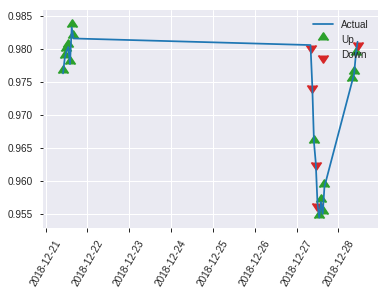


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20687671551780415
RMSE: 0.4548370208303235
LogLoss: 0.6024436972008219
Mean Per-Class Error: 0.3128306878306878
AUC: 0.7471064814814815
pr_auc: 0.7107392092896315
Gini: 0.494212962962963
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2393418401479721: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      42   70   0.625    (70.0/112.0)
1      8    100  0.0741   (8.0/108.0)
Total  50   170  0.3545   (78.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.239342     0.719424  169
max f2                       0.119652     0.850556  196
max f0point5                 0.658364     0.692935  64
max accuracy                 0.507808     0.686364  118
max precision                0.754329     0.882353  33
max recall                   0.0642025    1         215
max specificity              0.947199     0.991071  0
max absolute_mcc             0.658364     0.380457  64
max min_per_class_accuracy   0.524583     0.660714  109
max mean_per_class_accuracy  0.507808     0.687169  118

Gains/Lift Table: Avg response rate: 49.09 %, avg score: 48.39 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.937067           1.35802    1.35802            0.666667         0.940952   0.666667                    0.940952            0.0185185       0.0185185                  35.8025   35.8025
    2        0.0227273                   0.925129           2.03704    1.62963            1                0.932333   0.8                         0.937504            0.0185185       0.037037                   103.704   62.963
    3        0.0318182                   0.906811           1.01852    1.45503            0.5              0.915311   0.714286                    0.931164            0.00925926      0.0462963                  1.85185   45.5026
    4        0.0409091                   0.89498            2.03704    1.58436            1                0.899933   0.777778                    0.924224            0.0185185       0.0648148                  103.704   58.4362
    5        0.05                        0.884419           1.01852    1.48148            0.5              0.894394   0.727273                    0.9188              0.00925926      0.0740741                  1.85185   48.1481
    6        0.1                         0.780042           1.85185    1.66667            0.909091         0.831908   0.818182                    0.875354            0.0925926       0.166667                   85.1852   66.6667
    7        0.15                        0.754532           2.03704    1.79012            1                0.765729   0.878788                    0.838812            0.101852        0.268519                   103.704   79.0123
    8        0.2                         0.721379           1.2963     1.66667            0.636364         0.743715   0.818182                    0.815038            0.0648148       0.333333                   29.6296   66.6667
    9        0.3                         0.651547           1.38889    1.57407            0.681818         0.688918   0.772727                    0.772998            0.138889        0.472222                   38.8889   57.4074
    10       0.4                         0.583067           1.01852    1.43519            0.5              0.619695   0.704545                    0.734672            0.101852        0.574074                   1.85185   43.5185
    11       0.5                         0.520195           0.925926   1.33333            0.454545         0.5482     0.654545                    0.697378            0.0925926       0.666667                   -7.40741  33.3333
    12       0.6                         0.419496           0.925926   1.26543            0.454545         0.482748   0.621212                    0.661606            0.0925926       0.759259                   -7.40741  26.5432
    13       0.7                         0.304805           0.925926   1.21693            0.454545         0.359326   0.597403                    0.618423            0.0925926       0.851852                   -7.40741  21.6931
    14       0.8                         0.223977           0.925926   1.18056            0.454545         0.260454   0.579545                    0.573677            0.0925926       0.944444                   -7.40741  18.0556
    15       0.9                         0.11897            0.462963   1.10082            0.227273         0.163969   0.540404                    0.528154            0.0462963       0.990741                   -53.7037  10.0823
    16       1                           0.0451025          0.0925926  1                  0.0454545        0.0853025  0.490909  

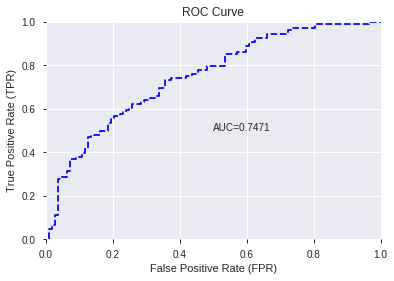

This function is available for GLM models only


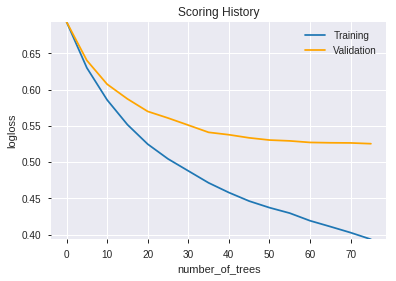

--2019-08-28 17:25:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.227.200
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.227.200|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

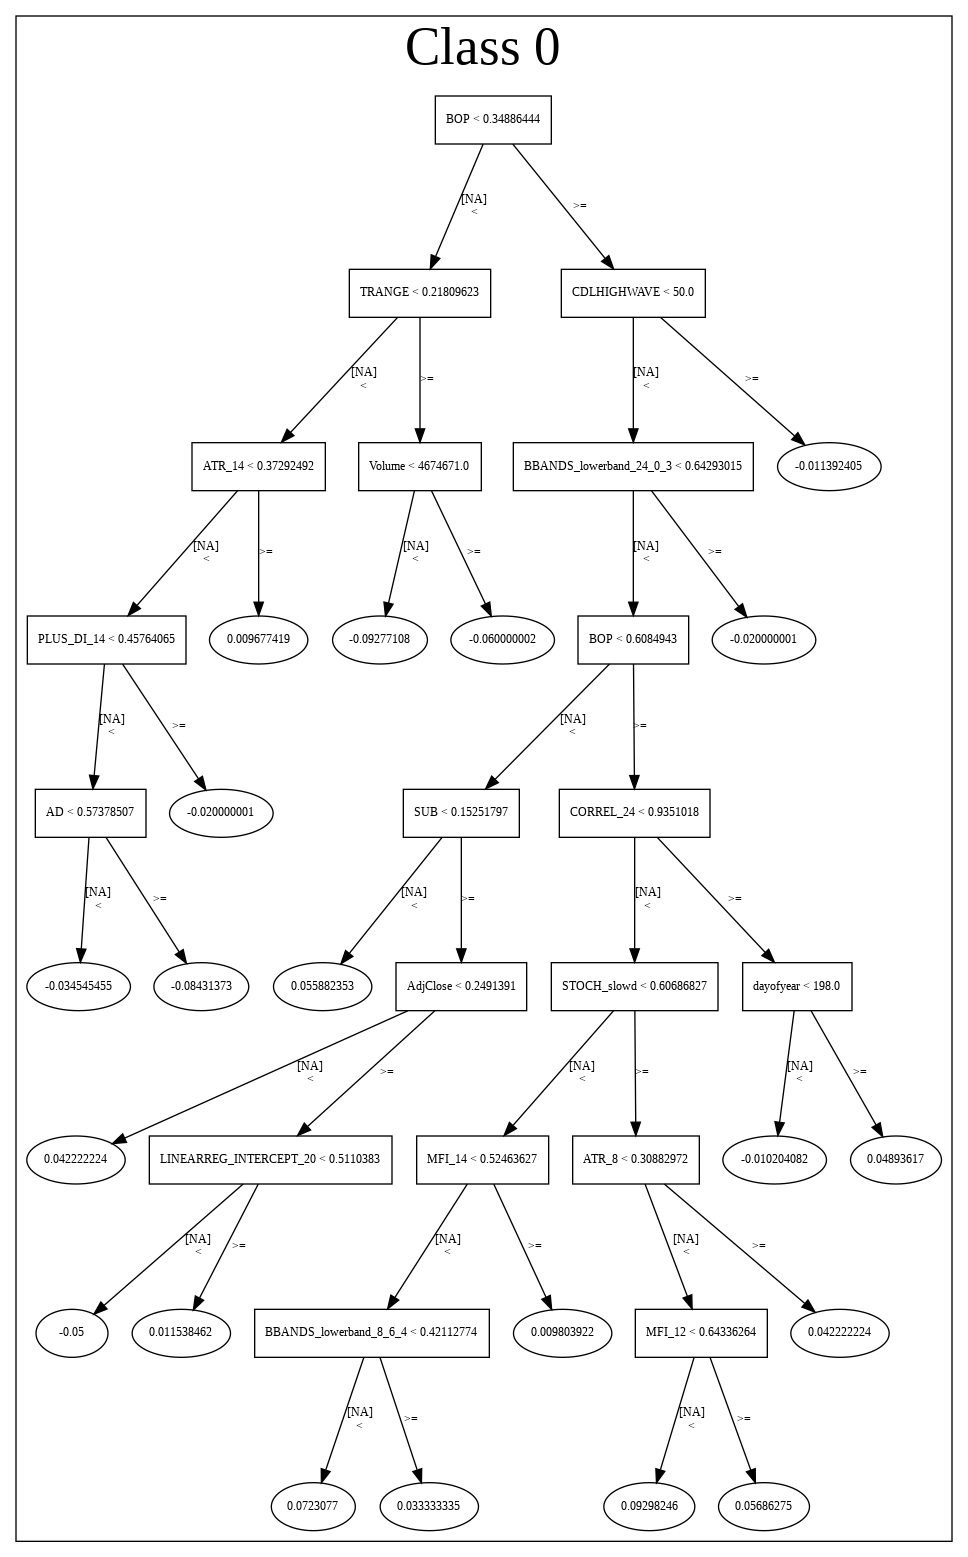

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_172505_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_172505_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8492',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'WILLR_8',
 'MINUS_DI_8',
 'CCI_12',
 'STOCHRSI_fastk',
 'MINUS_DM_8',
 'CCI_20',
 'hour',
 'WILLR_24',
 'CCI_8',
 'MOM_8',
 'WILLR_14',
 'ADOSC',
 'MOM_24',
 'WILLR_12',
 'MOM_12',
 'CDLLONGLINE',
 'ROC_30',
 'ROC_8',
 'ULTOSC',
 'MOM_30',
 'WILLR_30',
 'MOM_14',
 'CMO_30',
 'CDLHAMMER',
 'CCI_14',
 'CMO_12',
 'MOM_20',
 'ROC_12',
 'ROC_20',
 'ROC_24',
 'ROC_14',
 'WILLR_20',
 'CMO_8',
 'CMO_20',
 'CMO_24',
 'ROCP_20',
 'RSI_8',
 'RSI_30',
 'CDLDRAGONFLYDOJI',
 'ROCP_30',
 'ROCP_14',
 'ROCP_24',
 'CDLSHORTLINE',
 'ROCR_8',
 'RSI_20',
 'RSI_14',
 'ROCR_24',
 'RSI_12',
 'CMO_14',
 'ROCR100_8',
 'CDLTAKURI',
 'ROCR_20',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_30',
 'ROCR_30',
 'CDLHANGINGMAN',
 'ROCP_8',
 'CDLBELTHOLD',
 'RSI_24',
 'CDLENGULFING',
 'ROCR100_12',
 'ROCR100_24',
 'ROCR100_20',
 'ROCR_14']

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

59

['BBANDS_upperband_20_1_5',
 'MA_24_7',
 'BBANDS_upperband_30_7_4',
 'BOP',
 'MINUS_DM_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'aroonup_12',
 'AROONOSC_12',
 'CCI_12',
 'MFI_12',
 'PLUS_DM_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'AROONOSC_14',
 'CCI_14',
 'MACDFIX_14',
 'PLUS_DI_14',
 'WILLR_14',
 'aroonup_20',
 'AROONOSC_20',
 'PLUS_DM_20',
 'ADX_24',
 'aroonup_24',
 'CCI_24',
 'DX_24',
 'MFI_24',
 'MOM_24',
 'CCI_30',
 'DX_30',
 'PLUS_DI_30',
 'RSI_30',
 'WILLR_30',
 'MACDEXT_hist',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ATR_8',
 'NATR_8',
 'NATR_12',
 'NATR_20',
 'ATR_24',
 'AVGPRICE',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'BETA_8',
 'STDDEV_8',
 'VAR_8',
 'BETA_12',
 'LINEARREG_ANGLE_12',
 'STDDEV_12',
 'VAR_14']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_172646_model_3  0.742642  0.714847              0.302249  0.482249  0.232564
1  DeepLearning_grid_1_AutoML_20190828_172646_model_6  0.737765  0.614731              0.318783  0.458681  0.210388
2  DeepLearning_grid_1_AutoML_20190828_172646_model_5  0.736524  0.629040              0.319775  0.464028  0.215322
3  DeepLearning_grid_1_AutoML_20190828_172646_model_8  0.724124  0.634041              0.323909  0.463613  0.214937
4  DeepLearning_grid_1_AutoML_20190828_172646_model_9  0.720982  0.634508              0.366898  0.465433  0.216628
5  DeepLearning_grid_1_AutoML_20190828_172646_model_7  0.709573  0.700227              0.371362  0.480470  0.230852
6               DeepLearning_1_AutoML_20190828_172646  0.704200  0.722878              0.353175  0.488477  0.238609
7  DeepLearning_grid_1_AutoML_20190828_172646_model_2  0.703786  0.710442              0.354663  0.488467  0.238600
8  DeepLearning_grid_1_AutoML_20190828_172646_model_1  0.701637  0.993947              0.375661  0.526102  0.276783
9  DeepLearning_grid_1_AutoML_20190828_172646_model_4  0.694031  0.861238              0.354497  0.510046  0.260147

variable  relative_importance  scaled_importance  percentage
0        CDLCLOSINGMARUBOZU             1.000000           1.000000    0.038278
1                       BOP             0.684585           0.684585    0.026204
2               CDLLONGLINE             0.563312           0.563312    0.021562
3            STOCHRSI_fastk             0.517295           0.517295    0.019801
4                   BETA_12             0.508717           0.508717    0.019472
5            STOCHRSI_fastd             0.478164           0.478164    0.018303
6              STOCHF_fastd             0.465792           0.465792    0.017829
7                aroonup_12             0.465337           0.465337    0.017812
8                     VAR_8             0.462691           0.462691    0.017711
9               AROONOSC_14             0.461978           0.461978    0.017683
10                STDDEV_12             0.461307           0.461307    0.017658
11                   BETA_8             0.460519           0.460519    0.017628
12              AROONOSC_12             0.456124           0.456124    0.017459
13                   ADX_24             0.453357           0.453357    0.017353
14             STOCHF_fastk             0.452756           0.452756    0.017330
15                   VAR_14             0.448845           0.448845    0.017181
16  BBANDS_upperband_30_7_4             0.448397           0.448397    0.017164
17               aroonup_20             0.447491           0.447491    0.017129
18                 WILLR_14             0.442044           0.442044    0.016920
19                   MFI_24             0.437823           0.437823    0.016759
20                 WILLR_30             0.437331           0.437331    0.016740
21             MACDEXT_hist             0.436109           0.436109    0.016693
22     HT_PHASOR_quadrature             0.433602           0.433602    0.016597
23               aroonup_24             0.433546           0.433546    0.016595
24                   ATR_24             0.431474           0.431474    0.016516
25                    DX_30             0.430876           0.430876    0.016493
26                 WILLR_12             0.428580           0.428580    0.016405
27                   CCI_12             0.426975           0.426975    0.016344
28        HT_PHASOR_inphase             0.425530           0.425530    0.016288
29                  NATR_20             0.425360           0.425360    0.016282
30               PLUS_DM_20             0.424701           0.424701    0.016257
31               PLUS_DI_14             0.424549           0.424549    0.016251
32                   NATR_8             0.424117           0.424117    0.016234
33                 STDDEV_8             0.422491           0.422491    0.016172
34              AROONOSC_20             0.421532           0.421532    0.016135
35                 AVGPRICE             0.420485           0.420485    0.016095
36                  NATR_12             0.420445           0.420445    0.016094
37              STOCH_slowk             0.419125           0.419125    0.016043
38                    DX_24             0.417331           0.417331    0.015974
39              CDLBELTHOLD             0.416096           0.416096    0.015927
40               PLUS_DI_30             0.413081           0.413081    0.015812
41                    ATR_8             0.411525           0.411525    0.015752
42                   MFI_12             0.411462           0.411462    0.015750
43               MINUS_DM_8             0.408374           0.408374    0.015632
44                  MA_24_7             0.404604           0.404604    0.015487
45               ROCR100_12             0.403436           0.403436    0.015443
46  BBANDS_upperband_20_1_5             0.401640           0.401640    0.015374
47                   RSI_30             0.401155           0.401155    0.015355
48                   MOM_24             0.399160           0.399160    0.015279
49               PL

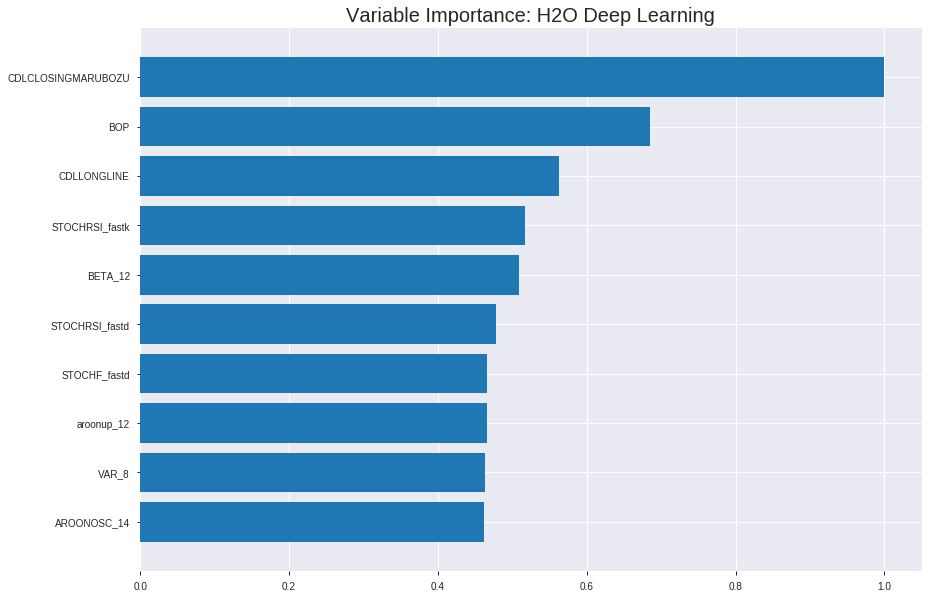

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_172646_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18928987040305914
RMSE: 0.4350745572922636
LogLoss: 0.5745140758276771
Mean Per-Class Error: 0.28313223364898343
AUC: 0.7911091877948614
pr_auc: 0.7604364693280915
Gini: 0.5822183755897228
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4251112155583429: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      495  310  0.3851   (310.0/805.0)
1      135  597  0.1844   (135.0/732.0)
Total  630  907  0.2895   (445.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425111     0.728493  238
max f2                       0.0941667    0.838443  360
max f0point5                 0.689023     0.712687  125
max accuracy                 0.529612     0.716981  193
max precision                0.998744     1         0
max recall                   0.00139239   1         398
max specificity              0.998744     1         0
max absolute_mcc             0.425111     0.437153  238
max min_per_class_accuracy   0.528032     0.715847  194
max mean_per_class_accuracy  0.529612     0.716868  193

Gains/Lift Table: Avg response rate: 47.63 %, avg score: 49.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.997554           2.09973   2.09973            1                0.998424   1                           0.998424            0.0218579       0.0218579                  109.973   109.973
    2        0.0201692                   0.996206           2.09973   2.09973            1                0.997002   1                           0.997736            0.0204918       0.0423497                  109.973   109.973
    3        0.0305791                   0.993932           1.83726   2.01038            0.875            0.995147   0.957447                    0.996854            0.0191257       0.0614754                  83.7261   101.038
    4        0.0403383                   0.99112            2.09973   2.03199            1                0.992497   0.967742                    0.9958              0.0204918       0.0819672                  109.973   103.199
    5        0.0500976                   0.987279           1.81976   1.99065            0.866667         0.98912    0.948052                    0.994499            0.0177596       0.0997268                  81.9763   99.065
    6        0.100195                    0.90201            1.79977   1.89521            0.857143         0.947801   0.902597                    0.97115             0.0901639       0.189891                   79.9766   89.5208
    7        0.150293                    0.830111           1.71796   1.83612            0.818182         0.86007    0.874459                    0.934123            0.0860656       0.275956                   71.7958   83.6125
    8        0.20039                     0.788161           1.4998    1.75204            0.714286         0.808117   0.834416                    0.902622            0.0751366       0.351093                   49.9805   75.2045
    9        0.299935                    0.700779           1.44099   1.64881            0.686275         0.741807   0.785249                    0.849249            0.143443        0.494536                   44.0989   64.8809
    10       0.40013                     0.616355           1.13167   1.51931            0.538961         0.659591   0.723577                    0.801758            0.113388        0.607923                   13.1671   51.9314
    11       0.500325                    0.511986           1.15894   1.44715            0.551948         0.570906   0.689207                    0.755527            0.11612         0.724044                   15.894    44.7146
    12       0.59987                     0.408931           0.960659  1.36642            0.457516         0.465236   0.650759                    0.707355            0.0956284       0.819672                   -3.93407  36.6417
    13       0.700065                    0.295855           0.722633  1.27428            0.344156         0.349684   0.606877                    0.656165            0.0724044       0.892077                   -27.7367  27.4277
    14       0.79961                     0.168083           0.576396  1.1874             0.27451          0.228246   0.5655                      0.602892            0.057377        0.949454                   -42.3604  18.7396
    15       0.899805                    0.042275           0.313596  1.0901             0.149351         0.101408   0.519161                    0.547051            0.0314208       0.980874                   -68.6404  9.00968
    16       1                           1.43213e-05        0.190884  1                  0.0909091        0.0113343  0.476252                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.22239030499102008
RMSE: 0.4715827657909268
LogLoss: 0.64513848609349
Mean Per-Class Error: 0.3219384781884782
AUC: 0.7398330835830836
pr_auc: 0.7303909859521336
Gini: 0.4796661671661673
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2104297932071467: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      70   161  0.697    (161.0/231.0)
1      10   198  0.0481   (10.0/208.0)
Total  80   359  0.3895   (171.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.21043      0.698413  330
max f2                       0.146536     0.83815   346
max f0point5                 0.659861     0.666322  170
max accuracy                 0.659861     0.681093  170
max precision                0.999633     1         0
max recall                   0.00885393   1         386
max specificity              0.999633     1         0
max absolute_mcc             0.659861     0.35889   170
max min_per_class_accuracy   0.613709     0.670996  196
max mean_per_class_accuracy  0.659861     0.678062  170

Gains/Lift Table: Avg response rate: 47.38 %, avg score: 56.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.998725           2.11058   2.11058            1                0.999088  1                           0.999088            0.0240385       0.0240385                  111.058   111.058
    2        0.0205011                   0.997772           2.11058   2.11058            1                0.99833   1                           0.998752            0.0192308       0.0432692                  111.058   111.058
    3        0.0318907                   0.996356           2.11058   2.11058            1                0.997165  1                           0.998185            0.0240385       0.0673077                  111.058   111.058
    4        0.0410023                   0.994025           2.11058   2.11058            1                0.995252  1                           0.997533            0.0192308       0.0865385                  111.058   111.058
    5        0.0501139                   0.989711           2.11058   2.11058            1                0.991561  1                           0.996447            0.0192308       0.105769                   111.058   111.058
    6        0.100228                    0.922685           1.72684   1.91871            0.818182         0.95963   0.909091                    0.978039            0.0865385       0.192308                   72.6836   91.8706
    7        0.150342                    0.892357           1.43903   1.75881            0.681818         0.90711   0.833333                    0.954396            0.0721154       0.264423                   43.903    75.8814
    8        0.200456                    0.847204           1.53497   1.70285            0.727273         0.869635  0.806818                    0.933206            0.0769231       0.341346                   53.4965   70.2852
    9        0.300683                    0.769125           1.00732   1.47101            0.477273         0.805978  0.69697                     0.890796            0.100962        0.442308                   0.73208   47.1008
    10       0.400911                    0.686855           1.19919   1.40305            0.568182         0.730835  0.664773                    0.850806            0.120192        0.5625                     19.9191   40.3054
    11       0.501139                    0.607954           1.15122   1.35269            0.545455         0.645913  0.640909                    0.809827            0.115385        0.677885                   15.1224   35.2688
    12       0.599089                    0.503875           0.932581  1.284              0.44186          0.562359  0.608365                    0.769367            0.0913462       0.769231                   -6.74195  28.4001
    13       0.699317                    0.405635           0.719515  1.2031             0.340909         0.460446  0.570033                    0.725092            0.0721154       0.841346                   -28.0485  20.3098
    14       0.799544                    0.265406           0.911385  1.16653            0.431818         0.347461  0.552707                    0.677753            0.0913462       0.932692                   -8.86145  16.653
    15       0.899772                    0.0727097          0.479677  1.09002            0.227273         0.161965  0.516456                    0.620298            0.0480769       0.980769                   -52.0323  9.00195
    16       1                           0.000191814        0.191871  1                  0.0909091        0.021939  0.473804                    0.560326          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:28:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 17:28:06  1 min 18.316 sec  5206 obs/sec      7.48992   1             11512      0.456203         0.674324            0.165635       0.776614        0.648833           2.09973          0.324008                         0.488582           0.724419              0.0425218        0.729562          0.711398             2.11058            0.394077
    2019-08-28 17:28:11  1 min 24.120 sec  5817 obs/sec      30.0455   4             46180      0.435075         0.574514            0.241129       0.791109        0.760436           2.09973          0.289525                         0.471583           0.645138              0.10799          0.739833          0.730391             2.11058            0.389522
    2019-08-28 17:28:18  1 min 30.567 sec  6463 obs/sec      60.1366   8             92430      0.428328         0.570697            0.264482       0.806968        0.769439           2.09973          0.288874                         0.470105           0.650314              0.11357          0.750135          0.738997             2.11058            0.341686
    2019-08-28 17:28:24  1 min 36.310 sec  6945 obs/sec      90.216    12            138662     0.417467         0.554601            0.301308       0.82062         0.791105           2.09973          0.26285                          0.469582           0.660527              0.115542         0.740208          0.733682             2.11058            0.396355
    2019-08-28 17:28:29  1 min 41.605 sec  7342 obs/sec      120.301   16            184902     0.412507         0.538956            0.317813       0.8301          0.768747           2.09973          0.257645                         0.47349            0.666818              0.10076          0.742247          0.725226             2.11058            0.353075
    2019-08-28 17:28:35  1 min 47.715 sec  7771 obs/sec      157.804   21            242545     0.398748         0.51099             0.362563       0.850732        0.770726           2.09973          0.227716                         0.482978           0.708304              0.0643625        0.733329          0.707588             2.11058            0.348519
    2019-08-28 17:28:41  1 min 53.640 sec  8103 obs/sec      195.329   26            300221     0.390644         0.496255            0.388209       0.861441        0.793247           2.09973          0.239427                         0.477261           0.701176              0.0863783        0.740072          0.715783             2.11058            0.350797
    2019-08-28 17:28:41  1 min 53.724 sec  8101 obs/sec      195.329   26            300221     0.435075         0.574514            0.241129       0.791109        0.760436           2.09973          0.289525                         0.471583           0.645138              0.10799          0.739833          0.730391             2.11058            0.389522

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.03827755239593186
BOP                 0.684585452079773      0.684585452079773    0.02620425551147621
CDLLONGLINE         0.5633118152618408     0.5633118152618408   0.0215621975239326
STOCHRSI_fastk      0.5172950029373169     0.5172950029373169   0.019800786579086873
BETA_12             0.5087171196937561     0.5087171196937561   0.01947244620378529
---                 ---                    ---                  ---
ROCR_8              0.3860780894756317     0.3860780894756317   0.014778124298824764
LINEARREG_ANGLE_12  0.3765623867511749     0.3765623867511749   0.014413886489205257
CCI_14              0.37593185901641846    0.37593185901641846  0.014389751430801028
ROCP_8              0.3702199161052704     0.3702199161052704   0.014171112236736986
MACDFIX_14          0.3603370487689972     0.3603370487689972   0.013792820264450745


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6954545454545454)

('F1', 0.7265306122448979)

('auc', 0.7426421957671957)

('logloss', 0.7148469162877868)

('mean_per_class_error', 0.3022486772486772)

('rmse', 0.48224890695104755)

('mse', 0.23256400825548013)

deeplearning prediction progress: |███████████████████████████████████████| 100%



ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.23256400825548013
RMSE: 0.48224890695104755
LogLoss: 0.7148469162877868
Mean Per-Class Error: 0.3022486772486772
AUC: 0.7426421957671957
pr_auc: 0.7036194651220316
Gini: 0.4852843915343914
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6051857092451431: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   48   0.4286   (48.0/112.0)
1      19   89   0.1759   (19.0/108.0)
Total  83   137  0.3045   (67.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.605186     0.726531  136
max f2                       0.0495073    0.843849  201
max f0point5                 0.739185     0.6875    92
max accuracy                 0.605186     0.695455  136
max precision                0.999366     1         0
max recall                   0.0176953    1         208
max specificity              0.999366     1         0
max absolute_mcc             0.605186     0.407916  136
max min_per_class_accuracy   0.703207     0.685185  107
max mean_per_class_accuracy  0.605186     0.697751  136

Gains/Lift Table: Avg response rate: 49.09 %, avg score: 62.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.998532           2.03704   2.03704            1                0.998942   1                           0.998942            0.0277778       0.0277778                  103.704   103.704
    2        0.0227273                   0.998256           1.01852   1.62963            0.5              0.998393   0.8                         0.998722            0.00925926      0.037037                   1.85185   62.963
    3        0.0318182                   0.997515           1.01852   1.45503            0.5              0.997981   0.714286                    0.998511            0.00925926      0.0462963                  1.85185   45.5026
    4        0.0409091                   0.994085           2.03704   1.58436            1                0.996322   0.777778                    0.998024            0.0185185       0.0648148                  103.704   58.4362
    5        0.05                        0.993262           1.01852   1.48148            0.5              0.993485   0.727273                    0.997199            0.00925926      0.0740741                  1.85185   48.1481
    6        0.1                         0.937582           1.85185   1.66667            0.909091         0.956588   0.818182                    0.976893            0.0925926       0.166667                   85.1852   66.6667
    7        0.15                        0.905446           1.48148   1.60494            0.727273         0.925141   0.787879                    0.959643            0.0740741       0.240741                   48.1481   60.4938
    8        0.2                         0.86709            1.66667   1.62037            0.818182         0.886822   0.795455                    0.941437            0.0833333       0.324074                   66.6667   62.037
    9        0.3                         0.81266            1.11111   1.45062            0.545455         0.839441   0.712121                    0.907439            0.111111        0.435185                   11.1111   45.0617
    10       0.4                         0.758419           1.38889   1.43519            0.681818         0.783639   0.704545                    0.876489            0.138889        0.574074                   38.8889   43.5185
    11       0.5                         0.692642           1.11111   1.37037            0.545455         0.724212   0.672727                    0.846033            0.111111        0.685185                   11.1111   37.037
    12       0.6                         0.62423            1.01852   1.31173            0.5              0.658149   0.643939                    0.814719            0.101852        0.787037                   1.85185   31.1728
    13       0.7                         0.549301           0.833333  1.24339            0.409091         0.582495   0.61039                     0.781544            0.0833333       0.87037                    -16.6667  24.3386
    14       0.8                         0.39248            0.555556  1.15741            0.272727         0.482805   0.568182                    0.744202            0.0555556       0.925926                   -44.4444  15.7407
    15       0.9                         0.0931361          0.462963  1.08025            0.227273         0.24619    0.530303                    0.688867            0.0462963       0.972222                   -53.7037  8.02469
    16       1                           0.0026162          0.277778  1                  0.136364         0.0236784  0.490909                    0.

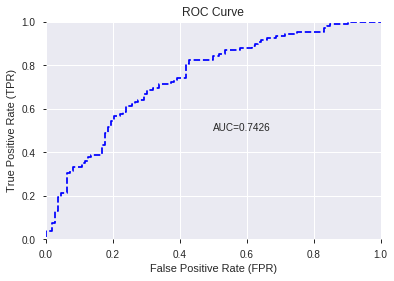

This function is available for GLM models only


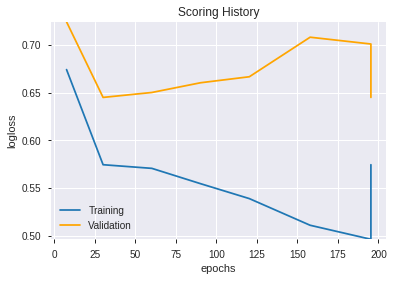

--2019-08-28 17:34:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


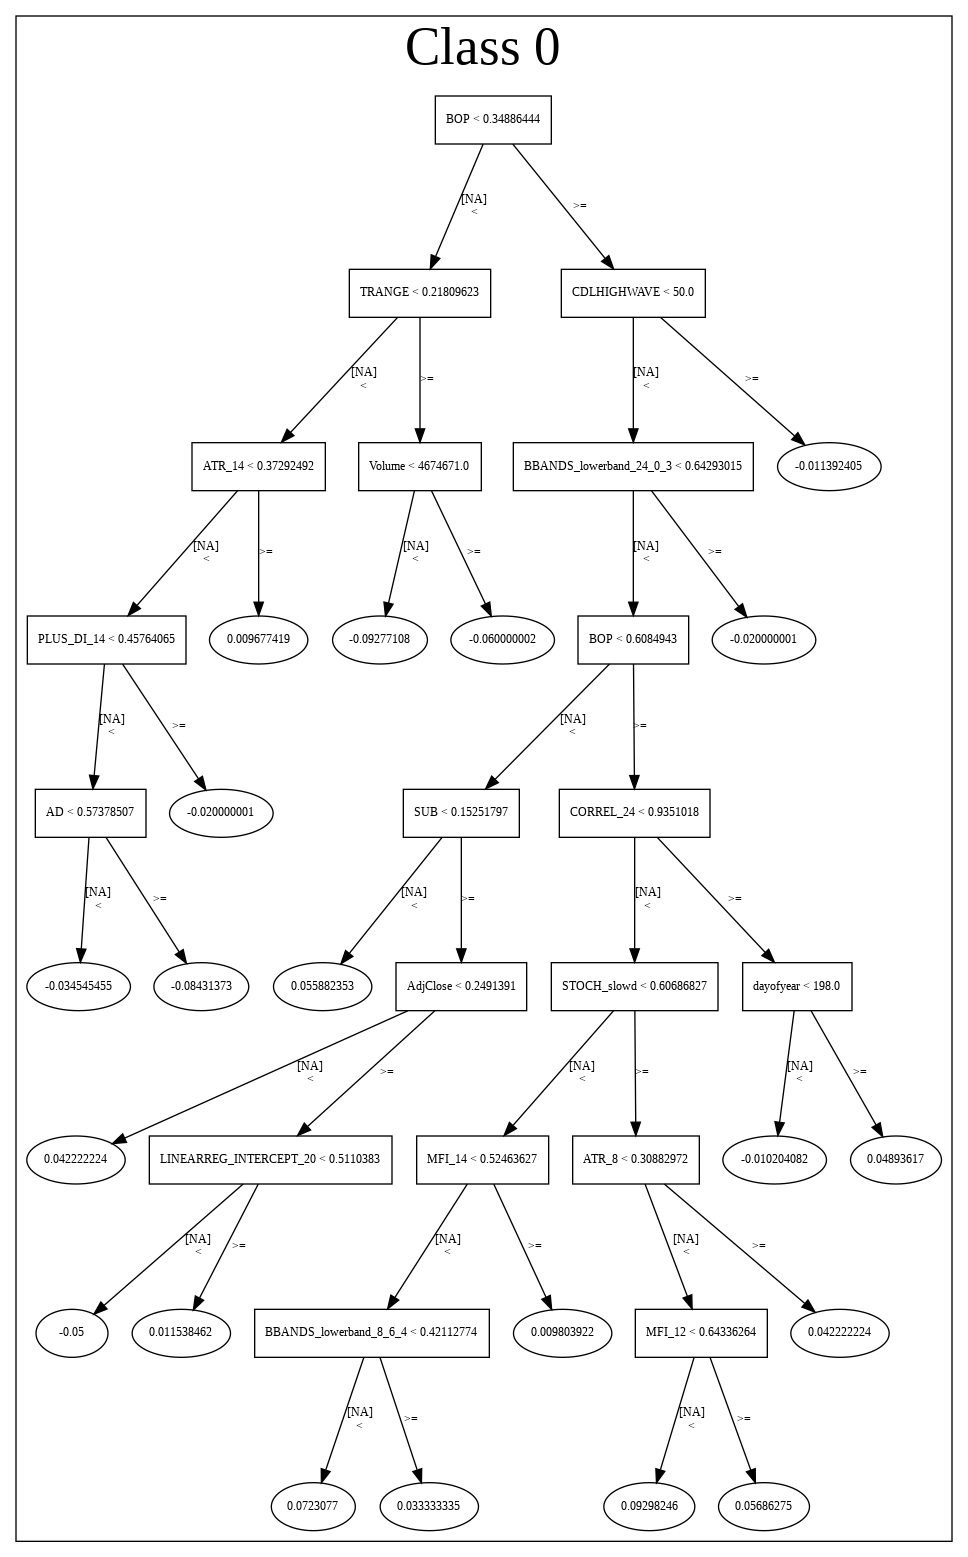

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_172646_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_172646_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8492',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLLONGLINE',
 'STOCHRSI_fastk',
 'BETA_12',
 'STOCHRSI_fastd',
 'STOCHF_fastd',
 'aroonup_12',
 'VAR_8',
 'AROONOSC_14',
 'STDDEV_12',
 'BETA_8',
 'AROONOSC_12',
 'ADX_24',
 'STOCHF_fastk',
 'VAR_14',
 'BBANDS_upperband_30_7_4',
 'aroonup_20',
 'WILLR_14',
 'MFI_24',
 'WILLR_30',
 'MACDEXT_hist',
 'HT_PHASOR_quadrature',
 'aroonup_24',
 'ATR_24',
 'DX_30',
 'WILLR_12',
 'CCI_12',
 'HT_PHASOR_inphase',
 'NATR_20',
 'PLUS_DM_20',
 'PLUS_DI_14',
 'NATR_8',
 'STDDEV_8',
 'AROONOSC_20',
 'AVGPRICE',
 'NATR_12',
 'STOCH_slowk',
 'DX_24',
 'CDLBELTHOLD',
 'PLUS_DI_30',
 'ATR_8',
 'MFI_12',
 'MINUS_DM_8',
 'MA_24_7',
 'ROCR100_12',
 'BBANDS_upperband_20_1_5',
 'RSI_30',
 'MOM_24',
 'PLUS_DM_12',
 'ROCR100_8',
 'CCI_24',
 'RSI_12',
 'CCI_30',
 'ROCR_8',
 'LINEARREG_ANGLE_12',
 'CCI_14',
 'ROCP_8',
 'MACDFIX_14']

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error    rmse      mse
0  GLM_grid_1_AutoML_20190828_173440_model_1  0.721561  0.616434              0.358135  0.4614  0.21289

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.568789           1.000000    0.101948
1        CDLCLOSINGMARUBOZU             0.348003           0.611832    0.062375
2              STOCHF_fastk             0.260826           0.458564    0.046750
3         HT_PHASOR_inphase             0.232762           0.409223    0.041720
4                  WILLR_30             0.193482           0.340164    0.034679
5                  WILLR_12             0.188714           0.331782    0.033825
6                  WILLR_14             0.187501           0.329650    0.033607
7               CDLLONGLINE             0.165390           0.290776    0.029644
8            STOCHRSI_fastd             0.159937           0.281189    0.028667
9                    RSI_12             0.153596           0.270040    0.027530
10                   CCI_12             0.153274           0.269475    0.027473
11             STOCHF_fastd             0.145584           0.255954    0.026094
12              STOCH_slowk             0.145341           0.255526    0.026051
13                   BETA_8             0.141315           0.248449    0.025329
14               aroonup_20             0.139180           0.244695    0.024946
15                   ADX_24             0.115379           0.202850    0.020680
16                   MOM_24             0.109078           0.191773    0.019551
17               PLUS_DM_12             0.107561           0.189105    0.019279
18                 STDDEV_8             0.107022           0.188158    0.019182
19                   CCI_24             0.106041           0.186433    0.019007
20                  BETA_12             0.096928           0.170412    0.017373
21                    ATR_8             0.093775           0.164867    0.016808
22              CDLBELTHOLD             0.091216           0.160370    0.016349
23                   NATR_8             0.090371           0.158882    0.016198
24                   RSI_30             0.082313           0.144716    0.014754
25               aroonup_12             0.076692           0.134834    0.013746
26                   ATR_24             0.075168           0.132155    0.013473
27       LINEARREG_ANGLE_12             0.071459           0.125634    0.012808
28                STDDEV_12             0.070750           0.124386    0.012681
29               aroonup_24             0.069585           0.122338    0.012472
30                   CCI_14             0.068402           0.120259    0.012260
31                  NATR_20             0.064246           0.112953    0.011515
32                   MFI_24             0.062006           0.109014    0.011114
33               ROCR100_12             0.061214           0.107622    0.010972
34                    DX_30             0.054309           0.095483    0.009734
35               PLUS_DI_14             0.052054           0.091518    0.009330
36             MACDEXT_hist             0.049295           0.086666    0.008835
37                   ROCP_8             0.046466           0.081693    0.008329
38                   ROCR_8             0.046068           0.080994    0.008257
39                ROCR100_8             0.045882           0.080667    0.008224
40                   VAR_14             0.045791           0.080507    0.008208
41              AROONOSC_12             0.045769           0.080468    0.008204
42  BBANDS_upperband_30_7_4             0.044045           0.077436    0.007895
43              AROONOSC_20             0.041107           0.072271    0.007368
44                   MFI_12             0.036439           0.064064    0.006531
45               MINUS_DM_8             0.036305           0.063829    0.006507
46           STOCHRSI_fastk             0.034918           0.061390    0.006259
47               PLUS_DM_20             0.031329           0.055080    0.005615
48     HT_PHASOR_quadrature             0.027394           0.048161    0.004910
49                 

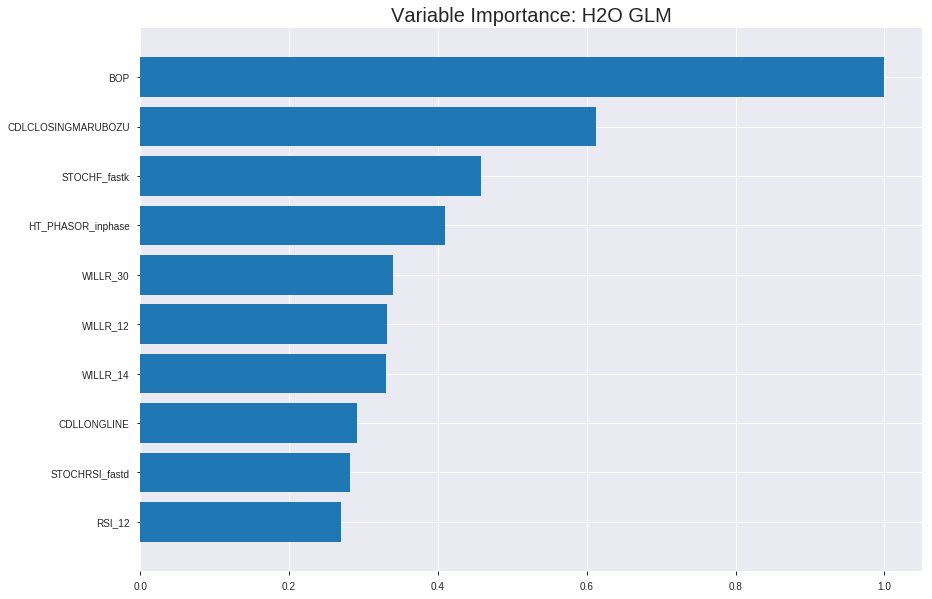

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_173440_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1839231780503834
RMSE: 0.428862656395242
LogLoss: 0.5437507167130099
Null degrees of freedom: 1536
Residual degrees of freedom: 1477
Null deviance: 2127.2659845544013
Residual deviance: 1671.4897031757923
AIC: 1791.4897031757923
AUC: 0.7978277840002715
pr_auc: 0.7694068886819144
Gini: 0.5956555680005431
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36164042930465534: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      438  367   0.4559   (367.0/805.0)
1      87   645   0.1189   (87.0/732.0)
Total  525  1012  0.2954   (454.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36164      0.739679  255
max f2                       0.246965     0.845037  314
max f0point5                 0.489551     0.71663   193
max accuracy                 0.489551     0.729993  193
max precision                0.963396     1         0
max recall                   0.0681459    1         381
max specificity              0.963396     1         0
max absolute_mcc             0.468974     0.461486  204
max min_per_class_accuracy   0.47904      0.725466  199
max mean_per_class_accuracy  0.468974     0.730963  204

Gains/Lift Table: Avg response rate: 47.63 %, avg score: 47.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.940453           2.09973    2.09973            1                0.949343   1                           0.949343            0.0218579       0.0218579                  109.973   109.973
    2        0.0201692                   0.925393           1.81976    1.96426            0.866667         0.931994   0.935484                    0.940949            0.0177596       0.0396175                  81.9763   96.4261
    3        0.0305791                   0.916572           1.96849    1.9657             0.9375           0.920922   0.93617                     0.934131            0.0204918       0.0601093                  96.8494   96.5702
    4        0.0403383                   0.908351           1.95974    1.96426            0.933333         0.911186   0.935484                    0.92858             0.0191257       0.079235                   95.9745   96.4261
    5        0.0500976                   0.893805           1.81976    1.93611            0.866667         0.901458   0.922078                    0.923296            0.0177596       0.0969945                  81.9763   93.6112
    6        0.100195                    0.78763            1.93611    1.93611            0.922078         0.841418   0.922078                    0.882357            0.0969945       0.193989                   93.6112   93.6112
    7        0.150293                    0.725312           1.47254    1.78159            0.701299         0.751993   0.848485                    0.838903            0.0737705       0.26776                    47.2536   78.1586
    8        0.20039                     0.685229           1.52707    1.71796            0.727273         0.70277    0.818182                    0.804869            0.0765027       0.344262                   52.7074   71.7958
    9        0.299935                    0.611772           1.35865    1.59871            0.647059         0.644268   0.761388                    0.751568            0.135246        0.479508                   35.8647   59.8707
    10       0.40013                     0.543692           1.30892    1.52614            0.623377         0.577123   0.726829                    0.707886            0.131148        0.610656                   30.8921   52.6143
    11       0.500325                    0.472505           1.24075    1.46899            0.590909         0.504678   0.69961                     0.667191            0.124317        0.734973                   24.0748   46.899
    12       0.59987                     0.403567           0.946936   1.38236            0.45098          0.43969    0.658351                    0.629439            0.0942623       0.829235                   -5.30644  38.2358
    13       0.700065                    0.333719           0.722633   1.28794            0.344156         0.368578   0.613383                    0.592104            0.0724044       0.901639                   -27.7367  28.7936
    14       0.79961                     0.264591           0.548948   1.19594            0.261438         0.299301   0.569569                    0.555653            0.0546448       0.956284                   -45.1052  19.5939
    15       0.899805                    0.170141           0.340865   1.10072            0.162338         0.223827   0.524223                    0.518703            0.034153        0.990437                   -65.9135  10.0724
    16       1                           0.0205429          0.0954421  1                  0.0454545        0.0950235  0.476252  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19949681411813816
RMSE: 0.44665066228333095
LogLoss: 0.5778727164495808
Null degrees of freedom: 438
Residual degrees of freedom: 379
Null deviance: 607.3882128516068
Residual deviance: 507.37224504273195
AIC: 627.372245042732
AUC: 0.7525079087579088
pr_auc: 0.7451138641654294
Gini: 0.5050158175158177
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2907037706883603: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      91   140  0.6061   (140.0/231.0)
1      19   189  0.0913   (19.0/208.0)
Total  110  329  0.3622   (159.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.290704     0.703911  297
max f2                       0.156946     0.832656  362
max f0point5                 0.544765     0.686047  152
max accuracy                 0.544765     0.692483  152
max precision                0.95889      1         0
max recall                   0.0834078    1         384
max specificity              0.95889      1         0
max absolute_mcc             0.544765     0.384963  152
max min_per_class_accuracy   0.453094     0.683983  201
max mean_per_class_accuracy  0.46489      0.688874  191

Gains/Lift Table: Avg response rate: 47.38 %, avg score: 46.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.938572           2.11058   2.11058            1                0.946003   1                           0.946003            0.0240385       0.0240385                  111.058   111.058
    2        0.0205011                   0.934467           2.11058   2.11058            1                0.936549   1                           0.941801            0.0192308       0.0432692                  111.058   111.058
    3        0.0318907                   0.914769           2.11058   2.11058            1                0.925327   1                           0.935917            0.0240385       0.0673077                  111.058   111.058
    4        0.0410023                   0.903263           1.58293   1.99332            0.75             0.907866   0.944444                    0.929684            0.0144231       0.0817308                  58.2933   99.3323
    5        0.0501139                   0.877493           2.11058   2.01464            1                0.893818   0.954545                    0.923163            0.0192308       0.100962                   111.058   101.464
    6        0.100228                    0.786958           2.01464   2.01464            0.954545         0.831724   0.954545                    0.877443            0.100962        0.201923                   101.464   101.464
    7        0.150342                    0.726582           1.53497   1.85475            0.727273         0.753569   0.878788                    0.836152            0.0769231       0.278846                   53.4965   85.4749
    8        0.200456                    0.671126           1.15122   1.67887            0.545455         0.695942   0.795455                    0.801099            0.0576923       0.336538                   15.1224   67.8868
    9        0.300683                    0.596699           1.24716   1.53497            0.590909         0.634359   0.727273                    0.745519            0.125           0.461538                   24.7159   53.4965
    10       0.400911                    0.517296           1.19919   1.45102            0.568182         0.558575   0.6875                      0.698783            0.120192        0.581731                   19.9191   45.1022
    11       0.501139                    0.446325           1.10326   1.38147            0.522727         0.476485   0.654545                    0.654324            0.110577        0.692308                   10.3256   38.1469
    12       0.599089                    0.387109           0.883497  1.30005            0.418605         0.414121   0.61597                     0.615051            0.0865385       0.778846                   -11.6503  30.0051
    13       0.699317                    0.321092           0.62358   1.2031             0.295455         0.356555   0.570033                    0.578003            0.0625          0.841346                   -37.642   20.3098
    14       0.799544                    0.241505           0.81545   1.1545             0.386364         0.288258   0.547009                    0.541681            0.0817308       0.923077                   -18.455   15.4504
    15       0.899772                    0.172698           0.575612  1.09002            0.272727         0.206146   0.516456                    0.504305            0.0576923       0.980769                   -42.4388  9.00195
    16       1                           0.0144566          0.191871  1                  0.0909091        0.0961217  0.473804                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 17:34:40  0.000 sec   2            23        60            1.36516           1.36858
    2019-08-28 17:34:40  0.009 sec   4            14        60            1.35588           1.36093
    2019-08-28 17:34:40  0.017 sec   6            8.9       60            1.34311           1.35014
    2019-08-28 17:34:40  0.026 sec   8            5.5       60            1.32631           1.33552
    2019-08-28 17:34:40  0.034 sec   10           3.4       60            1.30511           1.31665
    2019-08-28 17:34:40  0.043 sec   12           2.1       60            1.27977           1.29378
    2019-08-28 17:34:40  0.051 sec   14           1.3       60            1.25153           1.26827
    2019-08-28 17:34:40  0.066 sec   16           0.82      60            1.22225           1.24227
    2019-08-28 17:34:40  0.080 sec   18           0.51      60            1.19397           1.21811
    2019-08-28 17:34:40  0.097 sec   20           0.32      60            1.16814           1.19745
    2019-08-28 17:34:40  0.111 sec   22           0.2       60            1.14548           1.18111
    2019-08-28 17:34:41  0.131 sec   24           0.12      60            1.12615           1.16914
    2019-08-28 17:34:41  0.151 sec   26           0.076     60            1.11011           1.16126
    2019-08-28 17:34:41  0.165 sec   28           0.047     60            1.09728           1.157
    2019-08-28 17:34:41  0.179 sec   30           0.029     60            1.0875            1.15575
    2019-08-28 17:34:41  0.197 sec   32           0.018     60            1.0804            1.15671
    2019-08-28 17:34:41  0.212 sec   34           0.011     60            1.07539           1.15911
    2019-08-28 17:34:41  0.229 sec   36           0.007     60            1.07186           1.1623
    2019-08-28 17:34:41  0.245 sec   38           0.0044    60            1.06934           1.16567
    2019-08-28 17:34:41  0.259 sec   40           0.0027    60            1.06743           1.16865

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6863636363636364)

('F1', 0.7183098591549296)

('auc', 0.7215608465608465)

('logloss', 0.6164343496767865)

('mean_per_class_error', 0.3128306878306878)

('rmse', 0.461399732169716)

('mse', 0.2128897128462857)

glm prediction progress: |████████████████████████████████████████████████| 100%


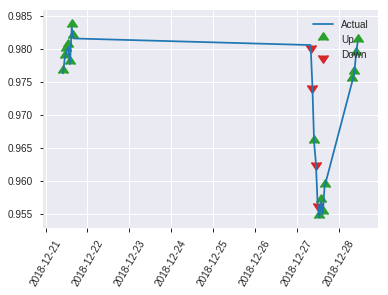


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2128897128462857
RMSE: 0.461399732169716
LogLoss: 0.6164343496767865
Null degrees of freedom: 219
Residual degrees of freedom: 160
Null deviance: 305.10134599958155
Residual deviance: 271.231113857786
AIC: 391.231113857786
AUC: 0.7215608465608465
pr_auc: 0.6732385454852109
Gini: 0.443121693121693
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30297112284550365: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      38   74   0.6607   (74.0/112.0)
1      6    102  0.0556   (6.0/108.0)
Total  44   176  0.3636   (80.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.302971     0.71831   175
max f2                       0.258963     0.850891  184
max f0point5                 0.484678     0.678571  112
max accuracy                 0.484678     0.686364  112
max precision                0.871295     0.857143  13
max recall                   0.0638694    1         216
max specificity              0.953173     0.991071  0
max absolute_mcc             0.468177     0.375536  118
max min_per_class_accuracy   0.490429     0.669643  109
max mean_per_class_accuracy  0.468177     0.687169  118

Gains/Lift Table: Avg response rate: 49.09 %, avg score: 49.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.940765           1.35802   1.35802            0.666667         0.948309  0.666667                    0.948309            0.0185185       0.0185185                  35.8025   35.8025
    2        0.0227273                   0.929207           1.01852   1.22222            0.5              0.934685  0.6                         0.94286             0.00925926      0.0277778                  1.85185   22.2222
    3        0.0318182                   0.921955           2.03704   1.45503            1                0.923546  0.714286                    0.937341            0.0185185       0.0462963                  103.704   45.5026
    4        0.0409091                   0.905701           2.03704   1.58436            1                0.91675   0.777778                    0.932766            0.0185185       0.0648148                  103.704   58.4362
    5        0.05                        0.887419           2.03704   1.66667            1                0.897896  0.818182                    0.926426            0.0185185       0.0833333                  103.704   66.6667
    6        0.1                         0.814916           1.48148   1.57407            0.727273         0.853052  0.772727                    0.889739            0.0740741       0.157407                   48.1481   57.4074
    7        0.15                        0.720594           1.85185   1.66667            0.909091         0.779289  0.818182                    0.852922            0.0925926       0.25                       85.1852   66.6667
    8        0.2                         0.693824           0.740741  1.43519            0.363636         0.704238  0.704545                    0.815751            0.037037        0.287037                   -25.9259  43.5185
    9        0.3                         0.611007           1.48148   1.45062            0.727273         0.648234  0.712121                    0.759912            0.148148        0.435185                   48.1481   45.0617
    10       0.4                         0.547454           0.925926  1.31944            0.454545         0.583413  0.647727                    0.715787            0.0925926       0.527778                   -7.40741  31.9444
    11       0.5                         0.488957           1.48148   1.35185            0.727273         0.519052  0.663636                    0.67644             0.148148        0.675926                   48.1481   35.1852
    12       0.6                         0.432801           0.833333  1.26543            0.409091         0.462789  0.621212                    0.640832            0.0833333       0.759259                   -16.6667  26.5432
    13       0.7                         0.372              0.833333  1.2037             0.409091         0.400794  0.590909                    0.606541            0.0833333       0.842593                   -16.6667  20.3704
    14       0.8                         0.302873           1.01852   1.18056            0.5              0.33257   0.579545                    0.572294            0.101852        0.944444                   1.85185   18.0556
    15       0.9                         0.177302           0.277778  1.08025            0.136364         0.23978   0.530303                    0.535348            0.0277778       0.972222                   -72.2222  8.02469
    16       1                           0.0544239          0.277778  1                  0.136364         0.099861  0.490909                    0.4918           

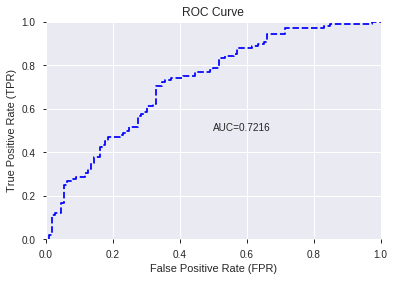

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


'log_likelihood'
--2019-08-28 17:34:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


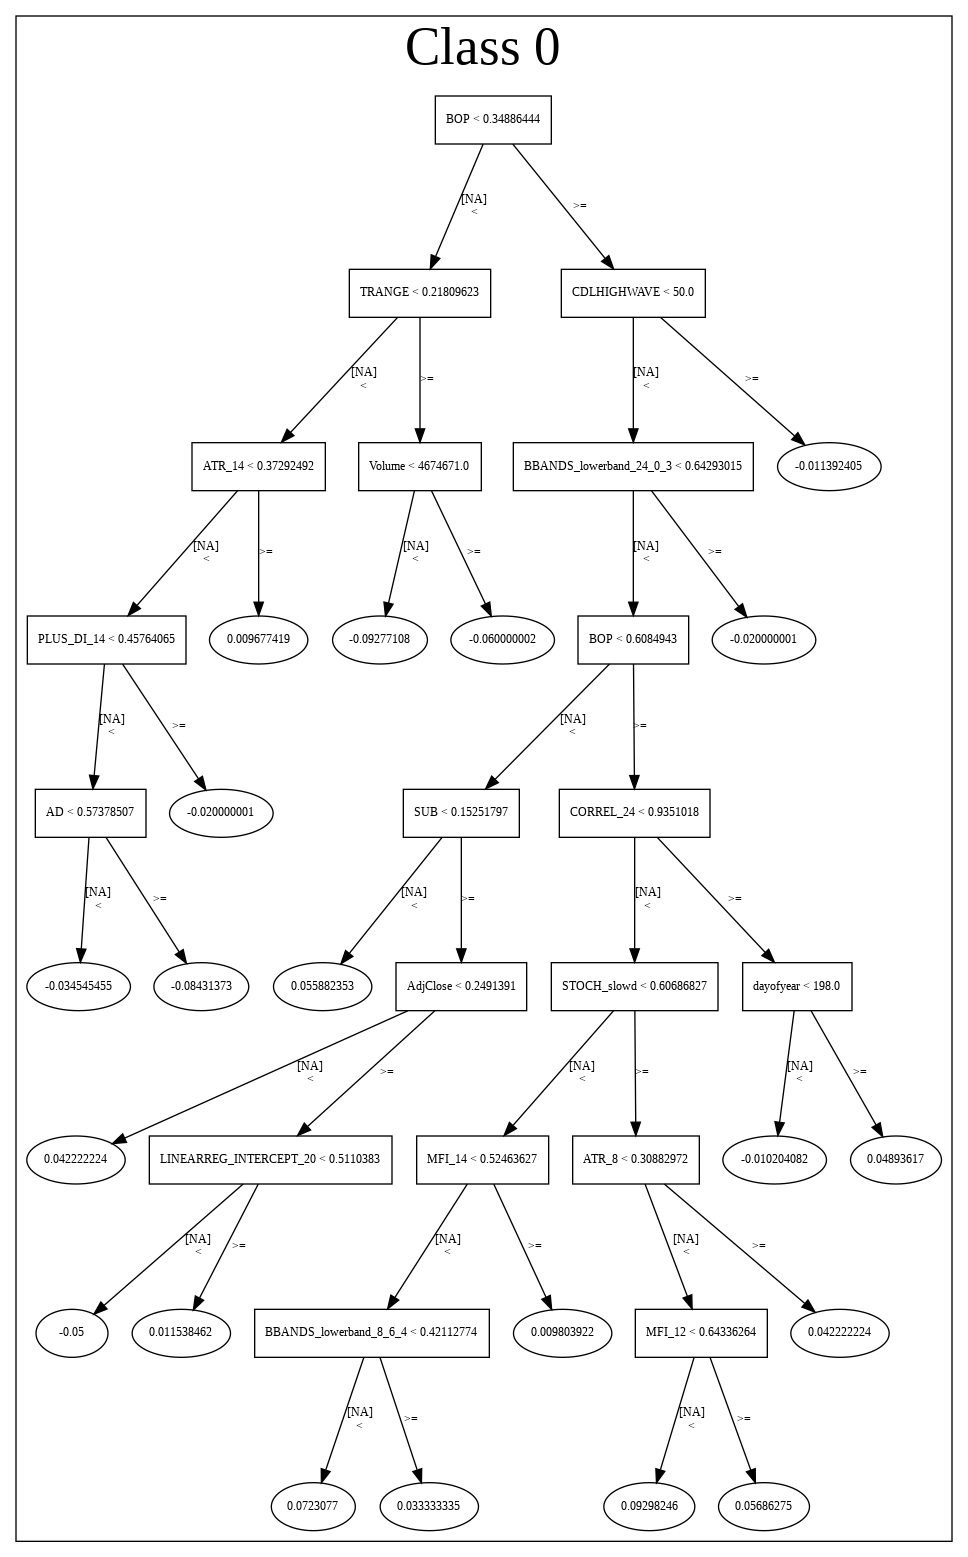

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_173440_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_173440_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8492',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'HT_PHASOR_inphase',
 'WILLR_30',
 'WILLR_12',
 'WILLR_14',
 'CDLLONGLINE',
 'STOCHRSI_fastd',
 'RSI_12',
 'CCI_12',
 'STOCHF_fastd',
 'STOCH_slowk',
 'BETA_8',
 'aroonup_20',
 'ADX_24',
 'MOM_24',
 'PLUS_DM_12',
 'STDDEV_8',
 'CCI_24',
 'BETA_12',
 'ATR_8',
 'CDLBELTHOLD',
 'NATR_8',
 'RSI_30',
 'aroonup_12',
 'ATR_24',
 'LINEARREG_ANGLE_12',
 'STDDEV_12',
 'aroonup_24',
 'CCI_14',
 'NATR_20',
 'MFI_24',
 'ROCR100_12',
 'DX_30',
 'PLUS_DI_14',
 'MACDEXT_hist',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'VAR_14',
 'AROONOSC_12',
 'BBANDS_upperband_30_7_4',
 'AROONOSC_20',
 'MFI_12',
 'MINUS_DM_8',
 'STOCHRSI_fastk',
 'PLUS_DM_20',
 'HT_PHASOR_quadrature',
 'VAR_8',
 'BBANDS_upperband_20_1_5',
 'MACDFIX_14',
 'CCI_30',
 'DX_24',
 'PLUS_DI_30',
 'NATR_12',
 'AVGPRICE',
 'MA_24_7',
 'AROONOSC_14']

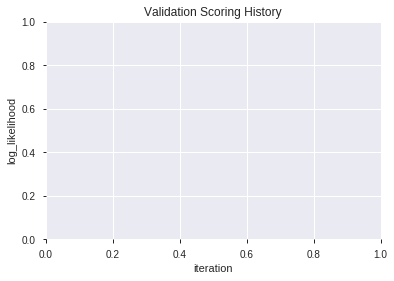

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_173457_model_3  0.740741  0.606237              0.319940  0.457429  0.209242
1               XGBoost_1_AutoML_20190828_173457  0.731151  0.612628              0.375661  0.461179  0.212686
2               XGBoost_2_AutoML_20190828_173457  0.727183  0.620464              0.375661  0.463574  0.214901
3               XGBoost_3_AutoML_20190828_173457  0.725364  0.619890              0.353671  0.464548  0.215805
4  XGBoost_grid_1_AutoML_20190828_173457_model_1  0.721478  0.634116              0.379630  0.470062  0.220958
5  XGBoost_grid_1_AutoML_20190828_173457_model_6  0.720403  0.624338              0.345238  0.466024  0.217178
6  XGBoost_grid_1_AutoML_20190828_173457_model_2  0.718833  0.625625              0.353836  0.467485  0.218543
7  XGBoost_grid_1_AutoML_20190828_173457_model_4  0.717675  0.624760              0.362930  0.466762  0.217867
8  XGBoost_grid_1_AutoML_20190828_173457_model_7  0.710896  0.636034              0.379630  0.472049  0.222830
9  XGBoost_grid_1_AutoML_20190828_173457_model_5  0.701720  0.649837              0.376157  0.476607  0.227154

variable  relative_importance  scaled_importance  percentage
0                       BOP          1926.501099           1.000000    0.272099
1              STOCHF_fastk           465.797699           0.241784    0.065789
2        CDLCLOSINGMARUBOZU           296.646515           0.153982    0.041898
3            STOCHRSI_fastd           235.693298           0.122343    0.033289
4         HT_PHASOR_inphase           187.142044           0.097141    0.026432
5            STOCHRSI_fastk           181.766846           0.094351    0.025673
6                    BETA_8           152.910233           0.079372    0.021597
7      HT_PHASOR_quadrature           134.553131           0.069843    0.019004
8                  STDDEV_8           129.879883           0.067417    0.018344
9                    CCI_14           127.613106           0.066241    0.018024
10                    DX_30           127.083405           0.065966    0.017949
11                   CCI_12           122.562347           0.063619    0.017311
12                   NATR_8           121.825958           0.063237    0.017207
13             MACDEXT_hist           120.139229           0.062361    0.016968
14                 WILLR_12           115.525940           0.059967    0.016317
15                   ATR_24           109.568878           0.056875    0.015476
16               aroonup_12           101.789970           0.052837    0.014377
17                   MFI_24           100.653564           0.052247    0.014216
18                   ADX_24            96.307449           0.049991    0.013602
19                   CCI_24            90.194763           0.046818    0.012739
20                 WILLR_14            90.093964           0.046766    0.012725
21               PLUS_DI_30            88.493752           0.045935    0.012499
22              STOCH_slowk            86.338951           0.044816    0.012195
23                  BETA_12            85.284966           0.044269    0.012046
24  BBANDS_upperband_30_7_4            79.922554           0.041486    0.011288
25                    DX_24            79.697464           0.041369    0.011256
26                   ROCP_8            79.443085           0.041237    0.011221
27                 WILLR_30            77.187920           0.040066    0.010902
28       LINEARREG_ANGLE_12            76.958038           0.039947    0.010870
29                   VAR_14            74.349220           0.038593    0.010501
30                   MOM_24            74.334259           0.038585    0.010499
31                STDDEV_12            73.662544           0.038236    0.010404
32                    ATR_8            73.605553           0.038207    0.010396
33               PLUS_DM_12            73.047195           0.037917    0.010317
34               MINUS_DM_8            72.516098           0.037641    0.010242
35               ROCR100_12            64.453819           0.033456    0.009103
36              CDLLONGLINE            61.139210           0.031736    0.008635
37                   MFI_12            56.704723           0.029434    0.008009
38                 AVGPRICE            54.870518           0.028482    0.007750
39  BBANDS_upperband_20_1_5            52.315418           0.027156    0.007389
40                   CCI_30            51.650757           0.026811    0.007295
41                  NATR_20            50.853771           0.026397    0.007183
42                  NATR_12            47.931534           0.024880    0.006770
43               MACDFIX_14            47.641193           0.024729    0.006729
44                  MA_24_7            44.411568           0.023053    0.006273
45              AROONOSC_20            42.639202           0.022133    0.006022
46                    VAR_8            40.555145           0.021051    0.005728
47               aroonup_24            38.576492           0.020024    0.005449
48              AROONOSC_14            38.477417           0.019973    0.005435
49               PL

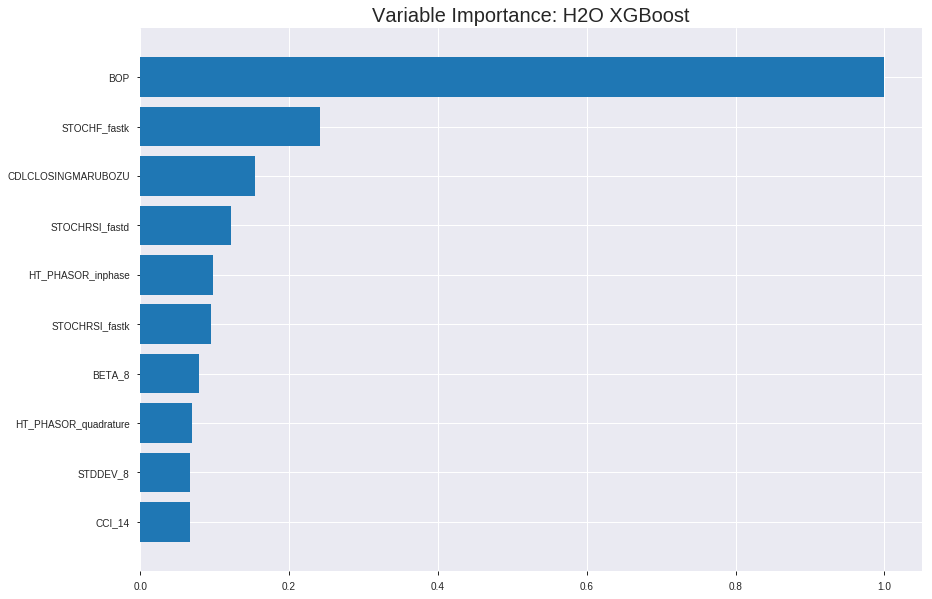

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_173457_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1332244144802915
RMSE: 0.3649991979173262
LogLoss: 0.4272026258335243
Mean Per-Class Error: 0.17830075009333735
AUC: 0.9166530903166683
pr_auc: 0.9126365968375912
Gini: 0.8333061806333366
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41052521392703056: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      568  237  0.2944   (237.0/805.0)
1      61   671  0.0833   (61.0/732.0)
Total  629  908  0.1939   (298.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.410525     0.818293  240
max f2                       0.345107     0.897534  266
max f0point5                 0.639813     0.842718  128
max accuracy                 0.503537     0.821731  195
max precision                0.944456     1         0
max recall                   0.166761     1         345
max specificity              0.944456     1         0
max absolute_mcc             0.503537     0.642999  195
max min_per_class_accuracy   0.503537     0.821038  195
max mean_per_class_accuracy  0.503537     0.821699  195

Gains/Lift Table: Avg response rate: 47.63 %, avg score: 47.68 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.929199           2.09973    2.09973            1                0.935595  1                           0.935595            0.0218579       0.0218579                  109.973   109.973
    2        0.0201692                   0.919367           2.09973    2.09973            1                0.923866  1                           0.929919            0.0204918       0.0423497                  109.973   109.973
    3        0.0305791                   0.903331           2.09973    2.09973            1                0.913212  1                           0.924232            0.0218579       0.0642077                  109.973   109.973
    4        0.0403383                   0.88922            2.09973    2.09973            1                0.895675  1                           0.917323            0.0204918       0.0846995                  109.973   109.973
    5        0.0500976                   0.870386           2.09973    2.09973            1                0.879024  1                           0.909862            0.0204918       0.105191                   109.973   109.973
    6        0.100195                    0.799005           2.09973    2.09973            1                0.833426  1                           0.871644            0.105191        0.210383                   109.973   109.973
    7        0.150293                    0.748344           2.09973    2.09973            1                0.771777  1                           0.838355            0.105191        0.315574                   109.973   109.973
    8        0.20039                     0.717274           1.93611    2.05882            0.922078         0.732826  0.980519                    0.811973            0.0969945       0.412568                   93.6112   105.882
    9        0.299935                    0.649424           1.77036    1.96309            0.843137         0.682815  0.934924                    0.769107            0.17623         0.588798                   77.0358   96.3085
    10       0.40013                     0.575364           1.32256    1.80269            0.62987          0.610965  0.858537                    0.729507            0.132514        0.721311                   32.2555   80.2692
    11       0.500325                    0.489409           1.09077    1.66012            0.519481         0.530443  0.790637                    0.689642            0.10929         0.830601                   9.07672   66.0122
    12       0.59987                     0.403168           0.933212   1.5395             0.444444         0.445634  0.733189                    0.649151            0.0928962       0.923497                   -6.67881  53.9496
    13       0.700065                    0.300077           0.545384   1.39722            0.25974          0.349145  0.665428                    0.606213            0.0546448       0.978142                   -45.4616  39.7216
    14       0.79961                     0.205134           0.178408   1.24548            0.0849673        0.255089  0.593165                    0.562501            0.0177596       0.995902                   -82.1592  24.5485
    15       0.899805                    0.134185           0.0409038  1.11135            0.0194805        0.165858  0.529284                    0.518334            0.00409836      1                          -95.9096  11.1352
    16       1                           0.055862           0          1                  0                0.104241  0.476252                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20122572344198897
RMSE: 0.4485819027134164
LogLoss: 0.5840182745713621
Mean Per-Class Error: 0.31138653013653017
AUC: 0.7552447552447552
pr_auc: 0.7325691476616547
Gini: 0.5104895104895104
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2903890013694763: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  128  0.5541   (128.0/231.0)
1      23   185  0.1106   (23.0/208.0)
Total  126  313  0.344    (151.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.290389     0.710173  283
max f2                       0.162267     0.837521  331
max f0point5                 0.632958     0.683594  126
max accuracy                 0.632958     0.685649  126
max precision                0.94071      1         0
max recall                   0.0770188    1         395
max specificity              0.94071      1         0
max absolute_mcc             0.632958     0.378506  126
max min_per_class_accuracy   0.503991     0.675325  196
max mean_per_class_accuracy  0.439548     0.688613  217

Gains/Lift Table: Avg response rate: 47.38 %, avg score: 46.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.924054           2.11058   2.11058            1                0.933177  1                           0.933177            0.0240385       0.0240385                  111.058   111.058
    2        0.0205011                   0.908639           2.11058   2.11058            1                0.917377  1                           0.926155            0.0192308       0.0432692                  111.058   111.058
    3        0.0318907                   0.891301           2.11058   2.11058            1                0.897734  1                           0.916004            0.0240385       0.0673077                  111.058   111.058
    4        0.0410023                   0.881108           2.11058   2.11058            1                0.886361  1                           0.909417            0.0192308       0.0865385                  111.058   111.058
    5        0.0501139                   0.853              1.58293   2.01464            0.75             0.872072  0.954545                    0.902627            0.0144231       0.100962                   58.2933   101.464
    6        0.100228                    0.772196           1.6309    1.82277            0.772727         0.810038  0.863636                    0.856332            0.0817308       0.182692                   63.09     82.2771
    7        0.150342                    0.735302           1.34309   1.66288            0.636364         0.757207  0.787879                    0.823291            0.0673077       0.25                       34.3094   66.2879
    8        0.200456                    0.711275           1.43903   1.60692            0.681818         0.724433  0.761364                    0.798576            0.0721154       0.322115                   43.903    60.6917
    9        0.300683                    0.642074           1.43903   1.55095            0.681818         0.673531  0.734848                    0.756894            0.144231        0.466346                   43.903    55.0954
    10       0.400911                    0.575875           1.15122   1.45102            0.545455         0.610063  0.6875                      0.720186            0.115385        0.581731                   15.1224   45.1022
    11       0.501139                    0.49324            1.00732   1.36228            0.477273         0.536221  0.645455                    0.683393            0.100962        0.682692                   0.73208   36.2281
    12       0.599089                    0.371872           0.981664  1.30005            0.465116         0.432069  0.61597                     0.642302            0.0961538       0.778846                   -1.83363  30.0051
    13       0.699317                    0.302411           0.911385  1.24435            0.431818         0.336284  0.589577                    0.598443            0.0913462       0.870192                   -8.86145  24.4347
    14       0.799544                    0.187181           0.767483  1.18457            0.363636         0.242624  0.561254                    0.553839            0.0769231       0.947115                   -23.2517  18.4569
    15       0.899772                    0.125082           0.287806  1.08468            0.136364         0.149049  0.513924                    0.508748            0.0288462       0.975962                   -71.2194  8.46762
    16       1                           0.058149           0.239838  1                  0.113636         0.104608  0.473804                    0.468242         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:35:04  2.109 sec   0                  0.5              0.693147            0.5             0                  1                0.523748                         0.5                0.693147              0.5               0                    1                  0.526196
    2019-08-28 17:35:04  2.235 sec   5                  0.467205         0.629173            0.854416        0.843489           2.09973          0.236174                         0.477722           0.649175              0.743829          0.720826             2.11058            0.330296
    2019-08-28 17:35:04  2.304 sec   10                 0.446157         0.58891             0.862949        0.853087           2.09973          0.238777                         0.466148           0.626188              0.74897           0.734742             2.11058            0.341686
    2019-08-28 17:35:04  2.377 sec   15                 0.42915          0.55611             0.871568        0.860457           2.09973          0.227716                         0.457701           0.608765              0.753986          0.736601             2.11058            0.321185
    2019-08-28 17:35:04  2.447 sec   20                 0.416845         0.531711            0.876258        0.864637           2.09973          0.219258                         0.453714           0.599415              0.75333           0.73524              2.11058            0.314351
    2019-08-28 17:35:04  2.531 sec   25                 0.407334         0.512538            0.880535        0.871197           2.09973          0.225764                         0.451499           0.593865              0.753559          0.733939             2.11058            0.357631
    2019-08-28 17:35:04  2.614 sec   30                 0.399166         0.496035            0.887147        0.879483           2.09973          0.216656                         0.449413           0.588542              0.755484          0.736148             2.11058            0.334852
    2019-08-28 17:35:04  2.690 sec   35                 0.391901         0.480941            0.892043        0.885117           2.09973          0.216656                         0.448757           0.585961              0.755859          0.736801             2.11058            0.328018
    2019-08-28 17:35:04  2.768 sec   40                 0.386016         0.469245            0.897631        0.891465           2.09973          0.212752                         0.448003           0.583866              0.757388          0.735993             2.11058            0.323462
    2019-08-28 17:35:04  2.846 sec   45                 0.380122         0.457348            0.902469        0.896566           2.09973          0.213403                         0.447984           0.583574              0.755567          0.733488             2.11058            0.32574
    2019-08-28 17:35:04  2.933 sec   50                 0.374773         0.446324            0.906674        0.900542           2.09973          0.201041                         0.447715           0.583056              0.756795          0.735572             2.11058            0.32574
    2019-08-28 17:35:04  3.020 sec   55                 0.370422         0.437609            0.910895        0.906219           2.09973          0.199089                         0.447605           0.582115              0.757961          0.7

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ---------------------
BOP                 1926.5010986328125     1.0                    0.2720993080745872
STOCHF_fastk        465.7976989746094      0.24178428930311735    0.06578933782268405
CDLCLOSINGMARUBOZU  296.6465148925781      0.15398201179490653    0.041898398865326994
STOCHRSI_fastd      235.69329833984375     0.12234267528168509    0.033289357292140415
HT_PHASOR_inphase   187.1420440673828      0.09714089662351744    0.0264319707570041
---                 ---                    ---                    ---
PLUS_DI_14          29.15277671813965      0.015132499399470166   0.004117542616034938
AROONOSC_12         26.510704040527344     0.013761063546416505   0.0037443758693503563
ROCR100_8           18.463176727294922     0.009583787281719047   0.002607741888089782
RSI_30              11.77451229095459      0.006111863782123277   0.0016630339061618734
ROCR_8              7.159088134765625      0.0037161090330268915  0.0010111506966163405


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6772727272727272)

('F1', 0.7171314741035857)

('auc', 0.7407407407407407)

('logloss', 0.606236556380537)

('mean_per_class_error', 0.31994047619047616)

('rmse', 0.4574293697235178)

('mse', 0.20924162828565473)

xgboost prediction progress: |████████████████████████████████████████████| 100%


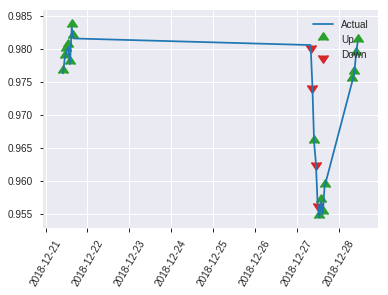


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20924162828565473
RMSE: 0.4574293697235178
LogLoss: 0.606236556380537
Mean Per-Class Error: 0.31994047619047616
AUC: 0.7407407407407407
pr_auc: 0.693332254410412
Gini: 0.4814814814814814
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3451635539531708: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   53   0.4732   (53.0/112.0)
1      18   90   0.1667   (18.0/108.0)
Total  77   143  0.3227   (71.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.345164     0.717131  142
max f2                       0.126091     0.851735  201
max f0point5                 0.616961     0.675676  83
max accuracy                 0.574939     0.677273  98
max precision                0.783301     0.833333  29
max recall                   0.126091     1         201
max specificity              0.939681     0.991071  0
max absolute_mcc             0.345164     0.377445  142
max min_per_class_accuracy   0.516351     0.651786  109
max mean_per_class_accuracy  0.345164     0.68006   142

Gains/Lift Table: Avg response rate: 49.09 %, avg score: 48.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.913519           1.35802   1.35802            0.666667         0.92742   0.666667                    0.92742             0.0185185       0.0185185                  35.8025   35.8025
    2        0.0227273                   0.886348           1.01852   1.22222            0.5              0.891286  0.6                         0.912966            0.00925926      0.0277778                  1.85185   22.2222
    3        0.0318182                   0.87967            2.03704   1.45503            1                0.885368  0.714286                    0.905081            0.0185185       0.0462963                  103.704   45.5026
    4        0.0409091                   0.869717           2.03704   1.58436            1                0.87372   0.777778                    0.898112            0.0185185       0.0648148                  103.704   58.4362
    5        0.05                        0.844383           2.03704   1.66667            1                0.858134  0.818182                    0.890843            0.0185185       0.0833333                  103.704   66.6667
    6        0.1                         0.805722           1.48148   1.57407            0.727273         0.826956  0.772727                    0.858899            0.0740741       0.157407                   48.1481   57.4074
    7        0.15                        0.762449           1.85185   1.66667            0.909091         0.785412  0.818182                    0.834404            0.0925926       0.25                       85.1852   66.6667
    8        0.2                         0.720879           1.66667   1.66667            0.818182         0.738508  0.818182                    0.81043             0.0833333       0.333333                   66.6667   66.6667
    9        0.3                         0.673729           1.11111   1.48148            0.545455         0.696292  0.727273                    0.772384            0.111111        0.444444                   11.1111   48.1481
    10       0.4                         0.599633           1.2037    1.41204            0.590909         0.643092  0.693182                    0.740061            0.12037         0.564815                   20.3704   41.2037
    11       0.5                         0.511562           0.925926  1.31481            0.454545         0.563911  0.645455                    0.704831            0.0925926       0.657407                   -7.40741  31.4815
    12       0.6                         0.40096            1.2037    1.2963             0.590909         0.456937  0.636364                    0.663515            0.12037         0.777778                   20.3704   29.6296
    13       0.7                         0.295143           0.833333  1.23016            0.409091         0.344945  0.603896                    0.618005            0.0833333       0.861111                   -16.6667  23.0159
    14       0.8                         0.221871           0.555556  1.14583            0.272727         0.256721  0.5625                      0.572845            0.0555556       0.916667                   -44.4444  14.5833
    15       0.9                         0.135322           0.648148  1.09053            0.318182         0.181221  0.535354                    0.529331            0.0648148       0.981481                   -35.1852  9.0535
    16       1                           0.0767642          0.185185  1                  0.0909091        0.103914  0.490909                    0.486789          

This function is available for GLM models only


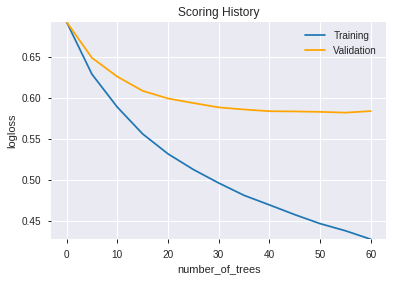

--2019-08-28 17:35:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

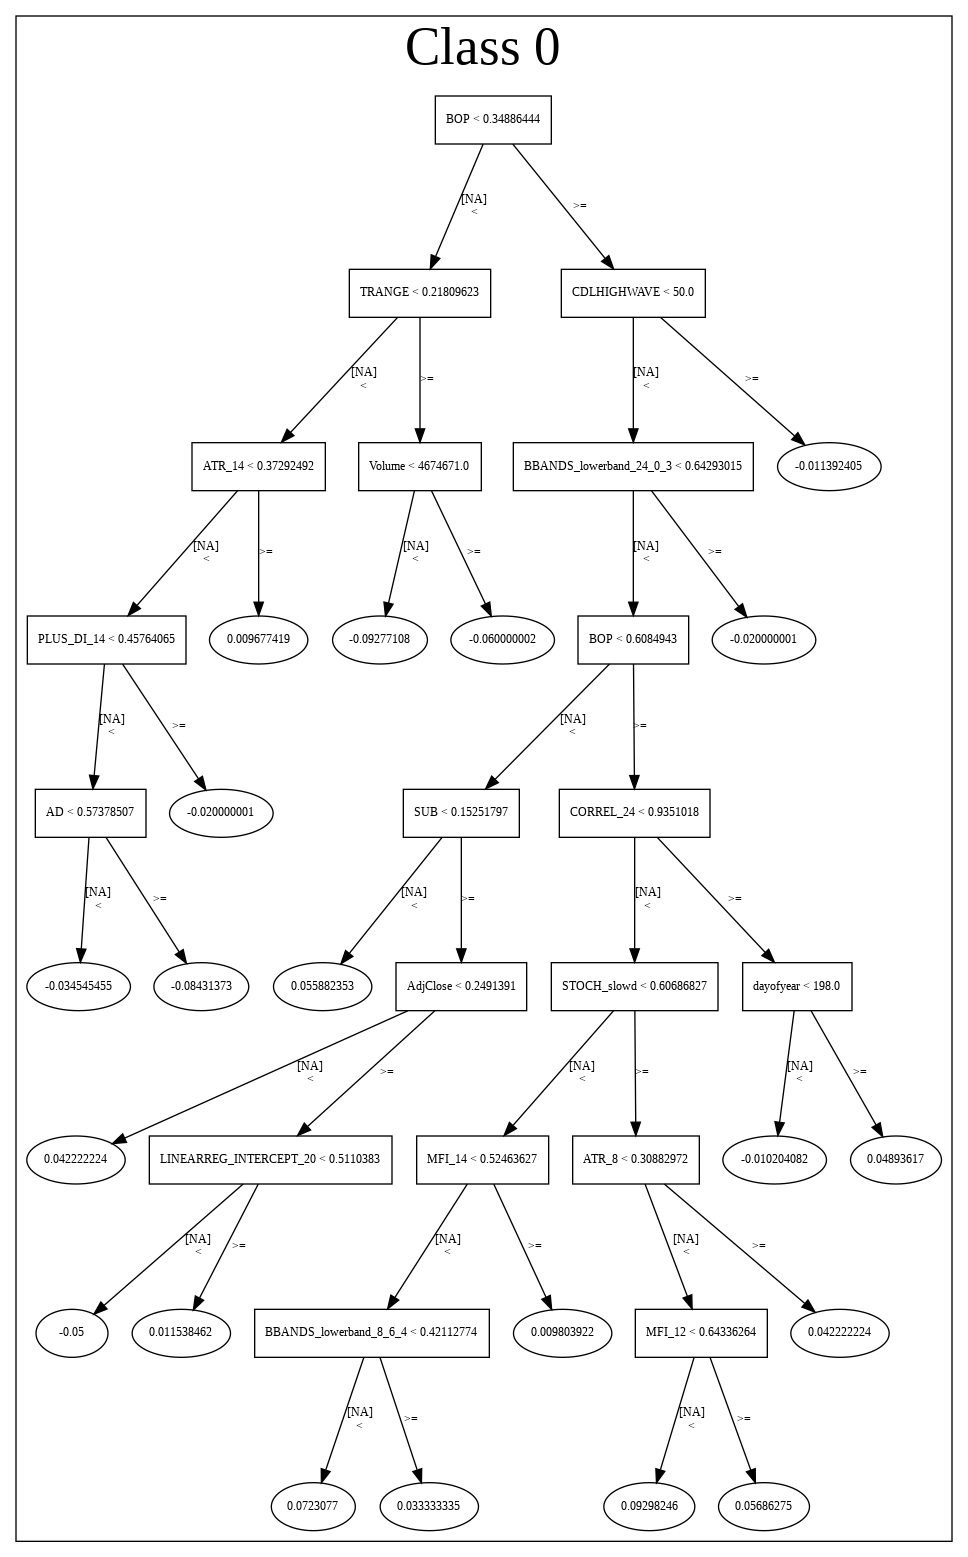

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_173457_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_173457_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8492',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastd',
 'HT_PHASOR_inphase',
 'STOCHRSI_fastk',
 'BETA_8',
 'HT_PHASOR_quadrature',
 'STDDEV_8',
 'CCI_14',
 'DX_30',
 'CCI_12',
 'NATR_8',
 'MACDEXT_hist',
 'WILLR_12',
 'ATR_24',
 'aroonup_12',
 'MFI_24',
 'ADX_24',
 'CCI_24',
 'WILLR_14',
 'PLUS_DI_30',
 'STOCH_slowk',
 'BETA_12',
 'BBANDS_upperband_30_7_4',
 'DX_24',
 'ROCP_8',
 'WILLR_30',
 'LINEARREG_ANGLE_12',
 'VAR_14',
 'MOM_24',
 'STDDEV_12',
 'ATR_8',
 'PLUS_DM_12',
 'MINUS_DM_8',
 'ROCR100_12',
 'CDLLONGLINE',
 'MFI_12',
 'AVGPRICE',
 'BBANDS_upperband_20_1_5',
 'CCI_30',
 'NATR_20',
 'NATR_12',
 'MACDFIX_14',
 'MA_24_7',
 'AROONOSC_20',
 'VAR_8',
 'aroonup_24',
 'AROONOSC_14',
 'PLUS_DM_20',
 'aroonup_20',
 'STOCHF_fastd',
 'CDLBELTHOLD',
 'RSI_12',
 'PLUS_DI_14',
 'AROONOSC_12',
 'ROCR100_8',
 'RSI_30',
 'ROCR_8']

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.718
GLM             0.705
XGBoost         0.709
dtype: float64

DeepLearning    GLM  XGBoost
All          0.691  0.627    0.686
DLF          0.686  0.695    0.709
Fwe          0.705  0.705    0.686
RFE          0.695  0.686    0.677
XGBF         0.718  0.695    0.709





F1


DeepLearning    0.727
GLM             0.738
XGBoost         0.746
dtype: float64

DeepLearning    GLM  XGBoost
All          0.717  0.702    0.727
DLF          0.724  0.738    0.746
Fwe          0.722  0.729    0.719
RFE          0.727  0.718    0.717
XGBF         0.726  0.738    0.746





auc


DeepLearning    0.751
GLM             0.751
XGBoost         0.747
dtype: float64

DeepLearning    GLM  XGBoost
All          0.728  0.672    0.731
DLF          0.738  0.727    0.729
Fwe          0.751  0.751    0.747
RFE          0.743  0.722    0.741
XGBF         0.742  0.727    0.729





logloss


DeepLearning    0.715
GLM             0.678
XGBoost         0.634
dtype: float64

DeepLearning    GLM  XGBoost
All          0.629  0.678    0.634
DLF          0.654  0.648    0.619
Fwe          0.605  0.607    0.602
RFE          0.715  0.616    0.606
XGBF         0.643  0.648    0.619





mean_per_class_error


DeepLearning    0.311
GLM             0.373
XGBoost         0.320
dtype: float64

DeepLearning    GLM  XGBoost
All          0.307  0.373    0.311
DLF          0.311  0.303    0.288
Fwe          0.296  0.296    0.313
RFE          0.302  0.313    0.320
XGBF         0.281  0.303    0.288





rmse


DeepLearning    0.482
GLM             0.490
XGBoost         0.466
dtype: float64

DeepLearning    GLM  XGBoost
All          0.468  0.490    0.466
DLF          0.461  0.467    0.462
Fwe          0.455  0.453    0.455
RFE          0.482  0.461    0.457
XGBF         0.462  0.467    0.462





mse


DeepLearning    0.233
GLM             0.240
XGBoost         0.218
dtype: float64

DeepLearning    GLM  XGBoost
All          0.219  0.240    0.218
DLF          0.213  0.218    0.213
Fwe          0.207  0.205    0.207
RFE          0.233  0.213    0.209
XGBF         0.214  0.218    0.213

{'F1':       DeepLearning    GLM  XGBoost
 All          0.717    NaN      NaN
 DLF          0.724    NaN      NaN
 DLF            NaN  0.738      NaN
 DLF            NaN    NaN    0.746
 All            NaN  0.702      NaN
 All            NaN    NaN    0.727
 XGBF         0.726    NaN      NaN
 XGBF           NaN  0.738      NaN
 XGBF           NaN    NaN    0.746
 Fwe          0.722    NaN      NaN
 Fwe            NaN  0.729      NaN
 Fwe            NaN    NaN    0.719
 RFE          0.727    NaN      NaN
 RFE            NaN  0.718      NaN
 RFE            NaN    NaN    0.717,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.691    NaN      NaN
 DLF          0.686    NaN      NaN
 DLF            NaN  0.695      NaN
 DLF            NaN    NaN    0.709
 All            NaN  0.627      NaN
 All            NaN    NaN    0.686
 XGBF         0.718    NaN      NaN
 XGBF           NaN  0.695      NaN
 XGBF           NaN    NaN    0.709
 Fwe          0.705    NaN      NaN
 Fwe     